# Exam Machine Learning with Python

Submitted by : 

Dries Luts (dries-luts@hotmail.com)<br />
Bino Maiheu (binomaiheu@gmail.com)<br />
Marijke Van De Steene (marijkevandesteene@hotmail.com)<br />

This notebook is submitted by the group above for the course exame "Machine Learning with Python", taught by Bart Van Rompaye. Course IPVW-
ICES 2024, **due date**: 2024-07-03 23:59. 

Source code as well as lists of issues are centralised in a github repository under https://github.com/Marijkevandesteene/MachineLearning, forked by Dries Luts and Bino Maiheu fore contributions. 

# Changelog

- **2024-06-05** [MV] : Initial version
- **2024-06-06** [BM] : Consolidated structure, imported initial analysis from notebooks BM, MV en DL 
- **2024-06-18** [BM] : Consolidated structure: Walkthrough in team / Finalized data preparation
- **2024-06-18** [MVDS] : Added data preparation steps on score / common used functions
- **2024-06-19** [BM] : Fixed issue w.r.t kNN imputer to apply for score
- **2024-06-23** [MVDS] : Random forest model tuning, Calibration / applied explainability / removed some try out code
- **2024-06-25** [DL] : Exploring SVM 
- **2024-06-28** [BM] : Added Gradient Booster + consolidation of notebook
- **2024-06-28** [DL] : Added onehotencoder + cleaning of the notebook
- **2024-06-28** [DL] : Added SVM and linear model for profit estimation
- **2024-06-29** [MVDS] : White boxing for selected revenue_best model (GBM) / selection of hotel guest / issues
- **2024-06-30** [DL] : Added SVM and linear model for damage amount estimation + added linear model for revenue + cleaning notebook and textual parts in the notebook + fixed some minor issues + restored parts of the notebook lost due to merge conflicts.
- **2024-07-01** [DL] : More textual changes + expanded logistic regression + reran models due to the changes in dataprep. Restored more parts of the notebook lost due to merge conflicts + added the export of SCORE.csv predictions prepared by [MVDS] + a new calculation for the executive summary + cleaning of the whiteboxing.
- **2024-07-02** [DL] : Added the SVC + fixed some minor issues + integrated input from [MVDS] for the summary figure.
- **2024-07-03** [MVDS] : 



# Initialisation

## Packages

In [239]:
# -- Importing packages
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import joblib

from pathlib import Path

In [240]:
# -- Import Machine learning libraries
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder  # for preprocessing & scaling
from sklearn.impute import SimpleImputer, KNNImputer   # for missing values imputation
from sklearn.model_selection import train_test_split  # train-test splits
from sklearn.calibration import CalibrationDisplay  # calibration curve plotting
from sklearn.metrics import classification_report  # performance matrix classifiaction report
from sklearn.linear_model import LogisticRegression  # Logistic regression modelling
from sklearn.ensemble import RandomForestClassifier  # Random Forest for classification
from sklearn.ensemble import GradientBoostingClassifier  # GBM for classification
from sklearn.ensemble import RandomForestRegressor  # Random Forest for classification
from sklearn.ensemble import GradientBoostingRegressor  # GBM for classification
from sklearn.ensemble import IsolationForest
from sklearn import svm  # support vector machines
from imblearn.over_sampling import SMOTE, RandomOverSampler  # Synthetic upsampling

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

from sklearn.inspection import permutation_importance
from sklearn import linear_model

from sklearn.metrics import recall_score
from statistics import mean

In [241]:
# -- Import Defined functions
import funcs.common_used_functions as cuf

## Notebook setup

In [242]:
# -- Setting plotting style
plt.style.use('seaborn-v0_8-darkgrid')

In [243]:
# -- Jupyter magic command to show plots inline immediately
%matplotlib inline

In [244]:
# -- Setting seed
seed = 43
np.random.seed(seed)

In [245]:
# -- pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Importing datafiles

In [246]:
# -- Loading the dataset for scoring Russian hotel guests
data_file_path = Path('input')  # Set to the path of folder where you can find 'train_V2.csv' and 'score.csv'

train_filename = data_file_path / 'train_V2.csv'
score_filename = data_file_path / 'score.csv'
dict_filename = data_file_path / 'dictionary.csv'

# -- Training & scoring data
train_V2 = pd.read_csv(train_filename)
score = pd.read_csv(score_filename)

# -- We load the dictionare as a dict
#    Note that small edits were made to the original file 
#    - tenure_yrs occurred twice, this was corrected
#    - income_am did not occur, was added...
dictionary = pd.read_csv(dict_filename, sep=';', header=None).set_index(0).to_dict(orient="dict")[1]

# -- Some feedback 
print('Training set shape: {}' .format(train_V2.shape))
print('Score set shape: {}' .format(score.shape))

Training set shape: (5000, 53)
Score set shape: (500, 50)


In [247]:
train_V2.head()

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,tenure_yrs,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,score1_pos,score1_neg,score2_pos,score2_neg,score3_pos,score3_neg,score4_pos,score4_neg,score5_pos,score5_neg,outcome_profit,outcome_damage_inc,outcome_damage_amount
0,227.0,0.0,3201.0,888.0,6.0,15000.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,True,2.0,1.0,28936.0,37.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,3.0,2.0,476.0,40.0,0.0,0.0,0.0,209.0,M,0.000000,0.0,0.0,0.0,0.467768,0.98334,NaN,NaN,NaN,NaN,0.838147,0.082288,NaN,NaN,1791.66,0,0.00
1,268.0,16.0,1682.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,1.0,0.0,7.0,True,3.0,0.0,16674.0,18.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,27.0,2.0,0.0,0.0,0.0,4.0,M,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.955259,1672.78,1,829.66
2,283.0,23.0,1673.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,True,4.0,0.0,32552.0,21.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,95.0,8.0,0.0,0.0,0.0,6.0,M,0.000000,0.0,0.0,0.0,NaN,NaN,0.232375,0.099529,NaN,NaN,NaN,NaN,0.101955,1.743020,1001.40,0,0.00
3,227.0,0.0,1685.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,True,8.0,1.0,32252.0,37.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,2.0,NaN,NaN,0.0,0.0,0.0,4.0,V,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.889793,NaN,NaN,NaN,NaN,1785.59,0,0.00
4,4091.0,1028.0,3425.0,785.0,2.0,14000.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,False,2.0,1.0,29605.0,26.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,2.0,0.0,354.0,30.0,0.0,0.0,0.0,3.0,V,1454.210627,1.0,0.0,0.0,NaN,NaN,NaN,NaN,0.330503,0.766294,0.490486,0.542445,NaN,NaN,3140.74,0,0.00


We first analyse some high level stuff regarding the loaded data.

In [248]:
# -- print list of features
print('Training set features : ')
print(train_V2.columns)

Training set features : 
Index(['income_am', 'profit_last_am', 'profit_am', 'damage_am', 'damage_inc',
       'crd_lim_rec', 'credit_use_ic', 'gluten_ic', 'lactose_ic',
       'insurance_ic', 'spa_ic', 'empl_ic', 'cab_requests', 'married_cd',
       'bar_no', 'sport_ic', 'neighbor_income', 'age', 'marketing_permit',
       'urban_ic', 'dining_ic', 'presidential', 'client_segment', 'sect_empl',
       'prev_stay', 'prev_all_in_stay', 'divorce', 'fam_adult_size',
       'children_no', 'tenure_mts', 'tenure_yrs', 'company_ic', 'claims_no',
       'claims_am', 'nights_booked', 'gender', 'shop_am', 'shop_use',
       'retired', 'gold_status', 'score1_pos', 'score1_neg', 'score2_pos',
       'score2_neg', 'score3_pos', 'score3_neg', 'score4_pos', 'score4_neg',
       'score5_pos', 'score5_neg', 'outcome_profit', 'outcome_damage_inc',
       'outcome_damage_amount'],
      dtype='object')


In [249]:
# -- compare the feaures in the training & score sets
print("Features in the training set but not in the scoring set (target variables) : ")
set(train_V2.columns).difference(set(score.columns))

Features in the training set but not in the scoring set (target variables) : 


{'outcome_damage_amount', 'outcome_damage_inc', 'outcome_profit'}

In [250]:
# -- Adding an index to the 
train_V2.insert(0, 'Id', range(0, 0 + len(train_V2)))
if 'Id' in train_V2.columns:
    train_V2 = train_V2.set_index('Id')

# 0-500 voor score of lengte train_v2 > lengte  + 500?

score.insert(0, 'Id', range(0, 0 + len(score)))
if 'Id' in score.columns:
    score = score.set_index('Id')


In [251]:
# -- Print some info
train_V2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 0 to 4999
Data columns (total 53 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   income_am              4947 non-null   float64
 1   profit_last_am         4947 non-null   float64
 2   profit_am              4947 non-null   float64
 3   damage_am              4954 non-null   float64
 4   damage_inc             4947 non-null   float64
 5   crd_lim_rec            4947 non-null   float64
 6   credit_use_ic          4947 non-null   float64
 7   gluten_ic              4947 non-null   float64
 8   lactose_ic             4947 non-null   float64
 9   insurance_ic           4947 non-null   float64
 10  spa_ic                 4970 non-null   float64
 11  empl_ic                4999 non-null   float64
 12  cab_requests           4912 non-null   float64
 13  married_cd             5000 non-null   bool   
 14  bar_no                 4947 non-null   float64
 15  sport_ic 

# Dataset preparation

Ok, now that we have our data loaded, lets dive into the anlysis.  In this section we shall check for consistency, handle missing values, outliers etc... We first start  with extracting categorical and numerical features

## Extraction of categorical and numerical features

It's not clear immediately what the categorical and numerical features are in the dataset, this is important for later on (e.g. imputation of missing values), so we spend a little time analysing this. 


Here we aim to get a list of feature names (i.e. column names) one with categorical features, one with numerical features

In [252]:
# -- test the number of unique values in the dataframe
train_nunique = train_V2.nunique()
train_nunique

income_am                2109
profit_last_am           1452
profit_am                2139
damage_am                 616
damage_inc                 11
crd_lim_rec                41
credit_use_ic               2
gluten_ic                   2
lactose_ic                  2
insurance_ic                2
spa_ic                      2
empl_ic                     2
cab_requests               17
married_cd                  2
bar_no                     47
sport_ic                    2
neighbor_income          3042
age                        72
marketing_permit            2
urban_ic                    2
dining_ic                   2
presidential                2
client_segment              6
sect_empl                   6
prev_stay                   2
prev_all_in_stay            2
divorce                     2
fam_adult_size              4
children_no                 7
tenure_mts                586
tenure_yrs                 58
company_ic                  2
claims_no                  10
claims_am 

In [253]:
print("Binary features: ")
train_nunique[ train_nunique == 2 ].index

Binary features: 


Index(['credit_use_ic', 'gluten_ic', 'lactose_ic', 'insurance_ic', 'spa_ic',
       'empl_ic', 'married_cd', 'sport_ic', 'marketing_permit', 'urban_ic',
       'dining_ic', 'presidential', 'prev_stay', 'prev_all_in_stay', 'divorce',
       'company_ic', 'gender', 'shop_use', 'retired', 'gold_status',
       'outcome_damage_inc'],
      dtype='object')

We see quite some variables with only 2 unique values, and from looking at the dictionary, those likely will be binary features : true/false. 

Additionally, we see that the features `client_segment` as well as `sect_empl` also only contain 6 unique values and from the dictionary (client and employment sectors), it is safe to assume that those features are also categorical. Some additional features also contain a limited amount of unique values, however, judging from the dictionary those should not be considered categorical : 
- `fam_adult_size`: number of adults in family
- `children_no` : number of children

So, in summary we can create the following classification for the features (categorical/numerical):

In [254]:
# the categorical input features are those with 2 unique values, as well as client_segment and sect_empl, but not the ones which start with outcome, those are target features
categorical_input_features = [ 'client_segment', 'sect_empl', *train_nunique[ (train_nunique == 2) & ~train_nunique.index.str.startswith('outcome_') ].index.to_list() ]

# the numerical input features the other ones but not the ones which start with outcome, those are target features
numerical_input_features = train_V2.columns[ ~train_V2.columns.isin(categorical_input_features) & ~train_V2.columns.str.startswith('outcome_')].to_list()

# these are the target features in the dataframe
target_features = ['outcome_profit', 'outcome_damage_amount', 'outcome_damage_inc']

### Categorical input features

These are the resulting categorical input features :

In [255]:
for ft in categorical_input_features:
    print(f"- {ft} : {dictionary[ft]}")

- client_segment : segment of client
- sect_empl : employment sector
- credit_use_ic : previously used hotel credit
- gluten_ic : allergic to gluten
- lactose_ic : lactose intolerant
- insurance_ic : use of hotel insurance
- spa_ic : spa user
- empl_ic : employee of chain
- married_cd : marital status
- sport_ic : user of sports facilities
- marketing_permit : marketing contact allowed
- urban_ic : from urban region (vs rural)
- dining_ic : use of in-hotel restaurants
- presidential : previous use of presidential suite
- prev_stay : previous stay at hotel indicator
- prev_all_in_stay : previous stay at hotel with all-in formula indicator
- divorce : indicator divorce
- company_ic : indicator company card
- gender : gender code
- shop_use : used hotel shop court
- retired : retired indicator
- gold_status : gold client profile


### Numerical input features
These are the resulting numerical features 

In [256]:
for ft in numerical_input_features:
    print(f"- {ft} : {dictionary[ft]}")

- income_am : income (added)
- profit_last_am : profit across second last visit
- profit_am : total profit across visits  (excluding last visit)
- damage_am : total amount of damages  (excluding last visit)
- damage_inc : number of damage incidents  (excluding last visit)
- crd_lim_rec : Recommended limit hotel credit 
- cab_requests : number of cab requests
- bar_no : number of hotel bar visits
- neighbor_income : Mean taxable income of neighborhood
- age : age
- fam_adult_size : number of adults in family
- children_no : number of known children
- tenure_mts : months as client in months
- tenure_yrs : years as client in years
- claims_no : number of claims against hotel
- claims_am : compensations payed after claims
- nights_booked : total nights booked at chain
- shop_am : amount spent in shop
- score1_pos : positivity' score, given by staff, as quantile, from hotel 1
- score1_neg : negativity' score, given by staff, as quantile, from hotel 1
- score2_pos : positivity' score, given 

### Target features
These are the target features (initially... in the further analysis, this will be refined)

In [257]:
for ft in target_features:
    print(f"- {ft} : {dictionary[ft]}")

- outcome_profit : profit of last visit
- outcome_damage_amount : damage amount after last visit
- outcome_damage_inc : damage incident in last visit


### Discussion on memory consumption

Ideally, to reduce the **memory footprint** of this data, we reallocate the categorical variables to a smaller integer, or even a boolean. Currently the variables are in memory as 64 bit floats which is way to large. At the moment we leave things as they are & come back to this if time permits. Note that we will make some alterations onwards as some features, like gender are "objects", i.e. strings. 

## Dataset consistency tests

### Feature types

Some observations in the output of `train_V2.info()` above here: 

- all the variables seem to be numeric (encoded as float64), except for:
- `gender` : object contains 'M' or 'V', we will replace those with 0 and 1 for consistency with the other variables
- `married_cd` : appears to be a boolean, so clearly this is categorical

Let's first look at the feature types. 

In [258]:
train_V2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 0 to 4999
Data columns (total 53 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   income_am              4947 non-null   float64
 1   profit_last_am         4947 non-null   float64
 2   profit_am              4947 non-null   float64
 3   damage_am              4954 non-null   float64
 4   damage_inc             4947 non-null   float64
 5   crd_lim_rec            4947 non-null   float64
 6   credit_use_ic          4947 non-null   float64
 7   gluten_ic              4947 non-null   float64
 8   lactose_ic             4947 non-null   float64
 9   insurance_ic           4947 non-null   float64
 10  spa_ic                 4970 non-null   float64
 11  empl_ic                4999 non-null   float64
 12  cab_requests           4912 non-null   float64
 13  married_cd             5000 non-null   bool   
 14  bar_no                 4947 non-null   float64
 15  sport_ic 

In [259]:
score.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 50 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   income_am         496 non-null    float64
 1   profit_last_am    496 non-null    float64
 2   profit_am         496 non-null    float64
 3   damage_am         497 non-null    float64
 4   damage_inc        496 non-null    float64
 5   crd_lim_rec       496 non-null    float64
 6   credit_use_ic     496 non-null    float64
 7   gluten_ic         496 non-null    float64
 8   lactose_ic        496 non-null    float64
 9   insurance_ic      496 non-null    float64
 10  spa_ic            498 non-null    float64
 11  empl_ic           500 non-null    float64
 12  cab_requests      495 non-null    float64
 13  married_cd        500 non-null    bool   
 14  bar_no            496 non-null    float64
 15  sport_ic          496 non-null    float64
 16  neighbor_income   479 non-null    float64
 17  ag

In [260]:
# -- re-assign the gender to 0 or 1 
train_V2['gender'] = train_V2['gender'].map({'M': 0, 'V': 1}) # M = 0, V = 1
score['gender'] = score['gender'].map({'M': 0, 'V': 1}) # M = 0, V = 1

### Histogram analysis of the score variables

When looking a bit more closely to the distribution of the score variables, we noticed that score5_neg did not conform to the rest of the data. In the introductory document to the exam, it was stated that these score variables represented quantiles. Likely in case of hotel 5, this is still a raw score which has not been converted to a quantile yet.

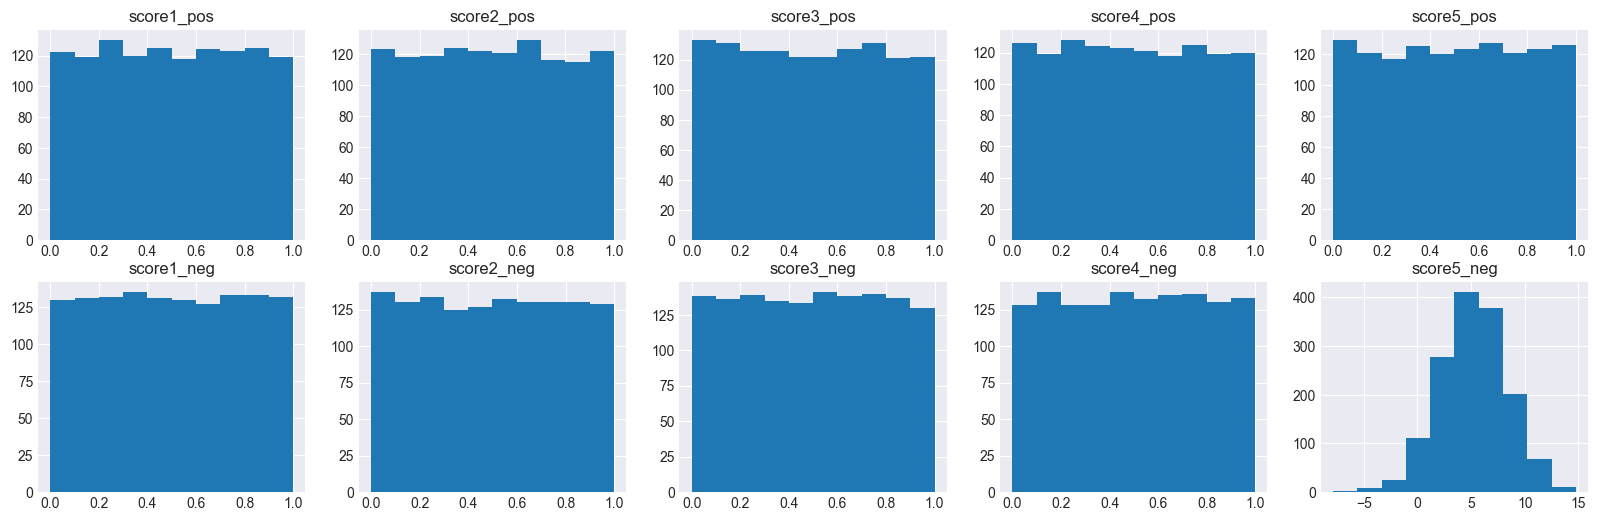

In [261]:
fig, axs = plt.subplots(2, 5, figsize=(20,6))
for k in range(5):     
    train_V2[f"score{k+1}_pos"].hist(ax=axs[0][k])
    train_V2[f"score{k+1}_neg"].hist(ax=axs[1][k])

    axs[0][k].set_title(f"score{k+1}_pos")
    axs[1][k].set_title(f"score{k+1}_neg")

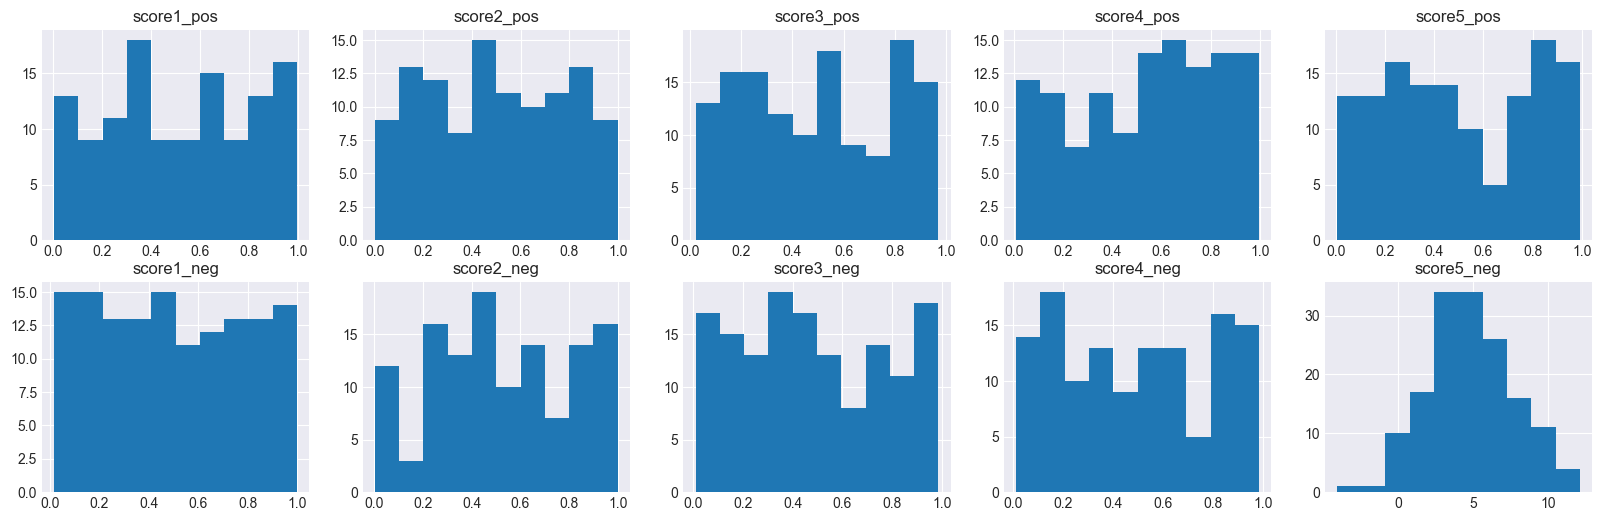

In [262]:
# histogram score
fig, axs = plt.subplots(2, 5, figsize=(20,6))
for k in range(5):     
    score[f"score{k+1}_pos"].hist(ax=axs[0][k])
    score[f"score{k+1}_neg"].hist(ax=axs[1][k])

    axs[0][k].set_title(f"score{k+1}_pos")
    axs[1][k].set_title(f"score{k+1}_neg")

Let's in case of hotel 5 convert this score to a quantile value. To do this, we have to be a bit careful. An easy way to handle this would be to calculate the percentile rank for the score, e.g.: 

```python
train_V2["score5_neg_uniform"]  = train_V2["score5_neg"].rank(method='max', pct=True)
```

However, it would be rather difficult to apply this consistently on the independent score dataset later on. So, as an alternative we will get the quantiles from the cumulative distribution function, we can do this via the emprical cdf or rescale the distribution to zero mean and unit variance, assuming it's shape to be - let's say - Gaussian and compute the quantiles from that cdf, keeping things simple, we opted to calculate the z-score, assume the distirbution is roughly Gaussian(without rigorously checking, as this probably won't affect the result significantly) in the following way, using `scipy.stats.norm.cdf`.

In [263]:
train_V2["score5_neg_uniform"] = ( train_V2["score5_neg"] - train_V2["score5_neg"].mean() ) / train_V2["score5_neg"].std()
train_V2["score5_neg_uniform"] = stats.norm.cdf(train_V2["score5_neg_uniform"])
score["score5_neg_uniform"] = ( score["score5_neg"] - train_V2["score5_neg"].mean() ) / train_V2["score5_neg"].std()
score["score5_neg_uniform"] = stats.norm.cdf(score["score5_neg_uniform"])

Text(0.5, 1.0, 'score5_neg_uniform vs score5_pos')

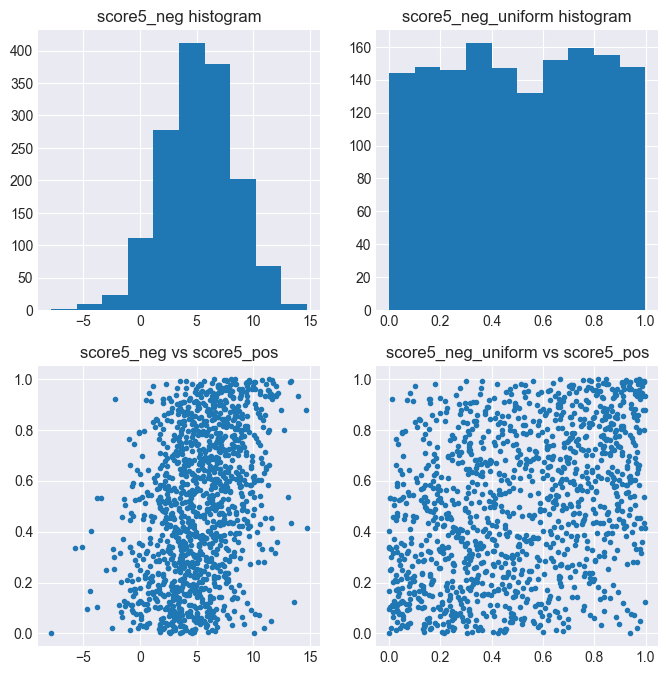

In [264]:
# -- a small check
fig, axs = plt.subplots(2,2, figsize=(8,8))
train_V2["score5_neg"].hist(ax=axs[0][0])
train_V2["score5_neg_uniform"].hist(ax=axs[0][1])

axs[1][0].plot(train_V2["score5_neg"], train_V2["score5_pos"], '.')
axs[1][1].plot(train_V2["score5_neg_uniform"], train_V2["score5_pos"], '.')

axs[0][0].set_title("score5_neg histogram")
axs[0][1].set_title("score5_neg_uniform histogram")
axs[1][0].set_title("score5_neg vs score5_pos")
axs[1][1].set_title("score5_neg_uniform vs score5_pos")

Text(0.5, 1.0, 'score5_neg_uniform vs score5_pos')

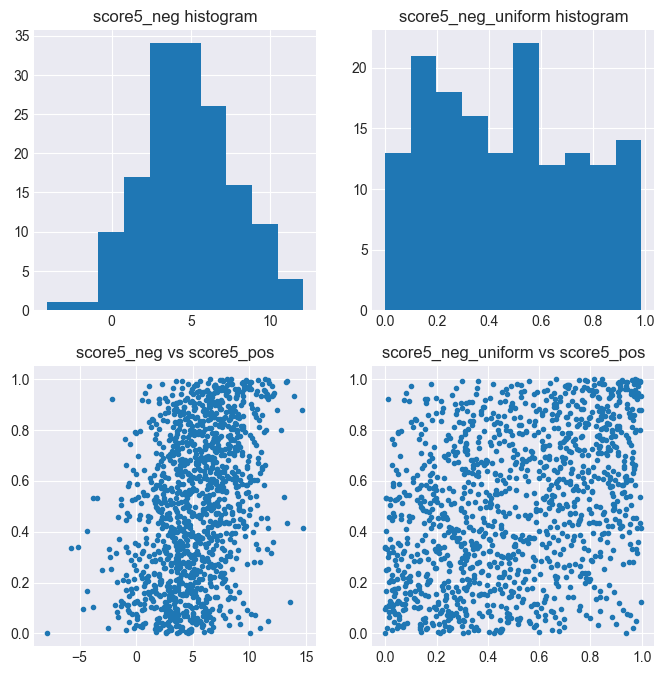

In [265]:
# -- a similar check on score data
fig, axs = plt.subplots(2,2, figsize=(8,8))
score["score5_neg"].hist(ax=axs[0][0])
score["score5_neg_uniform"].hist(ax=axs[0][1])

axs[1][0].plot(train_V2["score5_neg"], train_V2["score5_pos"], '.')
axs[1][1].plot(train_V2["score5_neg_uniform"], train_V2["score5_pos"], '.')

axs[0][0].set_title("score5_neg histogram")
axs[0][1].set_title("score5_neg_uniform histogram")
axs[1][0].set_title("score5_neg vs score5_pos")
axs[1][1].set_title("score5_neg_uniform vs score5_pos")

In [266]:
#  -- and now replace the variable in the dataset for training data and for score
train_V2['score5_neg'] = train_V2['score5_neg_uniform']
train_V2.drop(columns=['score5_neg_uniform'], inplace=True)
score['score5_neg'] = score['score5_neg_uniform']
score.drop(columns=['score5_neg_uniform'], inplace=True)

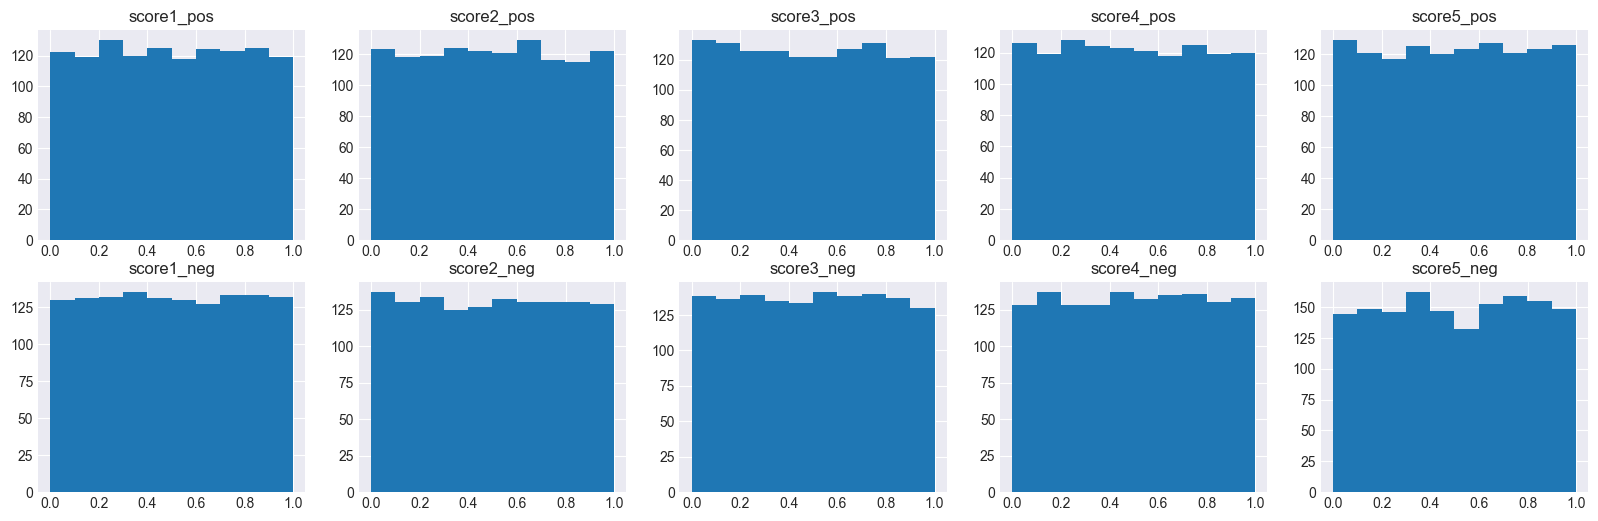

In [267]:
# -- make a small plot to check the results:
fig, axs = plt.subplots(2, 5, figsize=(20,6))
for k in range(5):     
    train_V2[f"score{k+1}_pos"].hist(ax=axs[0][k])
    train_V2[f"score{k+1}_neg"].hist(ax=axs[1][k])

    axs[0][k].set_title(f"score{k+1}_pos")
    axs[1][k].set_title(f"score{k+1}_neg")

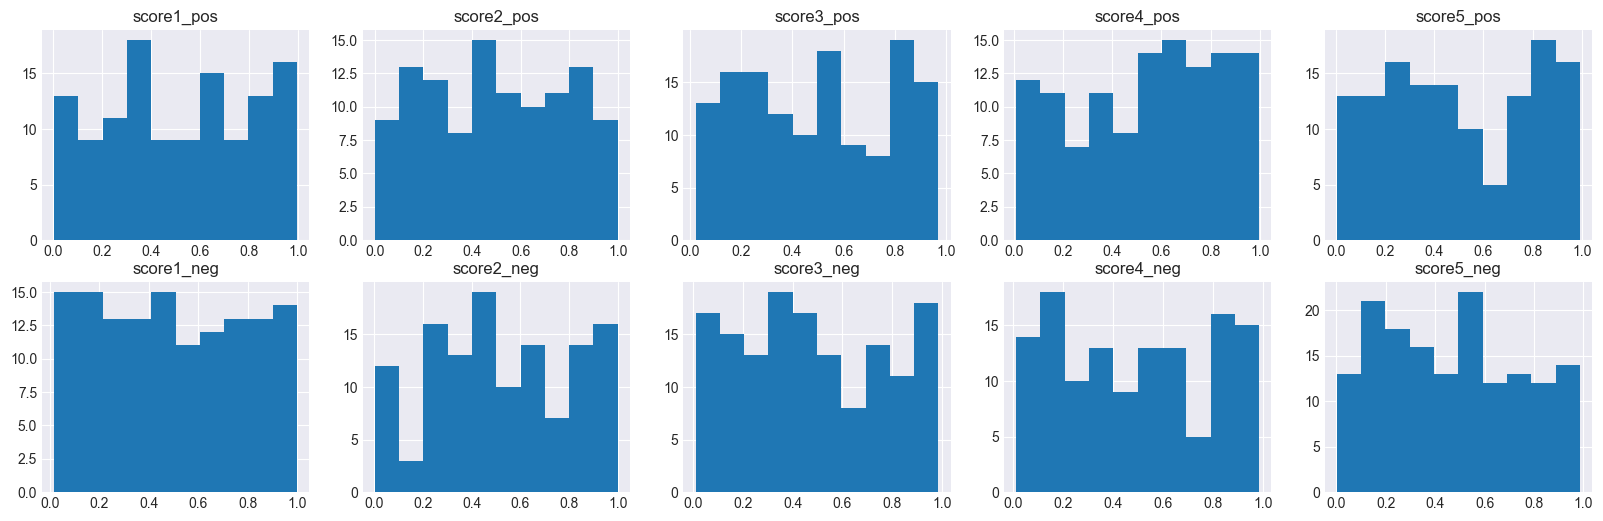

In [268]:
fig, axs = plt.subplots(2, 5, figsize=(20,6))
for k in range(5):     
    score[f"score{k+1}_pos"].hist(ax=axs[0][k])
    score[f"score{k+1}_neg"].hist(ax=axs[1][k])

    axs[0][k].set_title(f"score{k+1}_pos")
    axs[1][k].set_title(f"score{k+1}_neg")

### Consistency between damage incurred and damage amount

In [269]:
print(f"Max damage amount when no damage is incurred : {train_V2.loc[train_V2['outcome_damage_inc'] == 0, 'outcome_damage_amount'].max()}")
print(f"Min damage amount when damage is incurred : {train_V2.loc[train_V2['outcome_damage_inc'] == 1, 'outcome_damage_amount'].min()}")

Max damage amount when no damage is incurred : 0.0
Min damage amount when damage is incurred : 0.0


Ha, so there are cases for which there is damage incurred, but the amount of the damage is 0 ... interesting

## Handling of  missing data


### Methodology steps 

In this section we will in tree steps deal with missing data in the training and score datasets. 
1. Overview of the number of missing values per features.
2. Special processing for the features containing the scores given by previously visited hotels.
3. Dealing with the other features that have missing data

### General analysis

In [270]:
# Getting an idea about total missing values
total_missings = train_V2.isnull().sum().sort_values(ascending=False)  # total missng values, sorted
print("Top 20 of most missing features : ")
total_missings.head(20)  # Show top 20 most missing features

Top 20 of most missing features : 


score2_pos         3791
score4_pos         3777
score1_pos         3775
score5_pos         3768
score3_pos         3739
score2_neg         3696
score1_neg         3686
score4_neg         3676
score3_neg         3633
score5_neg         3507
tenure_yrs          392
tenure_mts          392
neighbor_income     239
shop_use             88
presidential         88
cab_requests         88
dining_ic            88
company_ic           53
claims_no            53
income_am            53
dtype: int64

<Axes: title={'center': 'Number of missing values per feature'}>

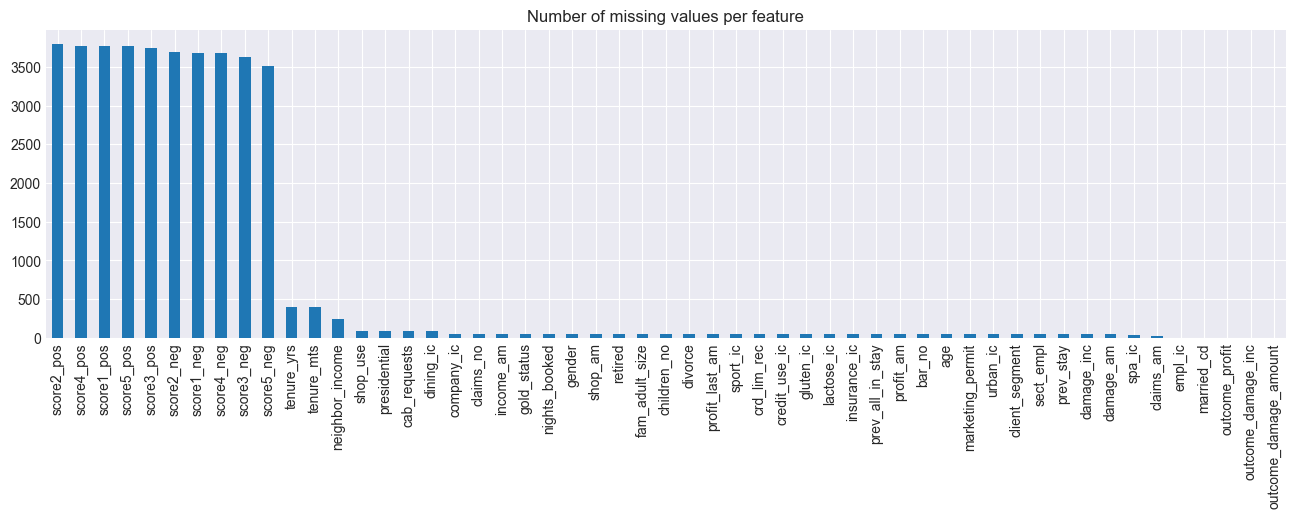

In [271]:
total_missings.plot(kind='bar', figsize=(16,4), title="Number of missing values per feature")

In [272]:
# Getting an idea about percentage missing values
pct_missings = train_V2.isnull().mean().sort_values(ascending=False)  # average (%) missng values, sorted
#pct_missings.head(20)  # Show top 20 most missing features

We split of the score features to be able to get a better view on the other features who do not have that many mising values.

<Axes: ylabel='pct. missing [%]'>

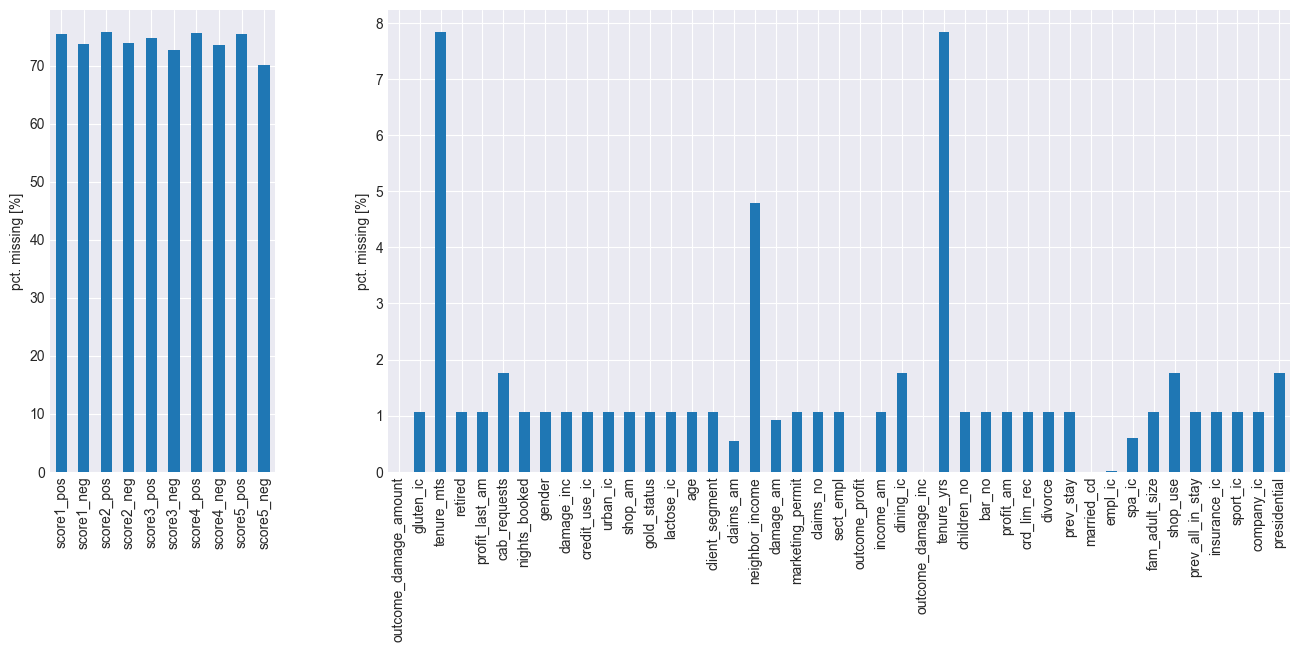

In [273]:
score_vars = [ f"score{i+1}_{xx}" for i in range(5) for xx in ("pos", "neg") ]
other_vars = list(set(train_V2.columns).difference(score_vars))

fig, axs = plt.subplots(1, 2, figsize=(16,6), gridspec_kw={'width_ratios': [1, 4]})

axs[0].set_ylabel('pct. missing [%]')
axs[1].set_ylabel('pct. missing [%]')

pct_missings[score_vars].multiply(100.).plot(kind='bar', ax=axs[0])
pct_missings[other_vars].multiply(100.).plot(kind='bar', ax=axs[1])

Some conclusions :
- No missing values in the outcomes.
- A lot of missing values in the scores given by the hotels (> 70% of the data), however despite the large quantity of missing data, it doesn't seem a good idea to throw away this data as the score given by other hotels in the chain may be a very relevant predictor, so we decide to keep these features and treat the missing values (which in its own right may be relevant information as well). 
- Tenure_mts does have almost 10% missing --> perhaps we should not just drop it, but re-use the years to fill in the missings.
- It's striking that a large number of features report the same amount of missing values, so these are probably a set of rows which we should consider dropping.

### Treatment of the score values

The imputation of the score values is somewhat tricky. There is potentially a lot of information encoded in there, but also > 70 % of missing values. First of all we do not know from the dataset what hotels correspond to 1, 2, ... 5 also we do not know from the description that hotel 1 from the training set corresponds to hotel 1 in the score set. By aggregating the scores (.e.g. calculating a mean over the hotels for both the positivity and negativity scores, we can already get rid of a lot of missing values, however the downside is that the information on what hotel did give the score is lost then). Still this may be a good way forward as we don't know for sure whether the hotels in the training & score set correspond (though it's probably safe to assume so). One caveat with this approach is that we would be averaging quantile values, which may not be entirely consistent, so it would probably be better to average the original scores, but then we would have to make assumptions on the underlying distribution of these original scores.  

For a discussion we refer to : https://github.com/Marijkevandesteene/MachineLearning/issues/8

In [274]:
train_V2["avg_score_pos"] = train_V2[["score1_pos", "score2_pos", "score3_pos", "score4_pos", "score5_pos"]].mean(axis=1)
train_V2["avg_score_neg"] = train_V2[["score1_neg", "score2_neg", "score3_neg", "score4_neg", "score5_neg"]].mean(axis=1)

score["avg_score_pos"] = train_V2[["score1_pos", "score2_pos", "score3_pos", "score4_pos", "score5_pos"]].mean(axis=1)
score["avg_score_neg"] = train_V2[["score1_neg", "score2_neg", "score3_neg", "score4_neg", "score5_neg"]].mean(axis=1)

In [275]:
train_V2[["score1_pos", "score2_pos", "score3_pos", "score4_pos", "score5_pos"]].head()

,score1_pos,score2_pos,score3_pos,score4_pos,score5_pos
Id,,,,,
0,0.467768,NaN,NaN,0.838147,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,0.232375,NaN,NaN,0.101955
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,0.330503,0.490486,NaN


Text(0.5, 1.0, 'avg_score_pos')

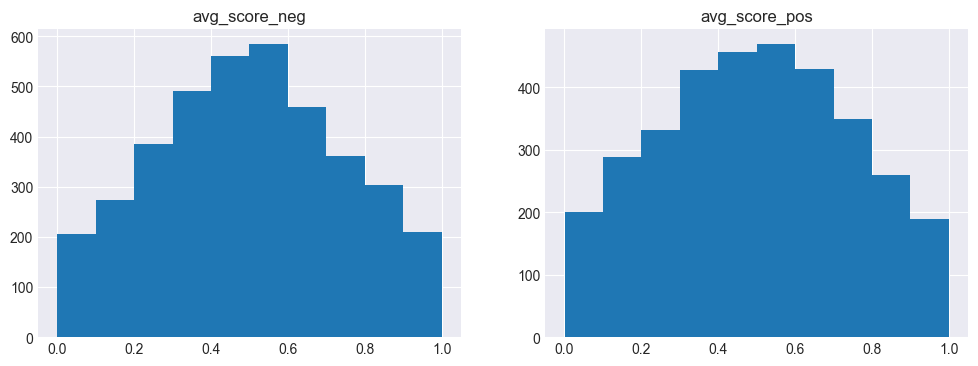

In [276]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
train_V2["avg_score_neg"].hist(ax=axs[0])
train_V2["avg_score_pos"].hist(ax=axs[1])
axs[0].set_title("avg_score_neg")
axs[1].set_title("avg_score_pos")

Text(0.5, 1.0, 'avg_score_pos')

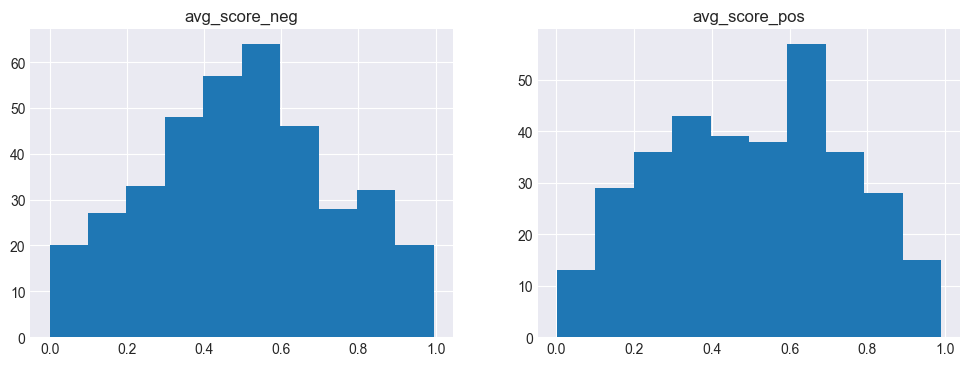

In [277]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
score["avg_score_neg"].hist(ax=axs[0])
score["avg_score_pos"].hist(ax=axs[1])
axs[0].set_title("avg_score_neg")
axs[1].set_title("avg_score_pos")

In [278]:
# missing percentages when computing the mean
train_V2[["avg_score_pos", "avg_score_neg"]].isnull().mean().sort_values(ascending=False)

avg_score_pos    0.3194
avg_score_neg    0.2332
dtype: float64

We can see that is we compute the mean, we already reduce the number of missings to about 20 - 30 %, which is already an improvement compared to the ~70 % missing values on average per hotel. The fact however that scores for hotel guests are missing may also be a relevant features, so we decide to include that as an additional feature, but in fact we can also count how many hotels have given the score, so 0 will be no hotels (i.e. missing) and then 1 -> 5 for how many hotels have given the score. That way we include the maximum amount of information from the original scores, only neglecting the actual hotels which have given the score which we don't know anyway which is which from the data given and whether the hotel labels are consistent between training & score set. That way we can think of imputing an average score to keep those records in the dataset, as we know it was originally missing (i.e. num_score_pos/neg == 0)

In [279]:
# -- count the number of hotels which have given a score, so 0 means it was originally missing for all the hotels
train_V2["num_score_pos"] = (~train_V2[["score1_pos", "score2_pos", "score3_pos", "score4_pos", "score5_pos"]].isnull()).sum(axis=1)
train_V2["num_score_neg"] = (~train_V2[["score1_neg", "score2_neg", "score3_neg", "score4_neg", "score5_neg"]].isnull()).sum(axis=1)

score["num_score_pos"] = (~train_V2[["score1_pos", "score2_pos", "score3_pos", "score4_pos", "score5_pos"]].isnull()).sum(axis=1)
score["num_score_neg"] = (~train_V2[["score1_neg", "score2_neg", "score3_neg", "score4_neg", "score5_neg"]].isnull()).sum(axis=1)

# -- and add it to the categorical variables
numerical_input_features = [ ft for ft in numerical_input_features if not ft.startswith("score") ]
numerical_input_features.extend(["avg_score_pos", "avg_score_neg", "num_score_pos", "num_score_neg"])

In [280]:
# -- now drop the original scores from the dataset and from the score dataset
train_V2.drop(columns=["score1_pos", "score2_pos", "score3_pos", "score4_pos", "score5_pos"], inplace=True)
train_V2.drop(columns=["score1_neg", "score2_neg", "score3_neg", "score4_neg", "score5_neg"], inplace=True)

score.drop(columns=["score1_pos", "score2_pos", "score3_pos", "score4_pos", "score5_pos"], inplace=True)
score.drop(columns=["score1_neg", "score2_neg", "score3_neg", "score4_neg", "score5_neg"], inplace=True)

In [281]:
train_V2.head()

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,tenure_yrs,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,outcome_profit,outcome_damage_inc,outcome_damage_amount,avg_score_pos,avg_score_neg,num_score_pos,num_score_neg
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,227.0,0.0,3201.0,888.0,6.0,15000.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,True,2.0,1.0,28936.0,37.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,3.0,2.0,476.0,40.0,0.0,0.0,0.0,209.0,0.0,0.000000,0.0,0.0,0.0,1791.66,0,0.00,0.652958,0.532814,2,2
1,268.0,16.0,1682.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,1.0,0.0,7.0,True,3.0,0.0,16674.0,18.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,27.0,2.0,0.0,0.0,0.0,4.0,0.0,0.000000,0.0,0.0,0.0,1672.78,1,829.66,NaN,0.808991,0,1
2,283.0,23.0,1673.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,True,4.0,0.0,32552.0,21.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,95.0,8.0,0.0,0.0,0.0,6.0,0.0,0.000000,0.0,0.0,0.0,1001.40,0,0.00,0.167165,0.118495,2,2
3,227.0,0.0,1685.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,True,8.0,1.0,32252.0,37.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,2.0,NaN,NaN,0.0,0.0,0.0,4.0,1.0,0.000000,0.0,0.0,0.0,1785.59,0,0.00,NaN,0.889793,0,1
4,4091.0,1028.0,3425.0,785.0,2.0,14000.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,False,2.0,1.0,29605.0,26.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,2.0,0.0,354.0,30.0,0.0,0.0,0.0,3.0,1.0,1454.210627,1.0,0.0,0.0,3140.74,0,0.00,0.410495,0.654370,2,2


### Dealing with the missing values in the tenure_yrs feature

In the analysis above we also noticed a significant amount of missing values for `tenure_yrs` and `tenure_mts`. What is also striking is that probably both variables express the same quantity, once expressed in months and once in years. Let's visualise that in a scatter plot: 

In [282]:
train_V2[["tenure_mts", "tenure_yrs"]].head()

,tenure_mts,tenure_yrs
Id,,
0,476.0,40.0
1,27.0,2.0
2,95.0,8.0
3,NaN,NaN
4,354.0,30.0


Text(0.5, 0, '12 * tenure_yrs')

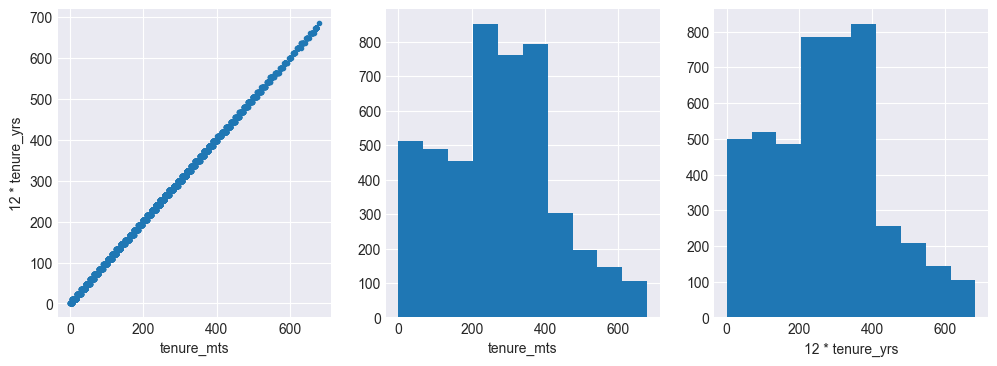

In [283]:
# -- make a scatterplot 
fig, axs = plt.subplots(1, 3, figsize=(12,4))
axs[0].plot(train_V2['tenure_mts'], 12.*train_V2['tenure_yrs'], '.')
axs[0].set_xlabel("tenure_mts")
axs[0].set_ylabel("12 * tenure_yrs")
train_V2["tenure_mts"].hist(ax=axs[1])
axs[1].set_xlabel("tenure_mts")
(12.*train_V2["tenure_yrs"]).hist(ax=axs[2])
axs[2].set_xlabel("12 * tenure_yrs")

First we check if both variables contain the same missings as imputing missing `tenure_mts` from `tenure_yrs` would be a straightforward choice

In [284]:
# -- get the missing values for both
tenure_num_values = train_V2[["tenure_mts", "tenure_yrs"]].isna().sum(axis=1)
# -- test how many only have 1 missing value, so either tenure_mts or tenure_yrs, but not both present or absent
tenure_num_values[tenure_num_values == 1].any()

False

In [285]:
# -- get the missing values for both in the score dataset
tenure_num_values = score[["tenure_mts", "tenure_yrs"]].isna().sum(axis=1)
# -- test how many only have 1 missing value, so either tenure_mts or tenure_yrs, but not both present or absent
tenure_num_values[tenure_num_values == 1].any()

False

No, so `tenure_mts` `tenure_yrs` either both occur in the dataset, or neither of them. So clearly, both are expressing the same variable, once expressed in years, once in months and having established that we can't directly use either one to impute missing values in the other feature, it probably makes no sense to include both. Let's therefore omit the one with the lowest granularity: 

In [286]:
train_V2.drop(columns=['tenure_yrs'], inplace=True)
score.drop(columns=['tenure_yrs'], inplace=True)

numerical_input_features.remove("tenure_yrs")

### Dealing with the remaining missings

We still see that for a large amount of features, there are a lot of missing values. Likely, these are records which are not complete. We can clearly see this in the histogram below, which plots a histogram of the the number of missing features per record. 

In [287]:
# number of features
print(f"Number of features train_V2 dataset after transformations so far: {len(train_V2.columns)}")
print(f"Number of features score dataset after transformations so far: {len(score.columns)}")

Number of features train_V2 dataset after transformations so far: 46
Number of features score dataset after transformations so far: 43


Text(0.5, 0, 'Missing features per record for the score dataset')

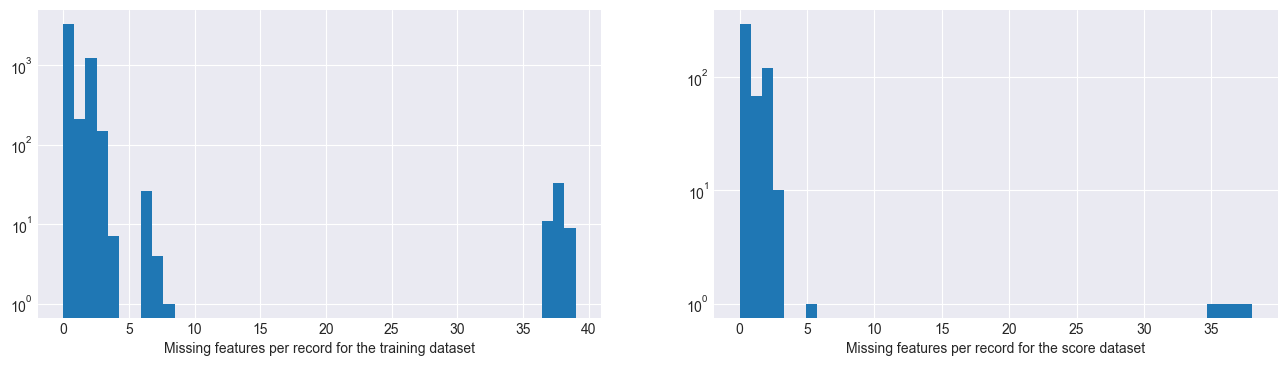

In [288]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

# -- a histogram of the amount of missing features per record
train_V2.isnull().sum(axis=1).hist(ax=axs[0], bins=46, log=True)
axs[0].set_xlabel("Missing features per record for the training dataset")

# -- a histogram of the amount of missing features per record in the score dataset 
score.isnull().sum(axis=1).hist(ax=axs[1], bins=46, log=True)
axs[1].set_xlabel("Missing features per record for the score dataset")

We clearly see, when investigating them in Excel, that for the majority of the records, the number of missing features is less than 10, however for a small amount, we have more than 35 of the features missing. It appears there are 53 such records. This is a minimal loss of data on a total of 5000 records (1.06 %) and we assume that the data collection for some unknown reason went horribly wrong. So we delete those records.

We see a similar pattern in the score data. There we have 4 instances with more than 35 missing features. 

We can either place a cut on the number of missing features per record, like so : 

```python
drop_records = train_V2[train_V2.isnull().sum(axis=1) > 35]
print(f"Number of records with > 35 missing features : {drop_records.shape[0]}")
train_V2.drop(index=drop_records.index, inplace=True)
```

or explicitly look at what features are missing. It turns out that the same features are missing in the same instances.  
For the 24 features identified in Excel and listed below was found that they were mission for all the 53 records in the train dataset and the 4 records in the score dataset. Due to the missing data we decide to drop them from the train dataset and the scoreddataset.

In [289]:
# For a number of instances (53) data seems to be missing for a lot of features (24). These instances will be eliminated from the dataset
instances_missingsData = train_V2[train_V2.loc[:,['company_ic','claims_no','income_am','gold_status','nights_booked','gender','shop_am','retired','fam_adult_size','children_no','divorce','profit_last_am','sport_ic','crd_lim_rec','credit_use_ic','gluten_ic','lactose_ic','insurance_ic','prev_all_in_stay','profit_am','bar_no','age','marketing_permit','urban_ic']].isnull().sum(axis=1) == 24]
print(instances_missingsData.shape)
train_V2 = train_V2.drop(instances_missingsData.index)

(53, 46)


In [290]:
#For a number of instances (4) in score.csv data seems to be missing for a list of features. These will be eliminated from the score set, since comparable instances were removed from the training set
# These are not withheld in the list of clients 
instances_missingsData = score[score.loc[:,['company_ic','claims_no','income_am','gold_status','nights_booked','gender','shop_am','retired','fam_adult_size','children_no','divorce','profit_last_am','sport_ic','crd_lim_rec','credit_use_ic','gluten_ic','lactose_ic','insurance_ic','prev_all_in_stay','profit_am','bar_no','age','marketing_permit','urban_ic']].isnull().sum(axis=1) == 24]
print(instances_missingsData.shape)
score = score.drop(instances_missingsData.index)

(4, 43)


In [291]:
# -- remaning records
# train_V2.shape
# number of features
print(f"Number of features train_V2 dataset after transformations so far: {len(train_V2.columns)}")
print(f"Number of features score dataset after transformations so far: {len(score.columns)}")

# number of features
print(f"Shape train_V2 dataset after transformations so far: {train_V2.shape}")
print(f"Shape score dataset after transformations so far: {score.shape}")


Number of features train_V2 dataset after transformations so far: 46
Number of features score dataset after transformations so far: 43
Shape train_V2 dataset after transformations so far: (4947, 46)
Shape score dataset after transformations so far: (496, 43)


#### Imputation of missing data

The only aspect of dealing with the missing data remaining is to impute the missing data not yet dealt with.

In [292]:
missing_rows = train_V2.isnull().sum().sort_values(ascending=False)
print("These are the features for which we still have missing values : ")
missing_rows[missing_rows>0]

These are the features for which we still have missing values : 


avg_score_pos      1544
avg_score_neg      1113
tenure_mts          339
neighbor_income     186
cab_requests         35
presidential         35
dining_ic            35
shop_use             35
dtype: int64

In [293]:
missing_feats_categorical = ['presidential', 'dining_ic', 'shop_use']
missing_feats_continuous = ['tenure_mts', 'neighbor_income', 'cab_requests', 'avg_score_pos', 'avg_score_neg']

In [294]:
missing_features = train_V2.isnull().sum(axis=1).sort_values(ascending=False)  # total missing values, sorted
print("These are the rows which contain missing features : ")
row_idx_missing = pd.DataFrame(missing_features[missing_features>0])
print(row_idx_missing.head(20))

These are the rows which contain missing features : 
      0
Id     
2504  8
863   7
7     7
2895  7
4286  7
4642  6
627   6
3167  6
3474  6
3727  6
4548  6
3606  6
4940  6
3015  6
3142  6
3845  6
3170  6
1557  6
3564  6
1566  6


Instead of separating between numerical and categorical values, we will use a **KNNImputer** to make optimal use of possible correlations between the features. **However**, as the KNN technique is sensitive to the scale of the features (it uses a distance based metric), we first have to rescale the features before being able to use a KNNImputer. Most of our features are categorical between 0 and 1, so we'll just use a MinMaxScaler between 0 and 1 to rescale to that fixed range.

In [295]:
# -- first define the min max scaler and apply to the original data
imputer_scaler = MinMaxScaler().set_output(transform="pandas")

# -- set the target features aside as we will apply the imputer to the score as well, which lacks the target features,
#    so only use the input feature for transformation & imputing
train_V2_outcome = train_V2[target_features]
train_V2_scaled = imputer_scaler.fit_transform(train_V2.drop(columns=target_features))
score_scaled = imputer_scaler.transform(score)

# -- next define the imputer having 5 neighbours (default) and uniform weights
imputer_knn = KNNImputer(n_neighbors=5, weights='uniform').set_output(transform="pandas")

# -- apply to the scaled data
train_V2_scaled = imputer_knn.fit_transform(X=train_V2_scaled)
score_scaled = imputer_knn.transform(score)

# -- and apply the inverse transform
train_V2_inv_transformed = imputer_scaler.inverse_transform(train_V2_scaled)
score_inv_transformed = imputer_scaler.inverse_transform(score_scaled) 

# -- interestingly, the set_output(transform="pandas") is not implemented yet on the inverse transform in sklearn,
#    so we will pour the numpy array into a dataframe ourselves (see:  https://github.com/scikit-learn/scikit-learn/issues/27843) 
#    here we put back the outcome variables which we set aside before we fitted the scaler transform
train_V2 = pd.concat( [ pd.DataFrame(train_V2_inv_transformed, columns=train_V2_scaled.columns).set_index(train_V2_scaled.index), train_V2_outcome ], axis=1 )
score = pd.DataFrame(score_inv_transformed, columns=score_scaled.columns).set_index(score_scaled.index)

We check whether the imputation and scaling and rescaling did not add 'new' categories to the categorical features.

In [296]:
# we print the unique values in the replaces values for the categorial features in order to 
for feat_name in missing_feats_categorical:
    print(f"Unique values in {feat_name} replaced missing")
    print(train_V2.loc[row_idx_missing.index, feat_name].unique())

Unique values in presidential replaced missing
[0. 1.]
Unique values in dining_ic replaced missing
[0.  0.2 1. ]
Unique values in shop_use replaced missing
[0.  0.2 1. ]


Ha! so we have a few little bastard slipping through, let's correct !

In [297]:
train_V2.loc[train_V2['dining_ic'] < 0.5,'dining_ic'] = 0.
train_V2.loc[train_V2['shop_use'] < 0.5,'shop_use'] = 0.

score.loc[score['dining_ic'] < 0.5,'dining_ic'] = 0.
score.loc[score['shop_use'] < 0.5,'shop_use'] = 0.

Let's know also check for the other categorical features.

In [298]:
for feat_name in categorical_input_features:
    print(f"Unique values in {feat_name} replaced missing")
    print(train_V2[feat_name].unique())

Unique values in client_segment replaced missing
[1. 2. 3. 0. 4. 5.]
Unique values in sect_empl replaced missing
[1. 0. 4. 6. 2. 3.]
Unique values in credit_use_ic replaced missing
[0. 1.]
Unique values in gluten_ic replaced missing
[0. 1.]
Unique values in lactose_ic replaced missing
[0. 1.]
Unique values in insurance_ic replaced missing
[0. 1.]
Unique values in spa_ic replaced missing
[1. 0.]
Unique values in empl_ic replaced missing
[0. 1.]
Unique values in married_cd replaced missing
[1. 0.]
Unique values in sport_ic replaced missing
[1. 0.]
Unique values in marketing_permit replaced missing
[0. 1.]
Unique values in urban_ic replaced missing
[1. 0.]
Unique values in dining_ic replaced missing
[0. 1.]
Unique values in presidential replaced missing
[0. 1.]
Unique values in prev_stay replaced missing
[1. 0.]
Unique values in prev_all_in_stay replaced missing
[1. 0.]
Unique values in divorce replaced missing
[0. 1.]
Unique values in company_ic replaced missing
[0. 1.]
Unique values in 

Clearly the scaler is the issue not the imputer, so another round of correcting.

In [299]:
train_V2.loc[train_V2['client_segment'] < 0.5,'client_segment'] = 0.
train_V2.loc[(train_V2['client_segment'] < 1.5) & (train_V2['client_segment'] >= 0.5) & (train_V2['client_segment'] != 1),'client_segment'] = 1.
train_V2.loc[(train_V2['client_segment'] < 2.5) & (train_V2['client_segment'] >= 1.5) & (train_V2['client_segment'] != 2),'client_segment'] = 2.
train_V2.loc[(train_V2['client_segment'] < 3.5) & (train_V2['client_segment'] >= 2.5) & (train_V2['client_segment'] != 3),'client_segment'] = 3.
train_V2.loc[(train_V2['client_segment'] < 4.5) & (train_V2['client_segment'] >= 3.5) & (train_V2['client_segment'] != 4),'client_segment'] = 4.
train_V2.loc[train_V2['client_segment'] >= 4.5,'client_segment'] = 1.
train_V2.loc[train_V2['sect_empl'] < 0.5,'sect_empl'] = 0.
train_V2.loc[(train_V2['sect_empl'] < 1.5) & (train_V2['sect_empl'] >= 0.5) & (train_V2['sect_empl'] == 1),'sect_empl'] = 1.
train_V2.loc[(train_V2['sect_empl'] < 2.5) & (train_V2['sect_empl'] >= 1.5) & (train_V2['sect_empl'] == 2),'sect_empl'] = 2.
train_V2.loc[(train_V2['sect_empl'] < 3.5) & (train_V2['sect_empl'] >= 2.5) & (train_V2['sect_empl'] == 3),'sect_empl'] = 3.
train_V2.loc[(train_V2['sect_empl'] < 4.5) & (train_V2['sect_empl'] >= 3.5) & (train_V2['sect_empl'] == 4),'sect_empl'] = 4.
train_V2.loc[(train_V2['sect_empl'] < 5.5) & (train_V2['sect_empl'] >= 4.5) & (train_V2['sect_empl'] == 5),'sect_empl'] = 5. #Assuming that a fifth category exists
train_V2.loc[train_V2['sect_empl'] >= 5.5,'sect_empl'] = 6.

score.loc[score['client_segment'] < 0.5,'client_segment'] = 0.
score.loc[(score['client_segment'] < 1.5) & (score['client_segment'] >= 0.5) & (score['client_segment'] != 1),'client_segment'] = 1.
score.loc[(score['client_segment'] < 2.5) & (score['client_segment'] >= 1.5) & (score['client_segment'] != 2),'client_segment'] = 2.
score.loc[(score['client_segment'] < 3.5) & (score['client_segment'] >= 2.5) & (score['client_segment'] != 3),'client_segment'] = 3.
score.loc[(score['client_segment'] < 4.5) & (score['client_segment'] >= 3.5) & (score['client_segment'] != 4),'client_segment'] = 4.
score.loc[score['client_segment'] >= 4.5,'client_segment'] = 5.
score.loc[score['sect_empl'] < 0.5,'sect_empl'] = 0.
score.loc[(score['sect_empl'] < 1.5) & (score['sect_empl'] >= 0.5) & (score['sect_empl'] == 1),'sect_empl'] = 1.
score.loc[(score['sect_empl'] < 2.5) & (score['sect_empl'] >= 1.5) & (score['sect_empl'] == 2),'sect_empl'] = 2.
score.loc[(score['sect_empl'] < 3.5) & (score['sect_empl'] >= 2.5) & (score['sect_empl'] == 3),'sect_empl'] = 3.
score.loc[(score['sect_empl'] < 4.5) & (score['sect_empl'] >= 3.5) & (score['sect_empl'] == 4),'sect_empl'] = 4.
score.loc[(score['sect_empl'] < 5.5) & (score['sect_empl'] >= 4.5) & (score['sect_empl'] == 5),'sect_empl'] = 5. #Assuming that a fifth category exists
score.loc[score['sect_empl'] >= 5.5,'sect_empl'] = 6.

In [300]:
for feat_name in categorical_input_features:
    if feat_name == 'client_segment' or feat_name == 'sect_empl':
        continue
    else:
        train_V2.loc[train_V2[feat_name] < 0.5,feat_name] = 0.
        train_V2.loc[train_V2[feat_name] >= 0.5,feat_name] = 1.
        
        score.loc[score[feat_name] < 0.5,feat_name] = 0.
        score.loc[score[feat_name] >= 0.5,feat_name] = 1.

Now finally test whether we still have missing values

In [301]:
missing_rows = train_V2.isnull().sum().sort_values(ascending=False)
print("These are the features for which we still have missing values : ")
missing_rows[missing_rows>0]


print(f"Total amount of missing values in the dataframe : {train_V2.isnull().sum().sum()}")

These are the features for which we still have missing values : 
Total amount of missing values in the dataframe : 0


In [302]:
missing_rows = score.isnull().sum().sort_values(ascending=False)
print("These are the features for which we still have missing values : ")
missing_rows[missing_rows>0]


print(f"Total amount of missing values in the dataframe : {score.isnull().sum().sum()}")

These are the features for which we still have missing values : 
Total amount of missing values in the dataframe : 0


## Anomaly and outlier detection

Now, before moving onwards, we still want to have a look for possible outliers in the data in order to decide what to do with them. Let's start with some simple visualisations like boxplots and histograms to get a feeling for the distribution of the features. 

### Univariate analysis

In [303]:
# -- for the plots
nrows = 6
ncols = 8

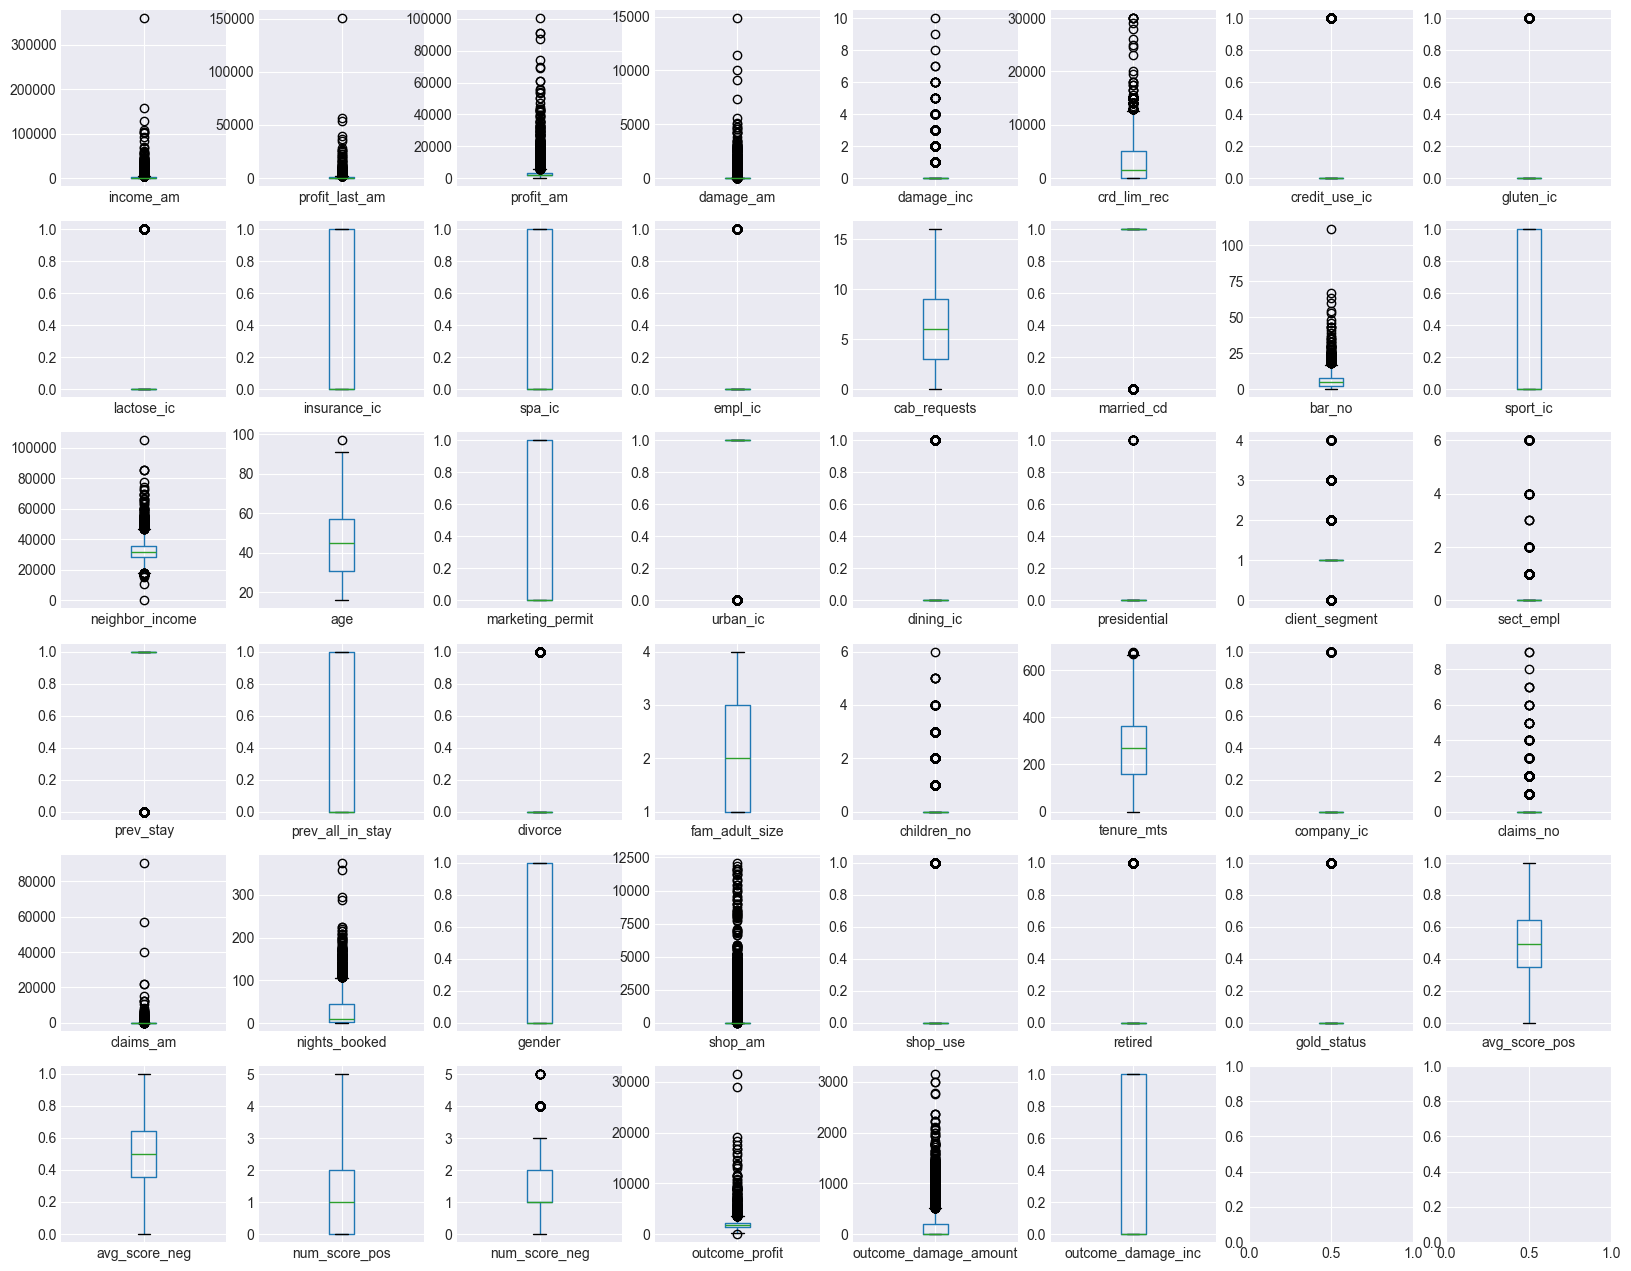

In [304]:
# -- we first make some boxplots for every feature
fig, axs = plt.subplots(nrows, ncols, figsize=(20,16))
for idx, feat_name in enumerate(train_V2.columns):
    row = idx // ncols
    col = idx % ncols
    train_V2.boxplot([feat_name], ax=axs[row][col])

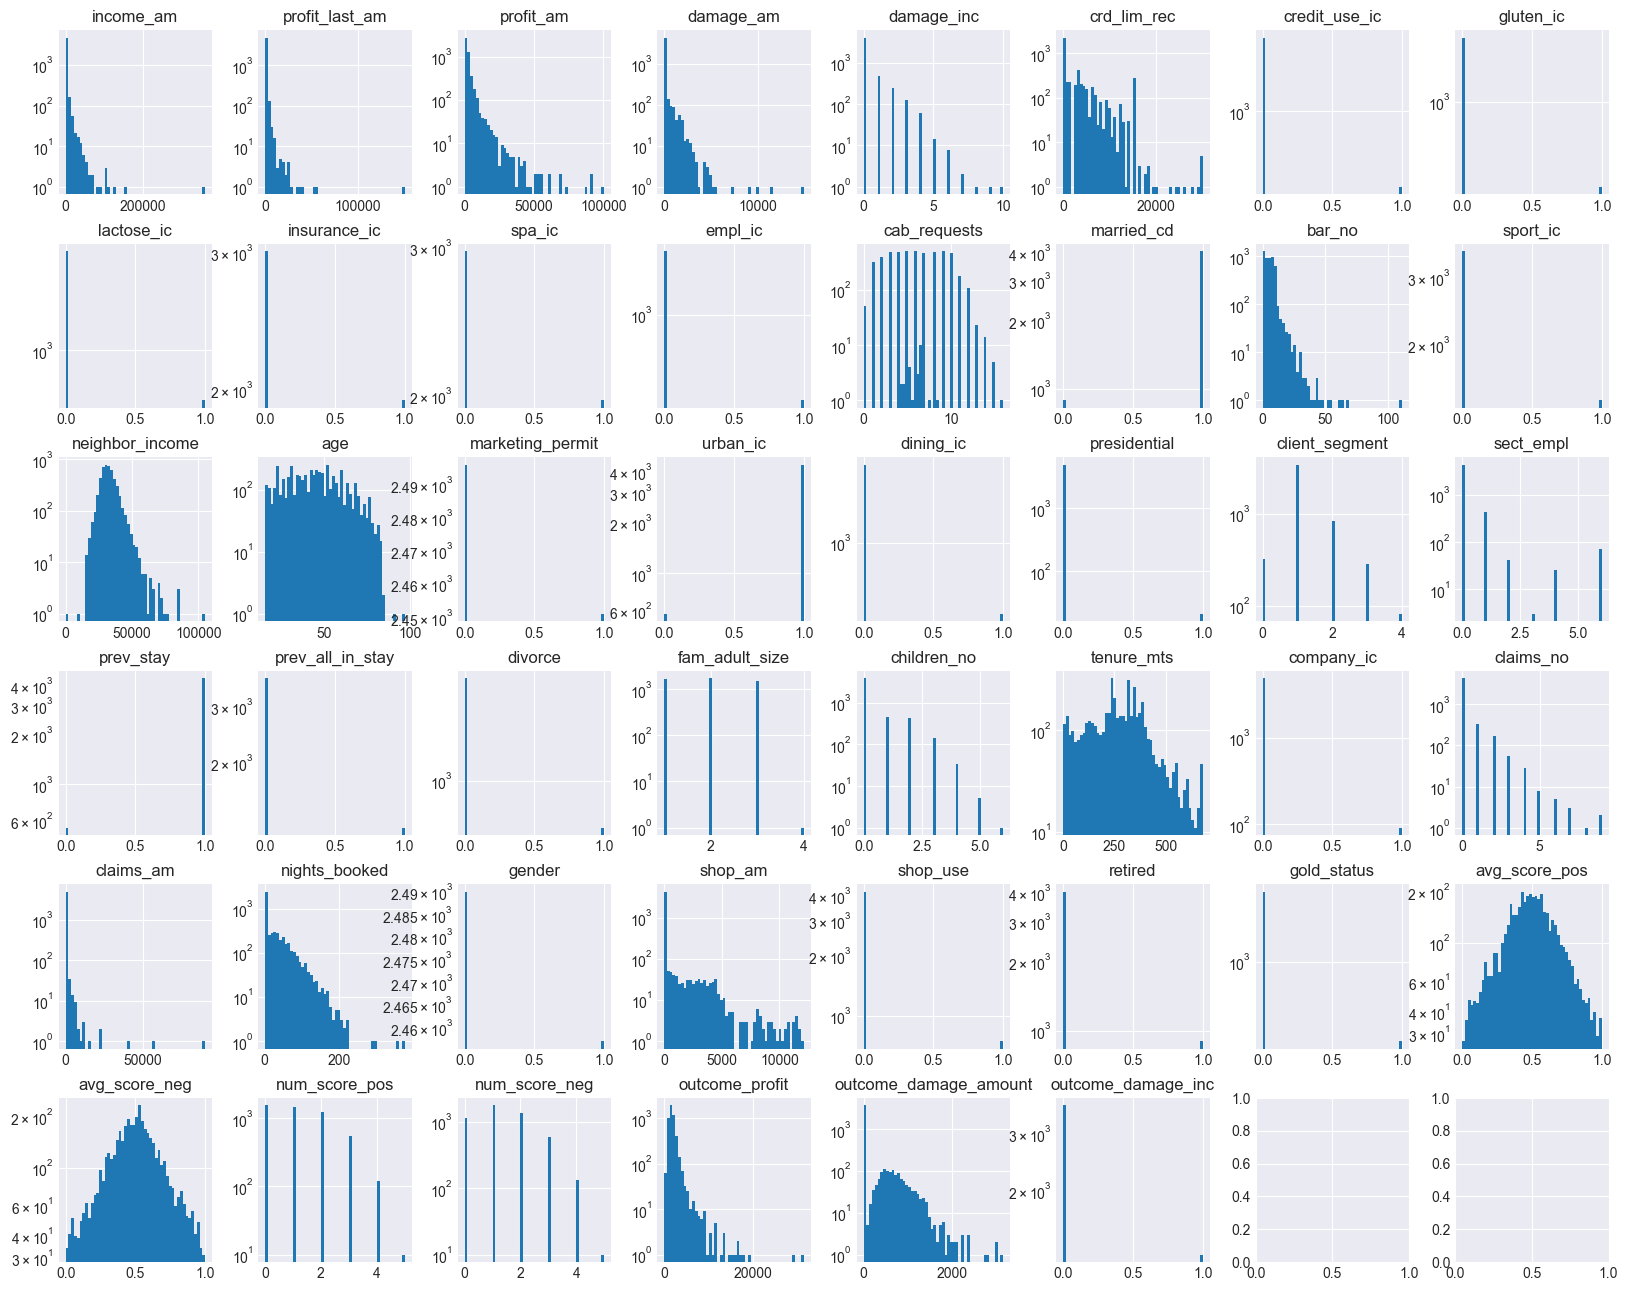

In [305]:
# -- and here we do the same with the histograms
fig, axs = plt.subplots(nrows, ncols, figsize=(20,16))
for idx, feat_name in enumerate(train_V2.columns):
    row = idx // ncols
    col = idx % ncols
    train_V2.hist(feat_name, bins=50, ax=axs[row][col], log=True)

We can already make a couple of interesting observations : 
- There (visually) seem so be some outliers present in the distributions for `income_am`, `profit_last_am`, `damage_am`, `bar_no`, `claims_am`, and `outcome_profit`
- There seem to be some records which show a total number of nights booked (`nights_booked`) at the chain of 0, we assume that these are first time guest of the hotel chain.

Let's look at a few of the outliers : 

In [306]:
train_V2[train_V2['outcome_profit'] > 25000 ]

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,avg_score_pos,avg_score_neg,num_score_pos,num_score_neg,outcome_profit,outcome_damage_amount,outcome_damage_inc
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1979,25327.0,15078.0,30156.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,7.0,1.0,2.0,0.0,50633.0,41.0,1.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,3.0,2.0,353.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.399627,0.486164,0.0,0.0,31529.0,0.0,0
3763,360577.0,150537.0,61264.0,4771.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.0,1.0,8.0,1.0,48846.0,46.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,3.0,0.0,26.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.332470,0.504499,2.0,2.0,29046.4,1288.2,1


Jumping ahead a little, we tried training the gradient boosting machine for the profit with & without these outliers. When leaving out these datapoints the R2 score for the test set did improve noticeably (from 0.80 -> 0.84 roughly), however the question still remains whether those really are outliers, and using the R2 score here is the best strategy. After all a few outliers which do not end up on the y = x line can significantly impact the R2. Also, the profit values quoted in the dataset don't seem wrong, and judging from the other features for those guests, such as income and profit_am, those really are very highly profitable guests. Finally, we decided to leave out those 2 entries based on the improvement in R2, but this could definitely be explored further. Especially in the context of predicting the damage amount which did not seem to go well.

In [307]:
train_V2.drop(1979, inplace=True)
train_V2.drop(3763, inplace=True)

In [308]:
train_V2[train_V2['income_am'] > 150000 ]

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,avg_score_pos,avg_score_neg,num_score_pos,num_score_neg,outcome_profit,outcome_damage_amount,outcome_damage_inc
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
709,157697.0,8.0,31325.0,0.0,0.0,8000.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,1.0,14.0,0.0,33188.4,45.0,1.0,1.0,0.0,0.0,3.0,0.0,1.0,1.0,0.0,2.0,0.0,242.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.378836,0.26206,3.0,3.0,11451.15,0.0,0


In [309]:
train_V2[train_V2['damage_am'] > 6000 ]

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,avg_score_pos,avg_score_neg,num_score_pos,num_score_neg,outcome_profit,outcome_damage_amount,outcome_damage_inc
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2112,5247.0,1492.0,12741.0,9136.0,7.0,28000.0,0.0,1.0,1.0,1.0,1.0,0.0,3.0,1.0,3.0,0.0,34823.0,46.0,1.0,1.0,0.0,0.0,3.0,0.0,1.0,1.0,0.0,3.0,1.0,575.0,0.0,0.0,0.0,69.0,0.0,0.0,0.0,0.0,0.0,0.026500,0.703839,1.0,1.0,2775.97,1416.26,1
2253,227.0,0.0,1620.0,11394.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,1.0,2.0,0.0,22561.0,52.0,0.0,1.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,3.0,0.0,358.0,0.0,0.0,0.0,224.0,1.0,0.0,0.0,0.0,0.0,0.326955,0.416902,0.0,0.0,2080.49,733.00,1
2718,227.0,0.0,4808.0,7321.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,4.0,1.0,28983.0,25.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,238.0,0.0,0.0,0.0,30.0,1.0,0.0,0.0,0.0,0.0,0.623210,0.522044,0.0,0.0,1353.37,0.00,0
3931,4647.0,1725.0,13871.0,10025.0,9.0,14000.0,1.0,0.0,0.0,1.0,1.0,0.0,13.0,1.0,10.0,0.0,51673.0,35.0,1.0,1.0,0.0,0.0,4.0,6.0,1.0,1.0,0.0,3.0,2.0,308.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.312075,0.820847,3.0,3.0,9125.84,1538.22,1
4768,53682.0,61.0,29712.0,14866.0,3.0,30000.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0,1.0,5.0,0.0,34334.0,36.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,3.0,0.0,359.0,0.0,0.0,0.0,44.0,0.0,0.0,0.0,0.0,0.0,0.257344,0.746133,1.0,1.0,2071.03,1046.63,1


In [310]:
train_V2[train_V2['bar_no'] > 100 ]

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,avg_score_pos,avg_score_neg,num_score_pos,num_score_neg,outcome_profit,outcome_damage_amount,outcome_damage_inc
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2512,2341.0,0.0,4922.0,0.0,0.0,3000.0,0.0,0.0,0.0,1.0,0.0,0.0,12.0,0.0,111.0,0.0,39147.0,51.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,2.0,1.0,26.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.569805,0.473527,0.0,0.0,1970.7,452.61,1


In [311]:
train_V2[train_V2['claims_am'] > 30000 ]

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,avg_score_pos,avg_score_neg,num_score_pos,num_score_neg,outcome_profit,outcome_damage_amount,outcome_damage_inc
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
818,16991.0,0.0,27679.0,0.0,0.0,12000.0,0.0,0.0,1.0,1.0,1.0,0.0,6.0,1.0,16.0,0.0,26044.0,59.0,1.0,1.0,1.0,0.0,3.0,0.0,0.0,1.0,0.0,1.0,0.0,122.0,0.0,1.0,90587.0,83.0,0.0,0.0,0.0,1.0,0.0,0.456201,0.440444,0.0,0.0,1726.72,829.63,1
2530,227.0,0.0,1620.0,0.0,0.0,11000.0,0.0,0.0,0.0,1.0,0.0,1.0,8.0,1.0,2.0,1.0,29817.0,43.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,1.0,216.0,0.0,2.0,57222.0,102.0,1.0,0.0,0.0,0.0,0.0,0.641449,0.951726,1.0,1.0,1312.66,0.00,0
4550,286.0,0.0,2959.0,628.0,3.0,2500.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,4.0,1.0,34841.0,39.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,324.0,0.0,1.0,40265.0,51.0,0.0,0.0,0.0,0.0,0.0,0.821716,0.902322,2.0,2.0,1587.44,0.00,0


So there seems to be a fairly rich person in the dataset with very high income (>200000), but also high profit_last_am which seems to be in client segment 5 (a higher segment seems correlated with income (not shown)), so which probably makes sense. We don't think this should necessarily be considered as an outlier.

For none of the remaining potential outliers we assessed them as being unrealistic or containing obvious errors. We also did not find that they significantly impacted the R2 of test set like with the thow outliers that where previously dropped, so we decided to keep the others.


### Multivariate analysis

For the isolation forest we used data from the training set and from the scoring set. In this way we wish to prevent that conclusions are drawn on the training set which do not apply for the scoring set.

The output of an Isolation Forest model typically includes the anomaly score for each data point. The anomaly score is a measure of how different or isolated a data point is compared to the rest of the data.

According to the isolationForest more than 10% of the data is an outlier (-1 in the frequency table). We believe that this percentage is to high looking at the data.
Therefore we believe that this confirms the conclusion from the univariate analysis, nl. that there are no outliers.
However whether or not to include specific outliers in training the GBM indicated that excluding 2 outliers improved peformance considerably.

In [312]:
# Can not handle missing values
# Fitting default isolation forest for anomaly/outlier detection

# Initializing model
if_model = IsolationForest(n_estimators=100, random_state=seed)

# Fitting (only X data, because unsupervised)
X_train_V2 = train_V2.drop(columns=['outcome_profit','outcome_damage_inc','outcome_damage_amount'], inplace=False)
X_alldata = pd.concat([X_train_V2,score])

if_model.fit(X=X_train_V2)

# Predicting on the same data
y_pred_train = if_model.predict(X=X_train_V2)

# Checking frequency table of predicted values
print('Frequency table of predicted values:')
pd.Series(y_pred_train).value_counts(normalize=True)

Frequency table of predicted values:


 1    0.885945
-1    0.114055
Name: proportion, dtype: float64

# Visualisations and exploratory analysis

Now that we have reasonably clean data, let's perform some initial exploratory analysis, correlation plots, etc...

First we will look at whether there is an imbalance in the categorical data.

In [313]:
p = len(train_V2[train_V2['outcome_damage_inc'] == 1])/len(train_V2) * 100
print('The percentage of hotel guests causing damage is {:.2f}'.format(p))      

The percentage of hotel guests causing damage is 25.56


While a 25% split between classes may not be considered highly imbalanced, it could still lead to potential challenges, especially if the classes are not well-represented. It's important to assess the impact of this class distribution on your specific task and consider techniques like oversampling, undersampling, or using different evaluation metrics to address any imbalance issues.

For the following visualisation it is also usefull to make the outcome 'revenue' also available in the dataframe. 

In [314]:
# -- first we make the revenue per client available in the dataframe
train_V2['outcome_revenue'] = train_V2['outcome_profit'] - train_V2['outcome_damage_amount']
 
# -- be careful also to include it in the target_features as we want to avoid using it for training
target_features.append('outcome_revenue')

We follow this up with a correlation matrix.

<Axes: >

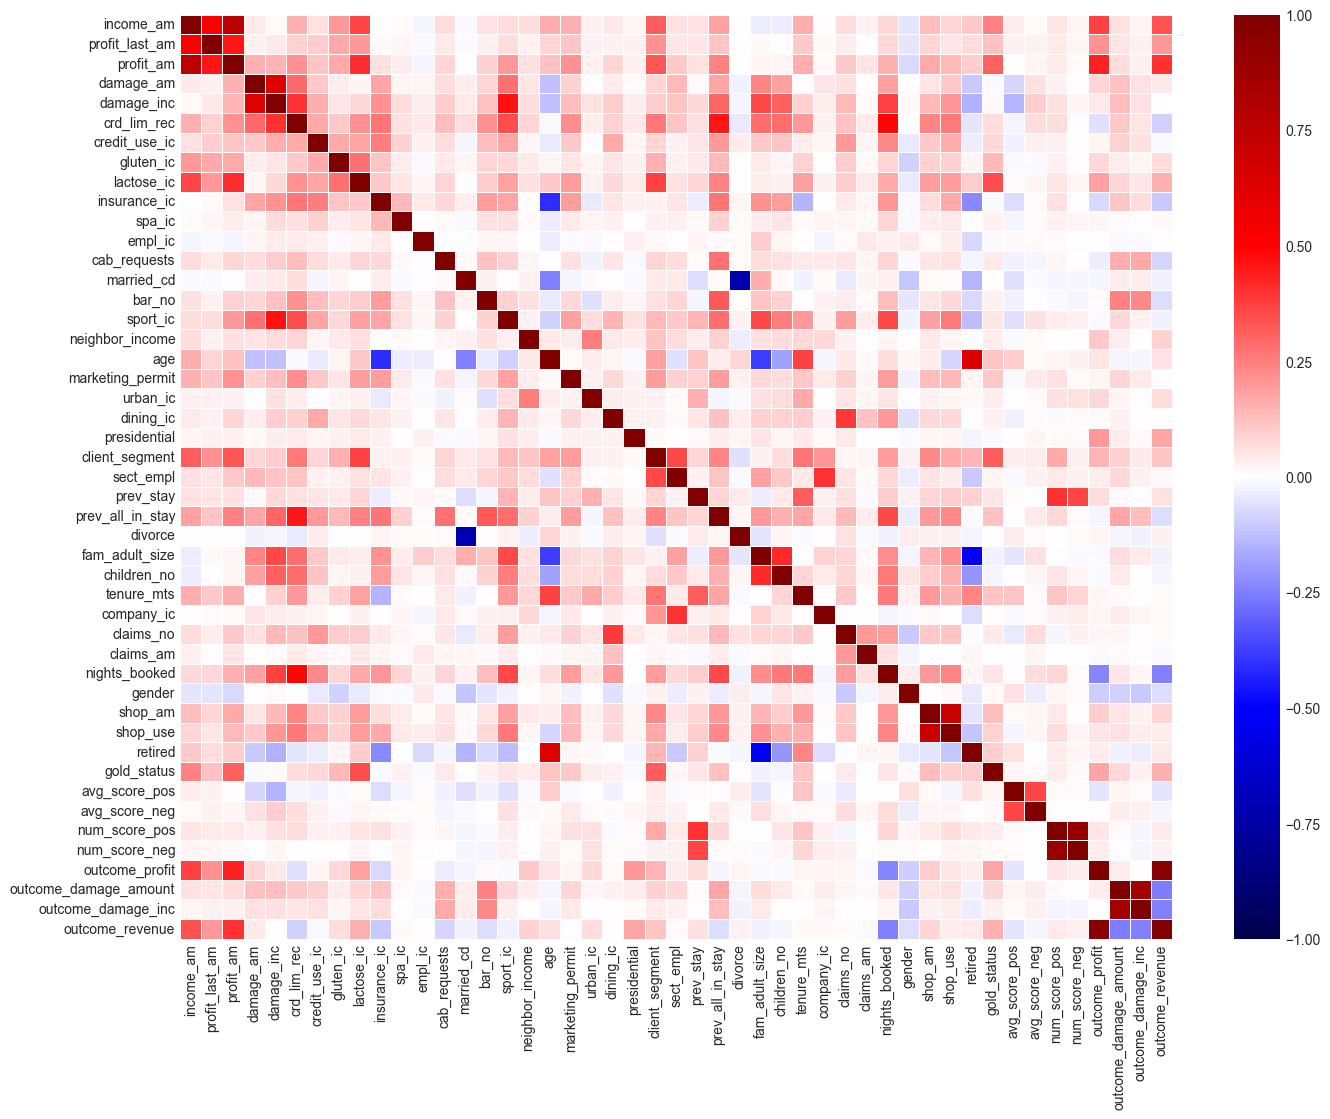

In [315]:
# -- this plots the correlation matrix
#    we adjusted the scale and colors a little to make the positive or negative correlations stand out, using the seismic colormap for this
corrmat = train_V2.corr(numeric_only=True)
plt.figure(figsize=(16, 12))
sns.heatmap(corrmat, vmin=-1, vmax=1, center=0, cmap="seismic",  linewidth=.5)

There are some interesting observations to be made here, most of them however are somewhat logical:
- the `outcome_profit` seems to be correlated with the `income_am`, `profit_last_am` and `profit_am`, so income & previous profit is indicative for how profitable a guest will be, which seems logical. Also `presidential` and the `client_segment` seem to be correlated. The negative correlation with `gender` is due to the fact that we labelled males as 0, so males seem to be more profitable. Interestingly, there is a negative correlation with `nights_booked`, so shorter stays seem to be more profitable ? Not sure if there is a good explanation for that.
- The `outcome_damage_amount` is mostly correlated with the number of `cab_requests` and bar visits `bar_no`, again which is probably logical. ALso, males seem to be the most rowdy.
- The `outcome_revenue` largely follows the same correlations as the `outcome_profit`, but with the difference that the revenue is negatively correlated with `bar_no` and `cab_requests`. 

Besides those observations, we can observe some quite logical correlations between the features themselves related to age, marriage status, retireme,t, number of children etc... we won't spend time analysing those further. 

We can make some scatterplots here, but to not overload this notebook, we will only look at revenue and a selection of interesting variables from the discussion above:

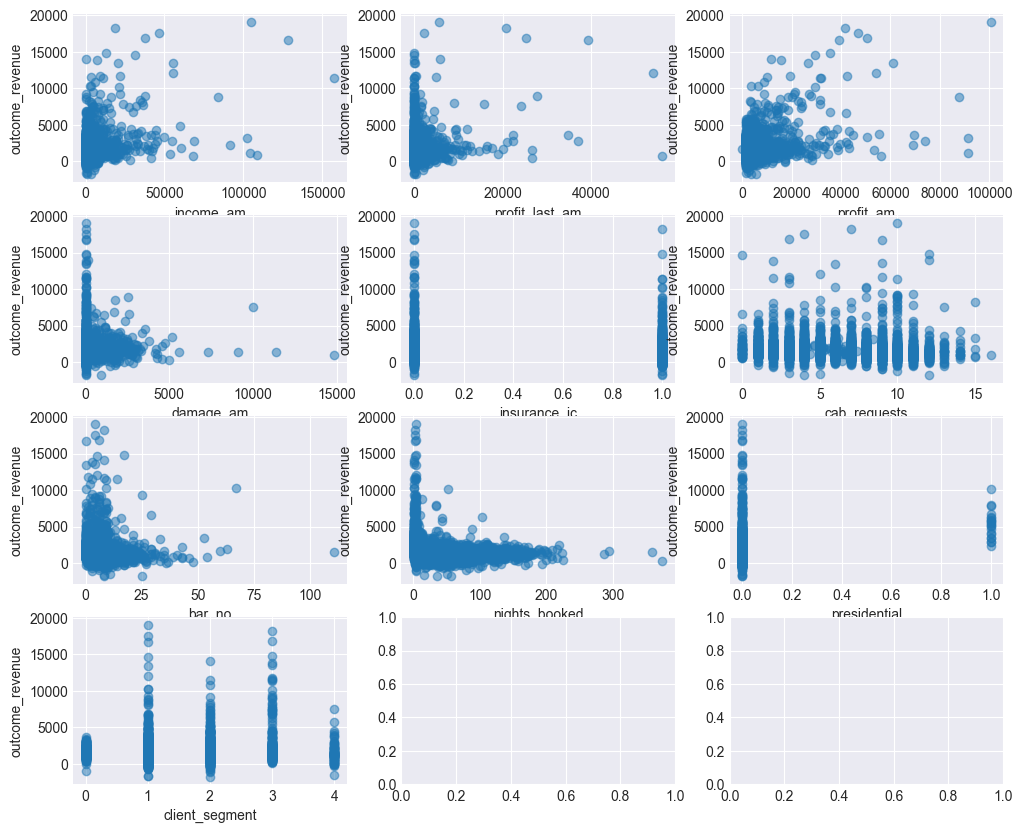

In [316]:
plot_cols = ['income_am', 'profit_last_am', 'profit_am', 'damage_am', 'insurance_ic', 'cab_requests', 'bar_no', 'nights_booked', 'presidential', 'client_segment']
fig, axs = plt.subplots(4,3, figsize=(12,10))
for i, v in enumerate(plot_cols):
    axs[i//3][i%3].plot(train_V2[v], train_V2['outcome_revenue'], 'o', alpha=0.5)
    axs[i//3][i%3].set_ylabel("outcome_revenue")
    axs[i//3][i%3].set_xlabel(v)


Ha, we can indeed see that `nights_booked` is somewhat positively correlated when more nights are booked, but in the correlation plot this was probably masked with the values near 0 `nights_booked`. Anyway, let's leave it at that and start looking at model training.

# Model training

For the model training, we each have tried and experimented with a different technique before consolidating the results back together for the final prediction. One important consideration is that the goal of all the predictions that we need to make is in fact to calculate the total revenue, being profit - damage, available as `outcome_profit - outome_damage_amount`. To be able to do this calculation we need to predict the following elements: 

1. the profit for each client
    - outcome_profit
2. predict which clients will cause damage
    - outcome_damage_inc
3. predict the amount of damage fot those who will cause damage / wreak havoc
    - outcome_damage_amount

So different strategies are possible, train a model on profit and damage separately and subtract the model predictions, or directly train on the revenue. We will discuss this in due time as this will depend on the quality of the trained models. Also for the classification problem we will see that different strategies in terms of optimisation are reasonable. Let's dive into it. 

First we start by making the outcome revenue also available in the dataframe

In [317]:
# -- furthermore, save the prepared dataset to disk...
train_V2.to_csv(os.path.join( "output", "train_v2_prep_without_outliers.csv") )
score.to_csv(os.path.join( "output", "score_prep_without_outliers.csv") )

## Some configuration

We start with providing the paths to where previously ran models can be loaded from disk.

In [318]:
# -- if the model scans exist on disk, they will be loaded, otherwise re-fitted, unless the parameter below is True
overwrite_model_training = True 
overwrite_RF_model_training = False
overwrite_SVM_model_training = False
overwrite_GBM_model_training = True


# -- filenames for the random forest scans 
rf_profit_scan_filename = os.path.join( 'models', 'rf_profit_random_search.pkl')
rf_damage_scan_filename = os.path.join( 'models', 'rf_damage_random_search.pkl')
rf_revenue_scan_filename = os.path.join( 'models', 'rf_revenue_random_search.pkl')

# -- filenames for the gradient booster scans
gbm_profit_scan_filename = os.path.join( 'models', 'gbm_profit_random_search.pkl')
gbm_damage_scan_filename = os.path.join( 'models', 'gbm_damage_random_search.pkl')
gbm_revenue_scan_filename = os.path.join( 'models', 'gbm_revenue_random_search.pkl')

# -- filenames for the Support Vector Machine scans
SVreg_profit_scan_filename = os.path.join( 'models', 'SVreg_profit_random_search.pkl')
SVreg_damage_scan_filename = os.path.join( 'models', 'SVreg_damage_random_search.pkl')

# -- classification
rfc_damage_scan_filename = os.path.join( 'models', 'rfc_damage_random_search.pkl')
gbmc_damage_scan_filename = os.path.join( 'models', 'gbmc_damage_random_search.pkl')
svc_damage_scan_filename = os.path.join( 'models', 'svc_damage_random_search.pkl')

The second configuration step is to prepare the train/test splits that will be used for the model training. We first set up a train/test split for the tree based models and after this we set up a second train/test split for the linear and SVM models because those also need standardization/scaling of their feature.

A train split of 20% is chosen to balance between having enough data to train the model effectively and having a sufficient amount of data to evaluate its performance.
  With a larger training set (80%), the model can learn more patterns and relationships in the data, potentially leading to better performance.
  On the other hand, a smaller test set (20%) allows for a more robust evaluation of the model's generalization capabilities.

In [319]:
# Making train-test set split and selecting target = outcome_profit

X_train, X_test, y_train, y_test = train_test_split(train_V2.drop(target_features, axis=1), # features DF
                                                    train_V2['outcome_profit'],   # target DF/series
                                                    test_size=0.2, 
                                                    shuffle=True,  
                                                    random_state=seed) 

Most of the categorical features are expressed as a boolean but there are two non-boolean categorical features, 'client_segment' and 'sect_empl'. Because some models, particular linear models are at risk of reading those wrong, we decided, to be on the safe side, we will OneHotEncode them using the Sklearn OneHotEncoder for those models. So before we apply the scaler, we first apply the encoder.

In [320]:
# initializing the encoder
onehot = OneHotEncoder(sparse_output=False).set_output(transform='pandas')

# fitting the encoder
onehot.fit(train_V2[['client_segment', 'sect_empl']])

# applying the encoder
Onehotencoded = onehot.transform(train_V2[['client_segment', 'sect_empl']])
train_V2_onehot = train_V2.merge(Onehotencoded, left_index=True, right_index=True)
train_V2_onehot = train_V2_onehot.drop(['client_segment', 'sect_empl'], axis = 1)

For standardizing we just use the standard Sklearn scaler as it is configured out of the box.

In [321]:
scaler = StandardScaler().set_output(transform='pandas')
train_v2_stan_df = scaler.fit_transform(X=train_V2_onehot)

In [322]:
X_train_stan, X_test_stan, y_train_stan, y_test_stan = train_test_split(train_v2_stan_df.drop(target_features, axis=1), # features DF
                                                    train_v2_stan_df['outcome_profit'],   # target DF/series
                                                    test_size=0.2, 
                                                    shuffle=True,  
                                                    random_state=seed) 

## Model for predicting the outcome_profit

The final goal that we need to predict is the revenue per client (= profit - damage). We could fit the revenue by fitting the profit and by fitting the damage and subtracting them. Or we could calculate the revenue in the training set and fit the revenue directly.

When you need to predict a difference, you would typically predict each term individually and then calculate the difference between the predicted values. By predicting each term separately, you can estimate the values of the components involved in the difference and then determine the overall difference based on these predictions. This approach helps in forecasting the outcome of the difference by considering the predicted values of its individual components.

Below we have looked at the R2 result for an RF-model on the revenue and an RF-model on the profit.

### Linear model

We start with a simple out of the box linear model, to provide a baseline to which can compare the more complex models.
Because we are predicting a continuous value we use linear regression and use the scaled train-test split as input.

In [323]:
# Initializing the model
reg_profit = linear_model.LinearRegression()

# Fitting with the scaled data
reg_profit.fit(X_train_stan, y_train_stan)

LinearRegression()

In [324]:
# Training score (R2)
reg_profit.score(X_train_stan, y_train_stan)

0.33685606476381313

In [325]:
# Test score (R2)
reg_profit.score(X_test_stan, y_test_stan)

0.40447233699815976

Mmmh, that is weird, the model has a better R2 for the test dataset than the train dataset.  Let's change the seed a couple of times for the train test-split to get an idea how stable this is.

In [326]:
seeds = [int(x) for x in np.arange(1, 100, step=10)]
score_train = []
score_test = []

for number in seeds:
    X_train_stan_l, X_test_stan_l, y_train_stan_l, y_test_stan_l = train_test_split(train_v2_stan_df.drop(target_features, axis=1), # features DF
                                                    train_v2_stan_df['outcome_profit'],   # target DF/series
                                                    test_size=0.2, 
                                                    shuffle=True,  
                                                    random_state=number) 
    reg_profit.fit(X_train_stan_l, y_train_stan_l)
    score_train.append(reg_profit.score(X_train_stan_l, y_train_stan_l))
    score_test.append(reg_profit.score(X_test_stan_l, y_test_stan_l))
    
reg_profit_score = pd.DataFrame({'Train_score': score_train, 'Test_score': score_test})

In [327]:
# calculate the mean for the scores
reg_profit_score.mean(axis= 0)

Train_score    0.377982
Test_score     0.321038
dtype: float64

In [328]:
# calculate the standard deviation for the scores
reg_profit_score.std(axis= 0)

Train_score    0.018415
Test_score     0.079120
dtype: float64

As expected it was and exceptional situation. So now we have a baseline R2 for both this seed and also a more general situation. 

### Random Forest Regression

The first complex model we try using is random forest regression. Since we are applying a tree based method, we use the train/test split without onehot encoding and standardization. 

In [329]:
# Defining candidate grid to sample from (RandomizedSearchCV will sample from it)
n_estimators = [int(x) for x in np.linspace(start=150, stop=300, num=6)]  # list comprehension because we want integers!
max_depth = [int(x) for x in np.linspace(start=5, stop=85, num=8)]
max_depth.append(None)  # adding 'None' option as well
max_features = [0.7, 0.8, 0.9, 0.98]
min_samples_split = [4, 5, 6, 8]
min_samples_leaf = [2, 3, 4,6]
bootstrap = [True]
hyperparam_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}

if os.path.exists(rf_profit_scan_filename) and not overwrite_RF_model_training:
    # -- re-load the scan from disc
    print(f"Re-loading the scan from {rf_profit_scan_filename}")
    rf_profit_hyperparam_tuning_random = joblib.load(rf_profit_scan_filename)

else:    
    # Define data splitter to be used in the search
    n_folds = 5
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)

    # Define amount of hyperparameter tuning combinations to sample
    n_hyperparams_sample = 100

    # Defining model to apply random search CV hyperparam tuning on
    # outcome_profit is continuous, therefore a regressor needs to be applied
    rfr = RandomForestRegressor()

    # Initializing random search CV object
    rf_profit_hyperparam_tuning_random = RandomizedSearchCV(estimator=rfr, 
                                            param_distributions=hyperparam_grid, 
                                            n_iter=n_hyperparams_sample, 
                                            cv=kfold,
                                            verbose=2, 
                                            random_state=seed, 
                                            n_jobs=-1)

    # Fit the random search by sampling hyperparameters from our grid, then fitting each model for each CV fold, aggregating results
    rf_profit_hyperparam_tuning_random.fit(X=X_train, y=y_train)

    # -- write the scan to file
    joblib.dump(
        value=rf_profit_hyperparam_tuning_random, 
        filename=rf_profit_scan_filename)
    
    print(f"Saved scan result to : {rf_profit_scan_filename}")

Re-loading the scan from models\rf_profit_random_search.pkl


c:\JAVA\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.5.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\JAVA\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.5.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\JAVA\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomizedSearchCV from version

In [330]:
print('Optimally found RF hyperparams after this random search: \n{}' .format(rf_profit_hyperparam_tuning_random.best_params_))

# Refitting the optimal model on the whole training dataset
rf_profit_best = rf_profit_hyperparam_tuning_random.best_estimator_
rf_profit_best.fit(X=X_train, y=y_train)

# Getting predictions on train and test set
rf_profit_best_y_train_pred = rf_profit_best.predict(X=X_train)
rf_profit_best_y_test_pred = rf_profit_best.predict(X=X_test)

# Checking the score: R2 manually
print('Train R2: %.3f' % rf_profit_best.score(X=X_train, y=y_train))
print('Test R2: %.3f' % rf_profit_best.score(X=X_test, y=y_test))


Optimally found RF hyperparams after this random search: 
{'n_estimators': 240, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 0.98, 'max_depth': 27, 'bootstrap': True}
Train R2: 0.947
Test R2: 0.801


Note that for the model to predict profit we also tried an experimental randomized grid search (HalvingRandomSearch). The randomized grid search performed almost as good and run a lot faster (20s tov 2m30s). This was not consolidated in this notebook. 

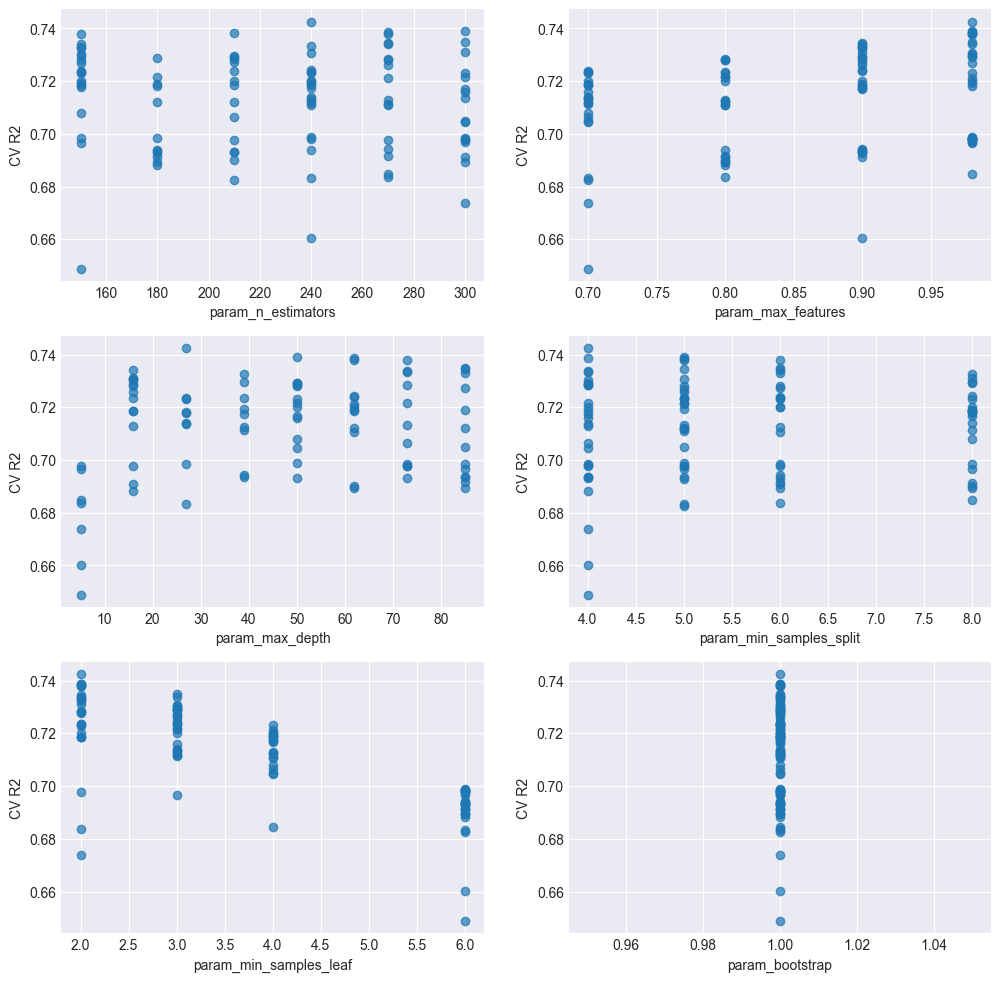

In [331]:
# Visualise the results of the scan
rf_cv_res = pd.DataFrame(rf_profit_hyperparam_tuning_random.cv_results_)

num_keys = len(hyperparam_grid.keys())
fig, axs = plt.subplots(num_keys // 2 + num_keys % 2, 2, figsize=(12,12))
for i, param in enumerate([ f"param_{key}" for key in hyperparam_grid.keys()]):  
    axs[i//2][i%2].scatter(x=rf_cv_res[param], y=rf_cv_res['mean_test_score'], alpha=0.7)
    axs[i//2][i%2].set_xlabel(param)
    axs[i//2][i%2].set_ylabel('CV R2')

From these plots we see that not all params in the RanomizedGridSearch seem to have an impact on the performance of the RandomForestRegressor.  
However performances gets better for trees with a higher depth .The model also shows better performance for a higher percentage for max_feature and lower min_samples_leaf. 


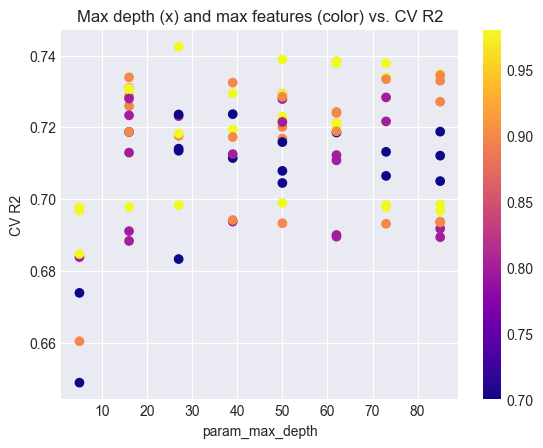

In [332]:
# Plotting hyperparameter vs. performance: more complex plots for the parameters showing some impact
plt.scatter(x=rf_cv_res['param_max_depth'], 
            y=rf_cv_res['mean_test_score'], 
            c=rf_cv_res['param_max_features'], # c argument allows to color according to param_n_estimators
            cmap='plasma');  # This makes the color non-dull
plt.colorbar();  # adds the bar on the right
plt.xlabel('param_max_depth');
plt.ylabel('CV R2');
plt.title('Max depth (x) and max features (color) vs. CV R2');

### Gradient Boost Machine Regression

Below we play around manually with the GradientBoostingRegressor parameters. We first played around a bit manually with the hyperparameters. It was noticed that
- including a limit to the `max_leaf_nodes` does increase test R2, so will include this in hyperparam search.
- we have to choose the `n_estimators` (# boosting stages) fairly large it seems, while still keeping learning rate to relatively high value, strange, will optimize further in the hyperparam search.

Below is the set we converged upon via manual optimization. Since we are agian applying a tree based method, we use the train/test split without onehot encoding and standardization.

In [333]:
gbm_params = {
    'n_estimators': 600,  # number of boosting stages to perform
    'subsample': 1.0,     # 1.0 leads to reduction in variance and increase in bias
    'max_depth': 3,       # limiting the max depth to the default of 3 seems to improve the test R2
    'min_samples_split': 2, # default
    'min_samples_leaf': 1,  # default
    'max_leaf_nodes': 8, # limiting the max number of leaf nodes does increase performance !! improvement of test R2 vs using None
    'learning_rate': 0.1, # default
    'ccp_alpha': 0.0}  # default is 0.0

gbm_profit = GradientBoostingRegressor(loss='squared_error', random_state=seed, **gbm_params) 
gbm_profit.fit(X=X_train, y=y_train) 

# Step 4 - Getting predictions
gbm_preds = gbm_profit.predict(X=X_test)
gbm_preds_train = gbm_profit.predict(X=X_train)

test_R2 = gbm_profit.score(X=X_test, y=y_test)
train_R2 = gbm_profit.score(X=X_train, y=y_train)

# Print R2 results
print(f'Train R2: {train_R2:.3}')
print(f'Test R2: {test_R2:.3}')

Train R2: 0.936
Test R2: 0.846


We noticed a few things : 
- leaving out the 2 outliers in the `outcome_profit` of > 25000 results in a significant increase in Test R2 (0.85 vs. 0.81), so perhaps it is better to leave those values out of the training as it is not certain how representave they are for the final scoring dataset. We can revisit this argument after the hyperparameter scan. 
- we also tried log-transforming the `outcome_profit` feature before fitting (`np.log(1+train_V2["outcome_profit"])`) in order to test whether this would give any improvement, given the fairly skew distribution of the `outcome_profit`values. This resulting in drastically lower test R2 (and also train R2) of 0.65 and 0.86 respectively, so we will not apply any log-transformation here. 
- trying a more outlier robust loss function such as Hubers loss (`huber`) did not improve the estimation (Train R2: 0.922 instread of 0.936, and Test R2: 0.820 instead of 0.846 using a `square_error`loss function

(0.0, 25000.0)

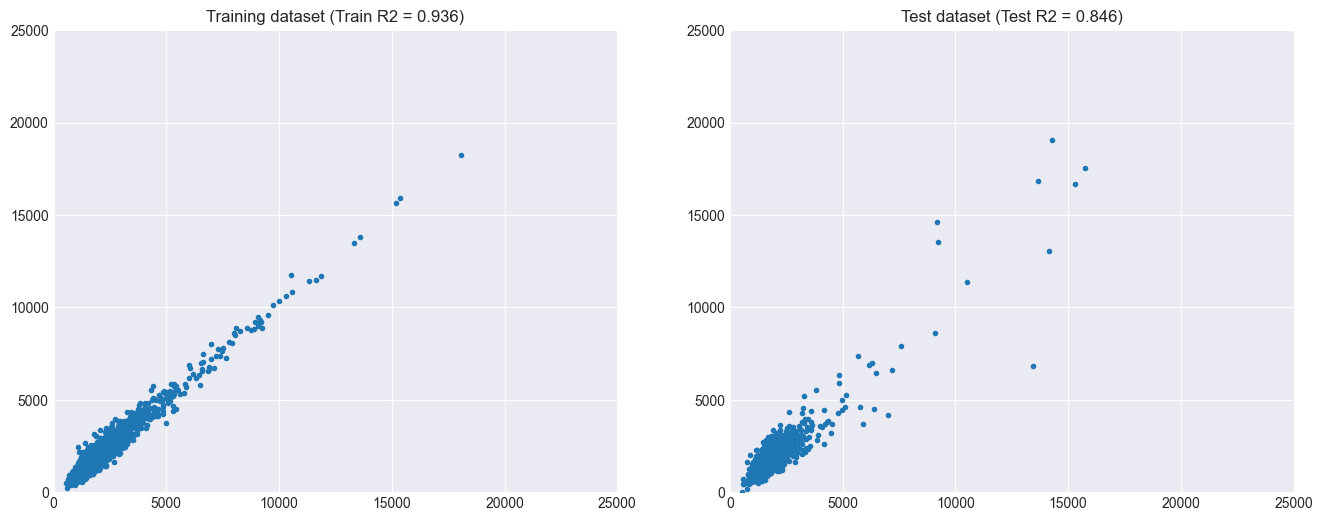

In [334]:
# -- let's make a quick plot of the results for the training & test dataset
axis_range = [0, 25000]
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].plot(gbm_preds_train, y_train, '.')
axs[0].set_title(f"Training dataset (Train R2 = {train_R2:.3})")
axs[0].set_ylim(axis_range)
axs[0].set_xlim(axis_range)

axs[1].plot(gbm_preds, y_test, '.')
axs[1].set_title(f"Test dataset (Test R2 = {test_R2:.3})")
axs[1].set_ylim(axis_range)
axs[1].set_xlim(axis_range)

Let's now try to optimise the manually tweaked hyperparameter further in an automated way using a RandomisedSearchCV, configure below whether you want to load or rescan the final best estimator. 

In [335]:
# -- first chooe how many hyperparameters to randomly sample
n_hyperparam_sample = 200

# -- build the search grid
random_grid = {
    'n_estimators': [ int(x) for x in np.linspace(start=200, stop=1000, num=9)],
    'max_depth': [int(x) for x in np.linspace(1, 10, num=10)],
    'min_samples_split': [2, 5, 10, 30],
    'min_samples_leaf': [1, 2, 4, 10, 30],
    'max_leaf_nodes': [int(x) for x in np.linspace(2, 20, num=19)],
    'learning_rate': [0.01, 0.02, 0.05, 0.08, 0.1],
    }

if os.path.exists(gbm_profit_scan_filename) and not overwrite_GBM_model_training:
    print(f"Re-loading random search from {gbm_profit_scan_filename}")
    gbm_profit_hyperparam_tuning_random = joblib.load(gbm_profit_scan_filename)

else:
    # max_features':  [0.1, 0.3, 0.5, 0.7, 0.9] # not using this one... best leave at default !
    # subsample': [0.4, 0.6, 0.8, 1],

    # Random search of parameters, using 3 fold cross validation, across 500 different hyperparameter combinations, and use all available cores
    gbm_profit_hyperparam_tuning_random = RandomizedSearchCV(estimator=GradientBoostingRegressor(), 
                                                    param_distributions=random_grid, 
                                                    n_iter=n_hyperparam_sample,   # Amount of hyperparameter values to sample
                                                    cv=KFold(n_splits=5, shuffle=True, random_state=seed), # setting the shuffle to True here ... 
                                                    verbose=2, # to print some outputs
                                                    random_state=seed, 
                                                    n_jobs=-1)

    # Fit the random search by sampling hyperparameters from our grid, then fitting each model for each CV fold, aggregating results
    gbm_profit_hyperparam_tuning_random.fit(X=X_train, y=y_train)

    # Now you can access the fitted object, e.g. get best_params_
    print(f"Optimally found GBM hyperparams after this random search: {gbm_profit_hyperparam_tuning_random.best_params_}")

    # -- and write out
    joblib.dump(value=gbm_profit_hyperparam_tuning_random, 
                filename=gbm_profit_scan_filename)

    print(f"Written : {gbm_profit_scan_filename}")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Optimally found GBM hyperparams after this random search: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_leaf_nodes': 9, 'max_depth': 4, 'learning_rate': 0.08}
Written : models\gbm_profit_random_search.pkl


In [336]:
print('Optimally found GBM hyperparams after this random search: \n{}' .format(gbm_profit_hyperparam_tuning_random.best_params_))

# -- Refitting final optimal GBM on all training data
gbm_profit_opt_final = gbm_profit_hyperparam_tuning_random.best_estimator_
gbm_profit_opt_final.fit(X=X_train, y=y_train)

# -- Performances
print('Train R2: %.3f' % gbm_profit_opt_final.score(X=X_train, y=y_train))
print('Test R2: %.3f' % gbm_profit_opt_final.score(X=X_test, y=y_test))

Optimally found GBM hyperparams after this random search: 
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_leaf_nodes': 9, 'max_depth': 4, 'learning_rate': 0.08}
Train R2: 0.895
Test R2: 0.832


Let's compare : 

| parameter | manual | randomsearchCV |
| ----------| ------ |---------------|
| n_estimators | 600 | 200 |
| min_samples_split | 2 | 10 |
| min_samples_leaf | 1 | 4 |
| max_leaf_nodes | 8 | 9 |
| max_depth | 3 | 4 |
| learning_rate | 0.1 | 0.08 |

Interestingly we find slightly lower performance than our manual scan. Probably some randomness is involved here and we could play with the test/train split (e.g. going for  15% test, but that is probably too low). Let's look at the learning curve for both approaches to be sure. But it is striking. The optimum in the scan seems to end up at much less boosting stages (200 instead of 600), as well as at lot more `min_samples_split`and `min_samples_leaf`, all of which cause increased bias and reduce variance, apart from the `max_depth`. So the optimised version of the gbm will probably generalise better since judging from the parameters, it should have less variance, but still yield a rather good result. We will choose the optimal model from the scan as the final model then. 



In [337]:
gbm_profit_cv_results = pd.DataFrame(gbm_profit_hyperparam_tuning_random.cv_results_)

Here we make a plot of the scans. We noticed that `param_max_depth == 1` is leading to very poor results, so we filter that out. Iteratively similar procedure for : 
- `param_max_leaf_nodes < 2`
- `param_max_depth = 2`

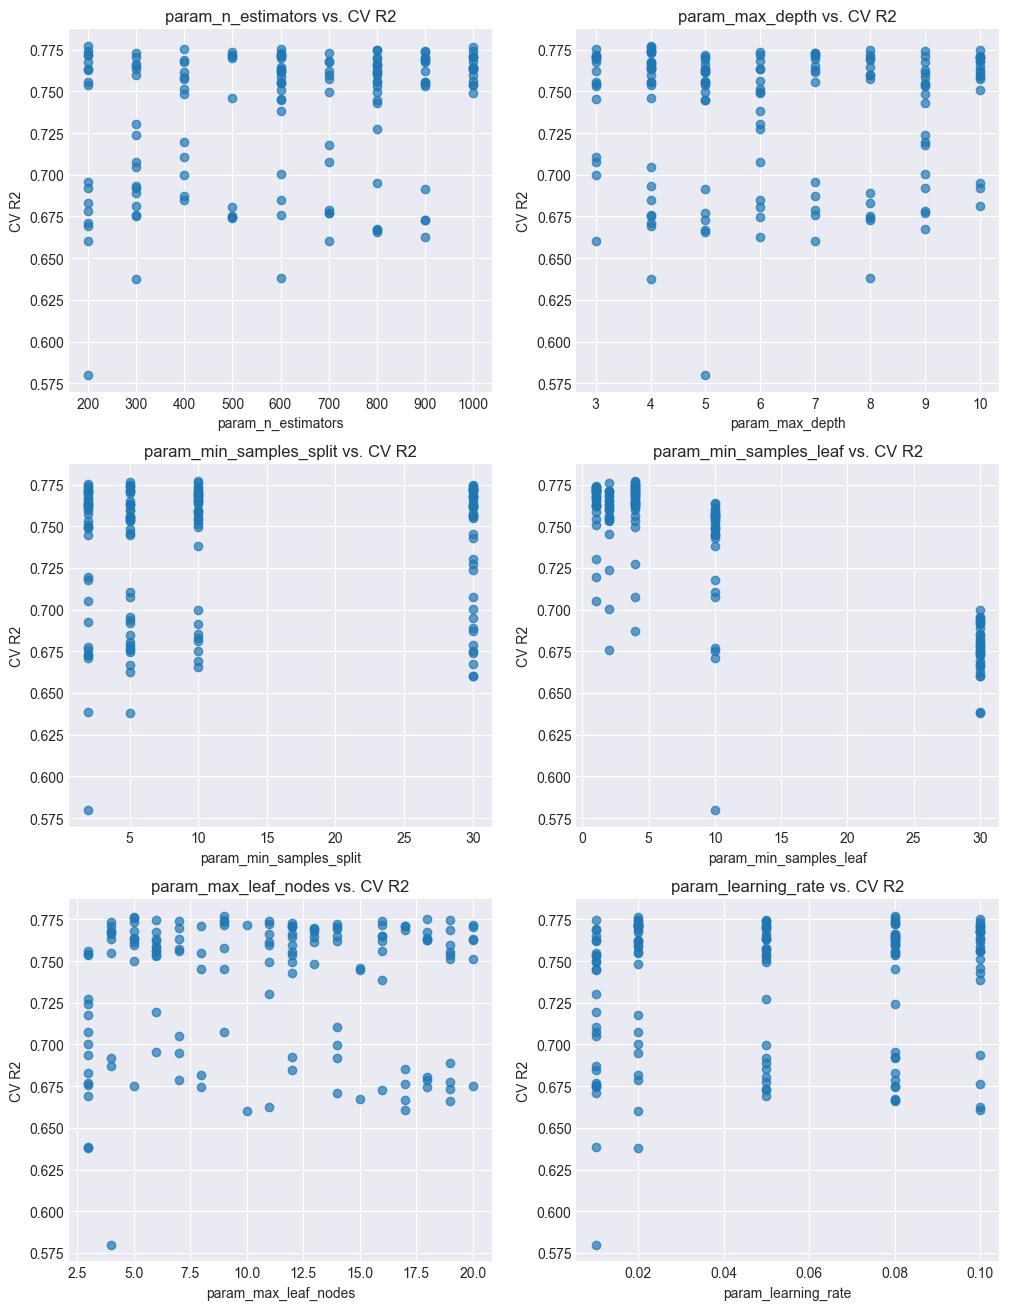

In [338]:
gbm_profit_cv_results = gbm_profit_cv_results[(gbm_profit_cv_results['param_max_depth'] > 1) & (gbm_profit_cv_results['param_max_leaf_nodes'] > 2) & (gbm_profit_cv_results['param_max_depth'] > 2)]
num_keys = len(random_grid.keys())
fig, axs = plt.subplots(num_keys // 2 + num_keys % 2, 2, figsize=(12,16))
for i, param in enumerate([ f"param_{key}" for key in random_grid.keys()]):    
    axs[i//2][i%2].scatter(x=gbm_profit_cv_results[param], y=gbm_profit_cv_results['mean_test_score'], alpha=0.7)
    axs[i//2][i%2].set_title(f"{param} vs. CV R2")
    axs[i//2][i%2].set_xlabel(param)
    axs[i//2][i%2].set_ylabel('CV R2')

Besides a clear drop in R2 with param_min_leaf, we don't really see any strong dependency. So let's leave our best estimate from before as is.

### Support vector regression

To finish and cover our bases we also setup up a random search scan for a support vector machine based search. We now switch again to the standardized data set as this should improve performance for SVM's (although this was not really noticeable in our tests).

The fitting of the SVM models depending on the hyperparameters can take a long time and certain hyperparameters even cause the SVM fitting to fail. Compared to the GBM and RF models the number samples taken is strongly reduced to achieve a reasonable calculation time with the available hardware. Through trial and error certain hyperparameters where dropped from the parameter grid as they were identified as causing the model fitting to fail.

In [339]:
# initializing the model
SVreg = svm.SVR()

# initializing hyperparameter grid for the search.
n_hyperparam_sample_SVreg_prof = 20 # pretty low number of samples because with the available hardware the fitting certain hyperparmeters combinations takes a long time

# Hyperparameters to be tuned
C = [round(x, 1) for x in np.arange(start=0.1, stop=1.0, step=0.2)]
cache_size = [x for x in np.arange(start=50, stop=700, step=100)]
coef0 = [round(x,3) for x in np.arange(start=0.0, stop=10.0, step=4.0)]
degree = [int(x) for x in np.arange(1, 10, step=2)]
epsilon = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0, 1.5, 2.0, 5.0, 10.0, 15.0, 20.0]
gamma = ['scale', 'auto', 0, 1, 2, 3, 4, 6, 8, 10, 20]
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
max_iter = [-1, 1, 2, 5, 10, 15, 20, 30, 50, 75, 100]
shrinking = [True, False]
tol = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0, 5.0, 10.0, 15.0, 20.0]
verbose = [True, False]

params_grid_SVreg_prof = {'C': C,
     'cache_size': cache_size,
     'coef0': coef0,
     'degree': degree,
     'epsilon': epsilon,
     'gamma': gamma,
     'kernel': kernel,
     'max_iter': max_iter,
     'shrinking': shrinking,
     'tol': tol,
     'verbose': verbose}

if os.path.exists(SVreg_profit_scan_filename) and not overwrite_SVM_model_training:
    print(f"Re-loading random search from {SVreg_profit_scan_filename}")
    SVreg_profit_tuning = joblib.load(SVreg_profit_scan_filename)

else:
    # initializing the random search object
    SVreg_profit_tuning = RandomizedSearchCV(estimator=SVreg, 
                                    param_distributions=params_grid_SVreg_prof, 
                                    n_iter=n_hyperparam_sample_SVreg_prof, 
                                    cv=KFold(n_splits=5, shuffle=True, random_state=seed),  
                                    verbose=2,
                                    random_state=seed, 
                                    n_jobs=-1)
    
    # Fitting the models
    SVreg_profit_tuning.fit(X_train_stan, y_train_stan)
    
    # Now you can access the fitted object, e.g. get best_params_
    print(f"Optimally found SVM parameters after this random search: {SVreg_profit_tuning.best_params_}")
    
    # -- and write out
    joblib.dump(value=SVreg_profit_tuning, 
                filename=SVreg_profit_scan_filename)
    
    print(f"Written : {SVreg_profit_scan_filename}")

Re-loading random search from models\SVreg_profit_random_search.pkl


c:\JAVA\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVR from version 1.5.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\JAVA\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomizedSearchCV from version 1.5.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [340]:
SVreg_profit_tuning.score(X_train_stan, y_train_stan)

0.25410339508141044

In [341]:
SVreg_profit_tuning.score(X_test_stan, y_test_stan)

0.26965201473713196

In [342]:
SVreg_results_profit_res = pd.DataFrame(SVreg_profit_tuning.cv_results_)

In [343]:
SVreg_results_profit_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_verbose,param_tol,param_shrinking,param_max_iter,param_kernel,param_gamma,param_epsilon,param_degree,param_coef0,param_cache_size,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.021499,0.002864,0.006848,0.000424,True,0.500,False,20,sigmoid,3,15.0,9,8.0,550,0.9,"{'verbose': True, 'tol': 0.5, 'shrinking': Fal...",-33.720877,-46.702169,-45.730196,-32.862990,-27.967489,-37.396744,7.470142,10
1,0.034806,0.003982,0.009900,0.001403,False,0.500,True,15,poly,6,0.4,3,8.0,50,0.9,"{'verbose': False, 'tol': 0.5, 'shrinking': Tr...",-0.963385,-6.668898,-18.435812,-7.191915,-15.588754,-9.769753,6.368265,3
2,0.013623,0.000534,0.006434,0.000788,False,20.000,True,30,poly,10,1.0,1,4.0,550,0.7,"{'verbose': False, 'tol': 20.0, 'shrinking': T...",-33.720877,-46.702169,-45.730196,-32.862990,-27.967489,-37.396744,7.470142,10
3,0.013914,0.000375,0.005930,0.000559,False,10.000,True,1,poly,20,0.2,1,4.0,750,0.1,"{'verbose': False, 'tol': 10.0, 'shrinking': T...",-9.532574,-36.376260,-35.710591,-25.586200,-18.769051,-25.194935,10.221112,8
4,0.104715,0.006793,0.020851,0.002265,True,0.010,True,100,poly,10,0.1,5,8.0,50,0.5,"{'verbose': True, 'tol': 0.01, 'shrinking': Tr...",-14.450088,-75.095234,-92.560448,-16.969509,-17.846588,-43.384374,33.499198,15
5,0.015542,0.000223,0.006633,0.000529,True,0.200,True,2,poly,10,15.0,3,4.0,650,0.9,"{'verbose': True, 'tol': 0.2, 'shrinking': Tru...",-33.720877,-46.702169,-45.730196,-32.862990,-27.967489,-37.396744,7.470142,10
6,0.020004,0.002339,0.007268,0.000371,False,1.000,False,15,sigmoid,0,5.0,7,0.0,150,0.9,"{'verbose': False, 'tol': 1.0, 'shrinking': Fa...",-16.767928,-22.105621,-23.052006,-16.284347,-19.758234,-19.593627,2.728864,5
7,2.228877,0.159415,0.133557,0.013906,False,1.000,True,-1,linear,0,0.3,5,8.0,250,0.3,"{'verbose': False, 'tol': 1.0, 'shrinking': Tr...",0.251158,0.338994,0.235634,0.265827,0.176854,0.253693,0.052269,1
8,0.020421,0.001438,0.009135,0.001307,False,0.001,False,2,rbf,8,0.3,5,8.0,50,0.9,"{'verbose': False, 'tol': 0.001, 'shrinking': ...",-16.767928,-32.570520,-31.800595,-16.284347,-19.758234,-23.436325,7.246257,6
9,0.035135,0.019217,0.007040,0.000120,True,0.050,False,10,linear,scale,5.0,1,8.0,50,0.3,"{'verbose': True, 'tol': 0.05, 'shrinking': Fa...",-10.534637,-11.951614,-19.772789,-8.494233,-16.055958,-13.361846,4.050530,4


Compared with the GBM and RF approaches the SVM approaches to predict profit has a rather poor performance (R2), both for the train dataset and the test dataset. Most runs actually resulted in R2 below 0. Further tuning of the SVM model was attempted by narrowing the hyperparametergrid that is used as input for the search. But unfortunately, no improvement was gained compared to the original best estimator from the original search. After several attempts of hyperparametertuning and one suspiciously good result (0.94), that was not really reproducible, the SVM approach for profit prediction was abandoned, by that time the RF and GBM  approaches got consistently better results. A major contributing factor for dropping the SVM approach was the long calculation time, resulting in rather small sample sizes for the searches.  

### Learning curve  

Below we have plotted the learning curve for both the RF and the GBM (Due to it's peformance SVM is ignored here).

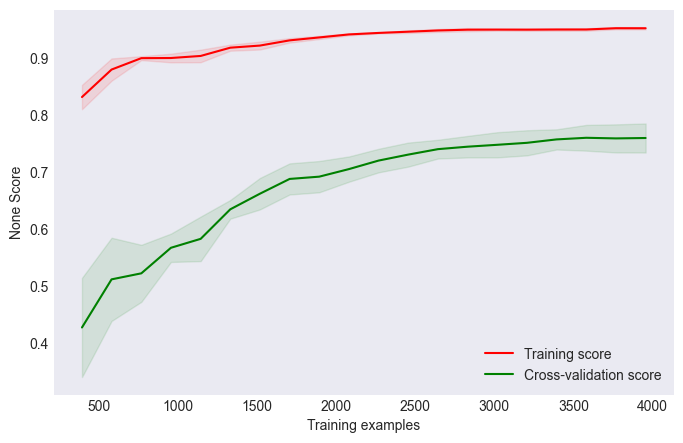

In [344]:
# The learning_curve for our model 
cuf.plot_learning_curve(model=rf_profit_best, 
                    X=train_V2.drop(target_features, axis=1), 
                    y=train_V2['outcome_profit'], 
                    cv=5, 
                    num_show=20)
plt.show()

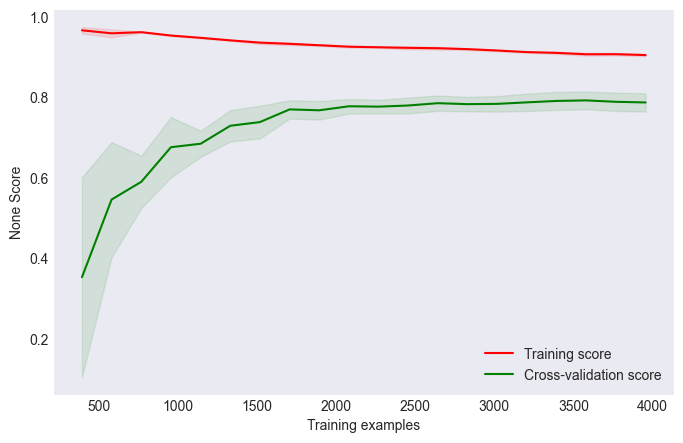

In [345]:
# The learning_curve for our model 
cuf.plot_learning_curve(model=gbm_profit_opt_final, 
                    X=train_V2.drop(target_features, axis=1), 
                    y=train_V2['outcome_profit'], 
                    cv=5, 
                    num_show=20)
plt.show()

We see that the CV score in case of the RF approach flattens out around 3000 training samples, for the GBM we already see convergence after ~2000 training samples. The GBM approach seems to be able to already provide top performance with less than half of the dataset. That's striking !

### Final model selection

Both RF and GBM did better than our baseline model (linear regression). Due to its performance on the test dataset and better learning curve in comparison with the RF appraoch the best GBM model from the search is chosen as the final model to predict the profit per guest.

In [346]:
model_profit = gbm_profit_opt_final

## Model to predict the outcome_damage

Now let's turn our attention to predicting the damage amount. The first thing we notice about the distribution of `outcome_damage_amount` is that it contains a lot of 0 values.

Text(0.5, 0, 'outcome_damage_amount')

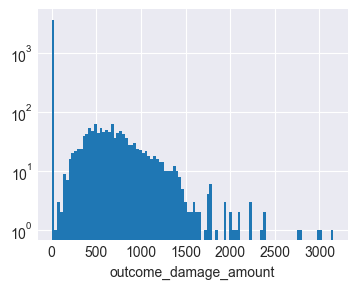

In [347]:
ax = train_V2["outcome_damage_amount"].hist(bins=100, log=True, figsize=(4,3))
ax.set_xlabel("outcome_damage_amount")

We can choose to either leave those in, probably when using a tree-based model, this won't make much difference, but we could also choose to make use of the classifier and first train whether a client will inflict damage or not and if he/she does, then calculate how much. This would correspond to training only on those samples for which the outcome_damage_amount is > 0, and therefore having a more consisten data sample (besides the one individual that managed to inflict only psychological damage (amount 0)). We have chosen the latter and will only train on those records which actually have inflicted damage. 

Therefore, out train / test split will select the instances with larger than 0 damage : 

In [348]:
idx_damage = train_V2[train_V2["outcome_damage_amount"] > 0].index

In [349]:
X_train, X_test, y_train, y_test = train_test_split(train_V2.loc[idx_damage].drop(target_features, axis=1), 
                                                    train_V2.loc[idx_damage,"outcome_damage_amount"],  
                                                    test_size=0.2,
                                                    shuffle=True, 
                                                    random_state=seed) 

In [350]:
X_train_stan, X_test_stan, y_train_stan, y_test_stan = train_test_split(train_v2_stan_df.loc[idx_damage].drop(target_features, axis=1),
                                                                        train_v2_stan_df.loc[idx_damage,"outcome_damage_amount"],
                                                                        test_size=0.2,
                                                                        shuffle=True,
                                                                        random_state=seed)

### Linear model

Just like with profit, we start with a simple out of the box linear model, to provide a baseline to which can compare the more complex models.
Because we are predicting a continuous value we use linear regression and use the scaled train-test split as input.

In [351]:
# Initializing the model
reg_damage = linear_model.LinearRegression()

# Fitting with the scaled data
reg_damage.fit(X_train_stan, y_train_stan)

LinearRegression()

In [352]:
# Training score (R2)
reg_damage.score(X_train_stan, y_train_stan)

0.21796423591245817

In [353]:
# Test score (R2)
reg_damage.score(X_test_stan, y_test_stan)

0.08831271567231236

Let's change the seed a couple of times for the train test-split to get an idea how stable the result is, just like with the profit linear model.

In [354]:
seeds = [int(x) for x in np.arange(1, 100, step=10)]
score_train = []
score_test = []

for number in seeds:
    X_train_stan_l, X_test_stan_l, y_train_stan_l, y_test_stan_l = train_test_split(train_v2_stan_df.drop(target_features, axis=1), # features DF
                                                    train_v2_stan_df['outcome_damage_amount'],   # target DF/series
                                                    test_size=0.2, 
                                                    shuffle=True,  
                                                    random_state=number) 
    reg_damage.fit(X_train_stan_l, y_train_stan_l)
    score_train.append(reg_damage.score(X_train_stan_l, y_train_stan_l))
    score_test.append(reg_damage.score(X_test_stan_l, y_test_stan_l))
    
reg_damage_score = pd.DataFrame({'Train_score': score_train, 'Test_score': score_test})

In [355]:
# calculate the mean for the scores
reg_damage_score.mean(axis= 0)

Train_score    0.119321
Test_score     0.100418
dtype: float64

In [356]:
# calculate the standard deviationf for the scores
reg_damage_score.std(axis= 0)

Train_score    0.008738
Test_score     0.032184
dtype: float64

So now we have a baseline R2 for both this seed and also a more general situation. 

### Random Forest Model

With the complex models we start with Random Forest again.

In [357]:
# Defining candidate grid to sample from (RandomizedSearchCV will sample from it)
n_estimators = [int(x) for x in np.linspace(start=150, stop=300, num=6)] 
max_depth = [int(x) for x in np.linspace(start=5, stop=85, num=8)]
max_depth.append(None)  # adding 'None' option as well
max_features = [0.7, 0.8, 0.9, 0.98]
min_samples_split = [4, 5, 6, 8]
min_samples_leaf = [2, 3, 4,6]
bootstrap = [True, False]

hyperparam_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

if os.path.exists(rf_damage_scan_filename) and not overwrite_RF_model_training:
    # -- re-load the scan from disc
    print(f"Re-loading the scan from {rf_damage_scan_filename}")
    rf_damage_hyperparam_tuning_random = joblib.load(rf_damage_scan_filename)

else:
    # Define data splitter to be used in the search
    n_folds = 5
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)

    # Define amount of hyperparameter tuning combinations to sample
    n_hyperparams_sample = 100

    # Defining model to apply random search CV hyperparam tuning on
    rf = RandomForestRegressor()

    # Initializing random search CV object
    rf_damage_hyperparam_tuning_random = RandomizedSearchCV(estimator=rf, 
                                            param_distributions=hyperparam_grid, 
                                            n_iter=n_hyperparams_sample, 
                                            cv=kfold,
                                            verbose=2, 
                                            random_state=seed, 
                                            n_jobs=-1)

    # Fit the random search by sampling hyperparameters from our grid, then fitting each model for each CV fold, aggregating results
    rf_damage_hyperparam_tuning_random.fit(X=X_train, y=y_train)

    # -- write the scan to file
    joblib.dump(
        value=rf_damage_hyperparam_tuning_random, 
        filename=rf_damage_scan_filename)
    
    print(f"Saved scan result to : {rf_damage_scan_filename}")


Re-loading the scan from models\rf_damage_random_search.pkl


c:\JAVA\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.5.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\JAVA\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.5.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\JAVA\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomizedSearchCV from version

In [358]:
print('Optimally found RF hyperparams after this random search: \n{}' .format(rf_damage_hyperparam_tuning_random.best_params_))

# Refitting the optimal model on the whole training dataset
rf_damage_best = rf_damage_hyperparam_tuning_random.best_estimator_
rf_damage_best.fit(X=X_train, y=y_train)

# Getting predictions on train and test set
rf_damage_best_y_train_pred = rf_damage_best.predict(X=X_train)
rf_damage_best_y_test_pred = rf_damage_best.predict(X=X_test)


# Checking accuracy manually
print('Train R2: %.3f' % rf_damage_best.score(X=X_train, y=y_train))
print('Test R2: %.3f' % rf_damage_best.score(X=X_test, y=y_test))

Optimally found RF hyperparams after this random search: 
{'n_estimators': 270, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 0.7, 'max_depth': 16, 'bootstrap': True}
Train R2: 0.557
Test R2: 0.131


This seems a realy bad result for the test set, expecvted more from Random Forest.

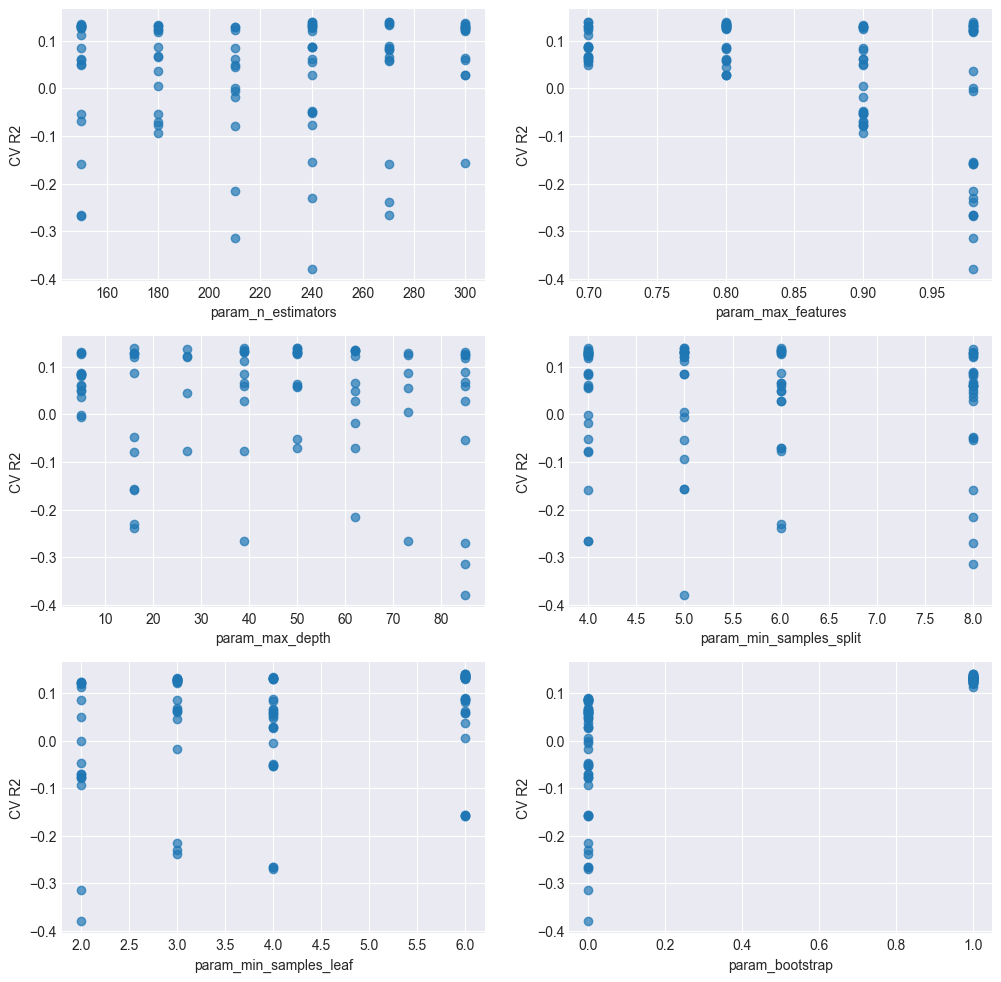

In [359]:
# Extracting hyperparameter tuning results and checking
rf_cv_res = pd.DataFrame(rf_damage_hyperparam_tuning_random.cv_results_)


num_keys = len(hyperparam_grid.keys())
fig, axs = plt.subplots(num_keys // 2 + num_keys % 2, 2, figsize=(12,12))
for i, param in enumerate([ f"param_{key}" for key in hyperparam_grid.keys()]):    
    axs[i//2][i%2].scatter(x=rf_cv_res[param], y=rf_cv_res['mean_test_score'], alpha=0.7)    
    axs[i//2][i%2].set_xlabel(param)
    axs[i//2][i%2].set_ylabel('CV R2')

### Gradient Boost Machine Regression

After the unexpected bad result for the Random Forest approach we quickly move to gradient boosting, hopefuly it wil do better.

In [360]:
# -- first choose how many hyperparameters to randomly sample
n_hyperparam_sample = 500

# -- build the search grid
random_grid = {
    'n_estimators': [ int(x) for x in np.linspace(start=200, stop=1000, num=18)],
    'max_depth': [int(x) for x in np.linspace(1, 20, num=10)],
    'min_samples_split': [2, 5, 10, 15, 20, 25, 30],
    'min_samples_leaf': [5, 10, 20, 30, 40, 50, 60],
    'max_leaf_nodes': [int(x) for x in np.linspace(2, 20, num=19)],
    'learning_rate': [0.005, 0.007, 0.01, 0.012, 0.015],
    'subsample': [0.2, 0.4, 0.6, 0.8, 1],
    'max_features':  [0.1, 0.3, 0.5, 0.7, 0.9]
    }


if os.path.exists(gbm_damage_scan_filename) and not overwrite_GBM_model_training:
    print(f"Re-loading random search from {gbm_damage_scan_filename}")
    gbm_damage_hyperparam_tuning_random = joblib.load(gbm_damage_scan_filename)

else:
    # Random search of parameters, using 3 fold cross validation, across 500 different hyperparameter combinations, and use all available cores
    gbm_damage_hyperparam_tuning_random = RandomizedSearchCV(estimator=GradientBoostingRegressor(), 
                                                    param_distributions=random_grid, 
                                                    n_iter=n_hyperparam_sample,   # Amount of hyperparameter values to sample
                                                    cv=KFold(n_splits=5, shuffle=True, random_state=seed), # setting the shuffle to True here ... 
                                                    verbose=2, # to print some outputs
                                                    random_state=seed, 
                                                    n_jobs=-1)

    # Fit the random search by sampling hyperparameters from our grid, then fitting each model for each CV fold, aggregating results.
    gbm_damage_hyperparam_tuning_random.fit(X=X_train, y=y_train)

    # Now you can access the fitted object, e.g. get best_params_
    print(f"Optimally found RF hyperparams after this random search: {gbm_damage_hyperparam_tuning_random.best_params_}")

    # -- and write out
    joblib.dump(value=gbm_damage_hyperparam_tuning_random, 
                filename=gbm_damage_scan_filename)

    print(f"Written scan to : {gbm_damage_scan_filename}")


Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Optimally found RF hyperparams after this random search: {'subsample': 0.2, 'n_estimators': 717, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_leaf_nodes': 16, 'max_features': 0.3, 'max_depth': 9, 'learning_rate': 0.007}
Written scan to : models\gbm_damage_random_search.pkl


In [361]:
# Now you can access the fitted object, e.g. get best_params_
print(f"Optimally found RF hyperparams after this random search: {gbm_damage_hyperparam_tuning_random.best_params_}")

# -- Refitting final optimal GBM on all training data
gbm_damage_opt_final = gbm_damage_hyperparam_tuning_random.best_estimator_
gbm_damage_opt_final.fit(X=X_train, y=y_train)

# -- Performances
print('Train R2: %.3f' % gbm_damage_opt_final.score(X=X_train, y=y_train))
print('Test R2: %.3f' % gbm_damage_opt_final.score(X=X_test, y=y_test))

Optimally found RF hyperparams after this random search: {'subsample': 0.2, 'n_estimators': 717, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_leaf_nodes': 16, 'max_features': 0.3, 'max_depth': 9, 'learning_rate': 0.007}
Train R2: 0.439
Test R2: 0.141


Worse than Random Forest on the train data but slightly better on the test data.

In [362]:
gbm_damage_cv_results = pd.DataFrame(gbm_damage_hyperparam_tuning_random.cv_results_)

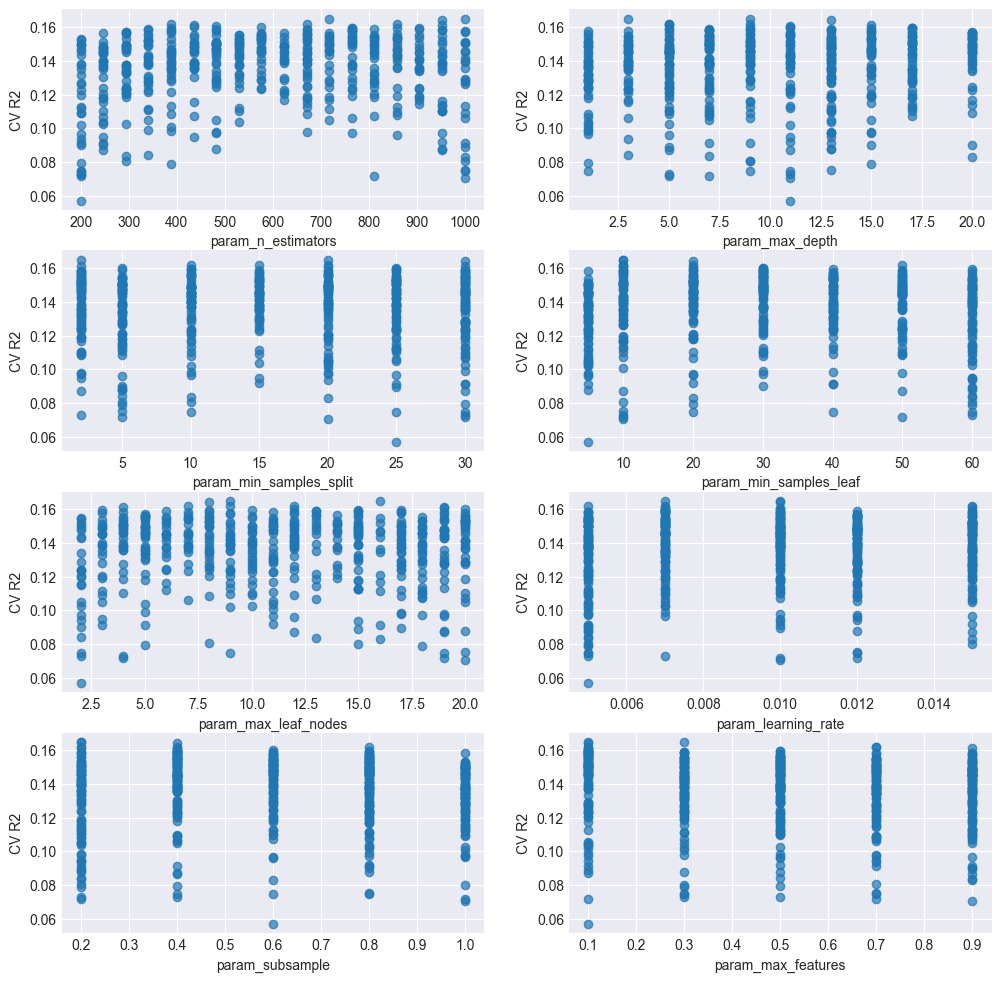

In [363]:
num_keys = len(random_grid.keys())
fig, axs = plt.subplots(num_keys // 2 + num_keys % 2, 2, figsize=(12,12))
for i, param in enumerate([ f"param_{key}" for key in random_grid.keys()]):    
    axs[i//2][i%2].scatter(x=gbm_damage_cv_results[param], y=gbm_damage_cv_results['mean_test_score'], alpha=0.7)
    axs[i//2][i%2].set_xlabel(param)
    axs[i//2][i%2].set_ylabel('CV R2')

Text(0.5, 0, 'Target')

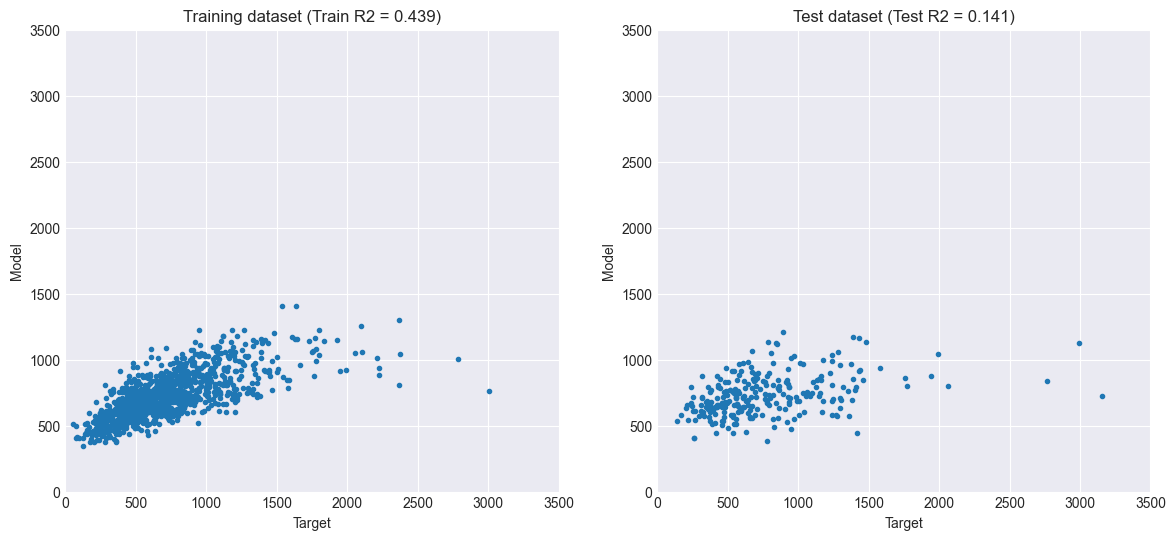

In [364]:
# -- let's make a quick plot of the results for the training & test dataset
axis_range = [0, 3500]
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs[0].plot(y_train, gbm_damage_opt_final.predict(X_train), '.')
axs[0].set_title(f"Training dataset (Train R2 = {gbm_damage_opt_final.score(X=X_train, y=y_train):.3})")
axs[0].set_ylim(axis_range)
axs[0].set_xlim(axis_range)
axs[0].set_ylabel("Model")
axs[0].set_xlabel("Target")

axs[1].plot(y_test, gbm_damage_opt_final.predict(X_test), '.')
axs[1].set_title(f"Test dataset (Test R2 = {gbm_damage_opt_final.score(X=X_test, y=y_test):.3})")
axs[1].set_ylim(axis_range)
axs[1].set_xlim(axis_range)
axs[1].set_ylabel("Model")
axs[1].set_xlabel("Target")

These graphs are not very encouraging. We especcially see that for a number of high-damage cases, the damage values are underestimated. Perhaps this is related to the fact that we omitted some outiers, but still this was done only for 2 values. From the plots above it would seem that perhaps they can be rectified a little by fitting a linear correction to the training dataset and then applying it to the test and subsequent score dataset, but this was tried and did not yield better R2. We leave it as it is for now. 

### Support vector regression

Again we also tried  a support vector machine regression approach. This attempt was plagued with the same performance issues as the profit attempt. A similar pattern as with profit followed, only was the attempt given up faster.

In [365]:
# initializing the model
SVreg = svm.SVR()

# initializing hyperparameter grid for the search.
n_hyperparam_sample_SVreg_dam = 15 # pretty low number of samples because with the available hardware the fitting certain hyperparmeters combinations takes a long time

# Hyperparameters to be tuned
C = [round(x, 1) for x in np.arange(start=0.1, stop=1.0, step=0.2)]
cache_size = [x for x in np.arange(start=50, stop=1000, step=100)]
coef0 = [round(x,3) for x in np.arange(start=0.0, stop=10.0, step=4.0)]
degree = [int(x) for x in np.arange(1, 10, step=2)]
epsilon = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0, 1.5, 2.0, 5.0, 10.0, 15.0, 20.0]
gamma = ['scale', 'auto', 0, 1, 2, 3, 4, 6, 8, 10, 20]
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
max_iter = [-1, 1, 2, 5, 10, 15, 20, 30, 50, 75, 100]
shrinking = [True, False]
tol = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0, 5.0, 10.0, 15.0, 20.0]
verbose = [True, False]

params_grid_SVreg_dam = {'C': C,
     'cache_size': cache_size,
     'coef0': coef0,
     'degree': degree,
     'epsilon': epsilon,
     'gamma': gamma,
     'kernel': kernel,
     'max_iter': max_iter,
     'shrinking': shrinking,
     'tol': tol,
     'verbose': verbose}

if os.path.exists(SVreg_damage_scan_filename) and not overwrite_SVM_model_training:
    print(f"Re-loading random search from {SVreg_damage_scan_filename}")
    SVreg_damage_tuning = joblib.load(SVreg_damage_scan_filename)

else:
    # initializing the random search object
    SVreg_damage_tuning = RandomizedSearchCV(estimator=SVreg, 
                                    param_distributions=params_grid_SVreg_dam, 
                                    n_iter=n_hyperparam_sample_SVreg_dam, 
                                    cv=KFold(n_splits=5, shuffle=True, random_state=seed),  
                                    verbose=2,
                                    random_state=seed, 
                                    n_jobs=-1)
    
    # Fitting the models
    SVreg_damage_tuning.fit(X_train_stan, y_train_stan)
    
    # Now you can access the fitted object, e.g. get best_params_
    print(f"Optimally found SVM parameters after this random search: {SVreg_damage_tuning.best_params_}")
    
    # -- and write out
    joblib.dump(value=SVreg_damage_tuning, 
                filename=SVreg_damage_scan_filename)
    
    print(f"Written : {SVreg_damage_scan_filename}")

Re-loading random search from models\SVreg_damage_random_search.pkl


c:\JAVA\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVR from version 1.5.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\JAVA\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomizedSearchCV from version 1.5.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [366]:
SVreg_damage_tuning.score(X_train_stan, y_train_stan)

0.16705736883601063

In [367]:
SVreg_damage_tuning.score(X_test_stan, y_test_stan)

0.017997798718034974

In [368]:
SVreg_results_damage_res = pd.DataFrame(SVreg_damage_tuning.cv_results_)

In [369]:
SVreg_results_damage_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_verbose,param_tol,param_shrinking,param_max_iter,param_kernel,param_gamma,param_epsilon,param_degree,param_coef0,param_cache_size,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011578,0.002608,0.006922,0.000688,True,0.500,False,20,sigmoid,3,15.0,9,8.0,550,0.9,"{'verbose': True, 'tol': 0.5, 'shrinking': Fal...",-5.136158,-3.372914,-5.403631,-3.904217,-4.026591,-4.368702,0.772586,4
1,0.026777,0.012359,0.007908,0.003048,False,0.500,True,15,poly,6,0.4,3,8.0,50,0.9,"{'verbose': False, 'tol': 0.5, 'shrinking': Tr...",-1.666523,-4.359786,-0.545319,-12.814592,-50.573355,-13.991915,18.788784,14
2,0.006962,0.000262,0.005695,0.000629,False,20.000,True,30,poly,10,1.0,1,4.0,550,0.7,"{'verbose': False, 'tol': 20.0, 'shrinking': T...",-5.136158,-3.372914,-5.403631,-3.904217,-4.026591,-4.368702,0.772586,4
3,0.008562,0.002136,0.006144,0.000992,False,10.000,True,1,poly,20,0.2,1,4.0,750,0.1,"{'verbose': False, 'tol': 10.0, 'shrinking': T...",-5.136158,-3.372914,-5.403631,-3.904217,-4.026591,-4.368702,0.772586,4
4,0.027392,0.002241,0.009874,0.001332,True,0.010,True,100,poly,10,0.1,5,8.0,50,0.5,"{'verbose': True, 'tol': 0.01, 'shrinking': Tr...",-19.300919,-108.354857,-4.171507,-361.354229,-970.142523,-292.664807,362.110660,15
5,0.008922,0.000721,0.007373,0.001476,True,0.200,True,2,poly,10,15.0,3,4.0,650,0.9,"{'verbose': True, 'tol': 0.2, 'shrinking': Tru...",-5.136158,-3.372914,-5.403631,-3.904217,-4.026591,-4.368702,0.772586,4
6,0.008879,0.001481,0.007807,0.004021,False,1.000,False,15,sigmoid,0,5.0,7,0.0,150,0.9,"{'verbose': False, 'tol': 1.0, 'shrinking': Fa...",-5.136158,-3.372914,-5.403631,-3.904217,-4.026591,-4.368702,0.772586,4
7,0.172286,0.013187,0.021567,0.003268,False,1.000,True,-1,linear,0,0.3,5,8.0,250,0.3,"{'verbose': False, 'tol': 1.0, 'shrinking': Tr...",0.078934,0.004018,0.169693,0.025194,0.139731,0.083514,0.063764,1
8,0.011714,0.003742,0.011211,0.005290,False,0.001,False,2,rbf,8,0.3,5,8.0,50,0.9,"{'verbose': False, 'tol': 0.001, 'shrinking': ...",-1.948809,-1.731657,-2.119572,-1.495606,-1.495709,-1.758271,0.247177,3
9,0.017778,0.013734,0.007621,0.001678,True,0.050,False,10,linear,scale,5.0,1,8.0,50,0.3,"{'verbose': True, 'tol': 0.05, 'shrinking': Fa...",-5.136158,-3.372914,-5.403631,-3.904217,-4.026591,-4.368702,0.772586,4


Again a terrible R2 performance compared to GBM and RF, most R2 found are even below 0. Some limited hyperparameter tuning was attempted, but quickly abandoned, this time not because of the GBM or RF doing really well, but they still remained consistently better and the long calculation times of SVM encouraged us to again give up on SVM as an approach that would be feasible.

### Final model selection

Here we noticed that the GBM does not offer much improvement compared to the Random Forest technique. In both cases we get reasonable R2 on the training dataset (order 0.45 - 0.55), but consistently, the test R2 does not yield much more than 0.14 - 0.15, which is not very encouraging. We go again  for the Gradient boosting model as the best model, but honestly it is a toss-up between this one and the Random forest model.

In [370]:
# -- select best model for predicting damage if damage occurs
model_damage = gbm_damage_opt_final

## Model to predict the outcome_revenue

As we noticed that predicting the damage is rather difficult, yielding low R2 in our analises, we decided to investigate whether directly predicting the revenue, i.e. `outcome_profit - outome_damage_amount` is a better strategy. 

In [371]:
# -- first produce a train/test set again on the 
X_train, X_test, y_train, y_test = train_test_split(train_V2.drop(target_features, axis=1), 
                                                    train_V2["outcome_revenue"],  
                                                    test_size=0.2,
                                                    shuffle=True, 
                                                    random_state=seed)

X_train_stan, X_test_stan, y_train_stan, y_test_stan = train_test_split(train_v2_stan_df.drop(target_features, axis=1), 
                                                    train_v2_stan_df['outcome_revenue'], 
                                                    test_size=0.2, 
                                                    shuffle=True,  
                                                    random_state=seed) 

### Linear model

Again, we start with a simple out of the box linear model, to provide a baseline to which can compare the more complex models.

In [372]:
# Initializing the model
reg_revenue = linear_model.LinearRegression()

# Fitting with the scaled data
reg_revenue.fit(X_train_stan, y_train_stan)

LinearRegression()

In [373]:
# Training score (R2)
reg_revenue.score(X_train_stan, y_train_stan)

0.304052740037446

In [374]:
# Test score (R2)
reg_revenue.score(X_test_stan, y_test_stan)

0.37487756338527367

Again calculating the model for other seeds.

In [375]:
seeds = [int(x) for x in np.arange(1, 100, step=10)]
score_train = []
score_test = []

for number in seeds:
    X_train_stan_l, X_test_stan_l, y_train_stan_l, y_test_stan_l = train_test_split(train_v2_stan_df.drop(target_features, axis=1), # features DF
                                                    train_v2_stan_df['outcome_revenue'],   # target DF/series
                                                    test_size=0.2, 
                                                    shuffle=True,  
                                                    random_state=number) 
    reg_revenue.fit(X_train_stan_l, y_train_stan_l)
    score_train.append(reg_revenue.score(X_train_stan_l, y_train_stan_l))
    score_test.append(reg_revenue.score(X_test_stan_l, y_test_stan_l))
    
reg_revenue_score = pd.DataFrame({'Train_score': score_train, 'Test_score': score_test})

In [376]:
# calculate the mean for the scores
reg_revenue_score.mean(axis= 0)

Train_score    0.346338
Test_score     0.287713
dtype: float64

In [377]:
# calculate the standard deviationf for the scores
reg_revenue_score.std(axis= 0)

Train_score    0.017250
Test_score     0.074441
dtype: float64

### Random Forest Model

In [378]:
# Defining candidate grid to sample from (RandomizedSearchCV will sample from it)
n_estimators = [int(x) for x in np.linspace(start=150, stop=300, num=10)]  # list comprehension because we want integers!
max_depth = [int(x) for x in np.linspace(start=5, stop=80, num=5)]
max_depth.append(None)  # adding 'None' option as well
max_features = [0.7, 0.8, 0.85, 0.9, 0.95]
min_samples_split = [4, 5, 6, 8]
min_samples_leaf = [2, 3, 4]
bootstrap = [True]
hyperparam_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

if os.path.exists(rf_revenue_scan_filename) and not overwrite_RF_model_training:
    print(f"Re-loading random search from {rf_revenue_scan_filename}")
    rf_revenue_hyperparam_tuning_random = joblib.load(rf_revenue_scan_filename)

else:
    # Define data splitter to be used in the search
    n_folds = 5
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    
    # Define amount of hyperparameter tuning combinations to sample
    n_hyperparams_sample = 100

    # Defining model to apply random search CV hyperparam tuning on
    rf = RandomForestRegressor()

    # Initializing random search CV object
    rf_revenue_hyperparam_tuning_random = RandomizedSearchCV(estimator=rf, 
                                                     param_distributions=hyperparam_grid, 
                                                     n_iter=n_hyperparams_sample, 
                                                     cv=kfold,
                                                     verbose=2, 
                                                     random_state=seed, n_jobs=-1)

    # Fit the random search by sampling hyperparameters from our grid, then fitting each model for each CV fold, aggregating results
    rf_revenue_hyperparam_tuning_random.fit(X=X_train, y=y_train)

    # -- and write out
    joblib.dump(value=rf_revenue_hyperparam_tuning_random, 
                filename=rf_revenue_scan_filename)
    
    print(f"Written random search to {rf_revenue_scan_filename}")

Re-loading random search from models\rf_revenue_random_search.pkl


c:\JAVA\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.5.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\JAVA\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.5.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\JAVA\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomizedSearchCV from version

In [379]:
print('Optimally found RF hyperparams after this random search: \n{}' .format(rf_revenue_hyperparam_tuning_random.best_params_))

# Refitting the optimal model on the whole training dataset
rf_revenue_best = rf_revenue_hyperparam_tuning_random.best_estimator_
rf_revenue_best.fit(X=X_train, y=y_train)

# Getting predictions on train and test set
rf_revenue_best_y_train_pred = rf_revenue_best.predict(X=X_train)
rf_revenue_best_y_test_pred = rf_revenue_best.predict(X=X_test)

# Checking score (R2) manually
print('Train R2: %.3f' % rf_revenue_best.score(X=X_train, y=y_train))
print('Test R2: %.3f' % rf_revenue_best.score(X=X_test, y=y_test))

Optimally found RF hyperparams after this random search: 
{'n_estimators': 283, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.95, 'max_depth': 61, 'bootstrap': True}
Train R2: 0.926
Test R2: 0.766


This is not too bad actually, let's look at the GBM again as well. 


### Gradient Boosting Machine Regression

As always, we first played around manually with the parameter settings, which subsequently resulted in the following scan ranges for the random grid. 

In [380]:
# -- first choose how many hyperparameters to randomly sample
n_hyperparam_sample = 500

# -- build the search grid
random_grid = {
    'n_estimators': [ int(x) for x in np.linspace(start=300, stop=1000, num=8)],
    'max_depth': [int(x) for x in np.linspace(2, 20, num=11)],
    'min_samples_split': [2, 5, 10, 15, 20, 25, 30],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_leaf_nodes': [5, 10, 15, 20],
    'learning_rate': [0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    'subsample': [0.4, 0.6, 0.8, 1]
    }

    # max_features : best when 1.0 it was found

if os.path.exists(gbm_revenue_scan_filename) and not overwrite_GBM_model_training:
    print(f"Re-loading random search from {gbm_revenue_scan_filename}")
    gbm_revenue_hyperparam_tuning_random = joblib.load(gbm_revenue_scan_filename)

else:
    # Random search of parameters, using 3_fold cross validation, across 500 different hyperparameter combinations, and use all available cores
    gbm_revenue_hyperparam_tuning_random = RandomizedSearchCV(estimator=GradientBoostingRegressor(), 
                                                    param_distributions=random_grid, 
                                                    n_iter=n_hyperparam_sample,   # Amount of hyperparameter values to sample
                                                    cv=KFold(n_splits=5, shuffle=True, random_state=seed), # setting the shuffle to True here ... 
                                                    verbose=2, # to print some outputs
                                                    random_state=seed, 
                                                    n_jobs=-1)

    # Fit the random search by sampling hyperparameters from our grid, then fitting each model for each CV fold, aggregating results
    gbm_revenue_hyperparam_tuning_random.fit(X=X_train, y=y_train)

    # -- and write out
    joblib.dump(value=gbm_revenue_hyperparam_tuning_random, 
                filename=gbm_revenue_scan_filename)

    print(f"Written {gbm_revenue_scan_filename}")

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Written models\gbm_revenue_random_search.pkl


In [381]:
# Now you can access the fitted object, e.g. get best_params_
print(f"Optimally found RF hyperparams after this random search: {gbm_revenue_hyperparam_tuning_random.best_params_}")

# Refitting the optimal model on the whole training dataset
gbm_revenue_best = gbm_revenue_hyperparam_tuning_random.best_estimator_
gbm_revenue_best.fit(X=X_train, y=y_train)

# Getting predictions on train and test set
gbm_revenue_best_y_train_pred = gbm_revenue_best.predict(X=X_train)
gbm_revenue_best_y_test_pred = gbm_revenue_best.predict(X=X_test)

# Checking score (R2) manually
print('Train R2: %.3f' % gbm_revenue_best.score(X=X_train, y=y_train))
print('Test R2: %.3f' % gbm_revenue_best.score(X=X_test, y=y_test))

Optimally found RF hyperparams after this random search: {'subsample': 0.8, 'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_leaf_nodes': 5, 'max_depth': 14, 'learning_rate': 0.07}
Train R2: 0.832
Test R2: 0.810


We notice that the training R2 is more or less of the same order as the RF approach, however the test R2 is noticeable better.

### Support vector regression

For the revenue prediction we did not look at SVM based regression anymore. After the previous bad experience and the general dificult in doing the tuning due to the long calculation times adn the fact that it is challenging to find which hyperparameters cause runs to fail, we have given up on getting a good result for SVM regression for this dataset.

### Revenue comparison

Finally, we compare the total revenue predicted with the one in the test set

Text(0.5, 0, 'Test data revenue')

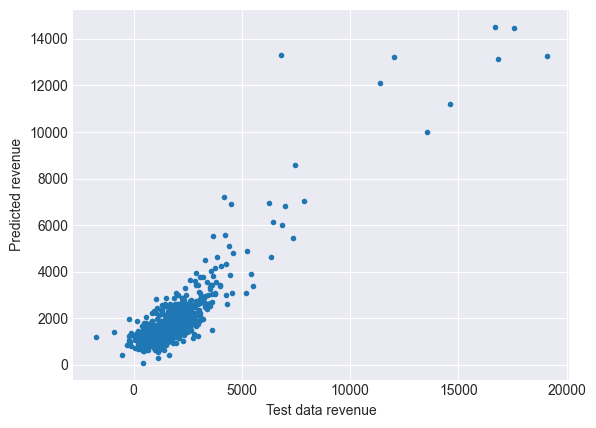

In [382]:
gbm_rev_pred = gbm_revenue_best.predict(X_test)
plt.plot(y_test, gbm_rev_pred, '.')
plt.ylabel("Predicted revenue")
plt.xlabel("Test data revenue")

This looks good, a lot better than with the damage amount.

Below we perform an analysis of how accurate the revenue is modelled as a function of number of guests. So we will select the N most profitable guest (highest revenue) from the test set and from the prediction set & compare those as a function of number of guests. 

But first we train/test split test dataset again so that our test dataset is reduced down to the size of a typical seasonal intake of candidates (500). We do this so that the calculated figures closely mirror what we could expect the revenue to be for one season. This allows us to use these figures in the executive summary to properly frame the revenue gain that is predicted for the next season.

In [383]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_test, 
                                                    y_test,  
                                                    test_size=0.49, # slightly higher to compensate for the fact that a number of records where dropped and the test set from the 20% test split is not exactly 1000 anymore.
                                                    shuffle=True, 
                                                    random_state=seed)

gbm_rev_pred_s = gbm_revenue_best.predict(X_train_s)

In [384]:
num_guests = np.linspace(25, 500, 31)
rev_test = np.zeros(num_guests.shape)
rev_pred = np.zeros(num_guests.shape)
for i, n in enumerate(num_guests):
    n = int(n)
    rev_pred[i] = np.partition(gbm_rev_pred_s, -n)[-n:].sum()
    rev_test[i] = np.partition(y_train_s.values, -n)[-n:].sum()


Text(0.5, 0, 'Number of top revenue guests selected')

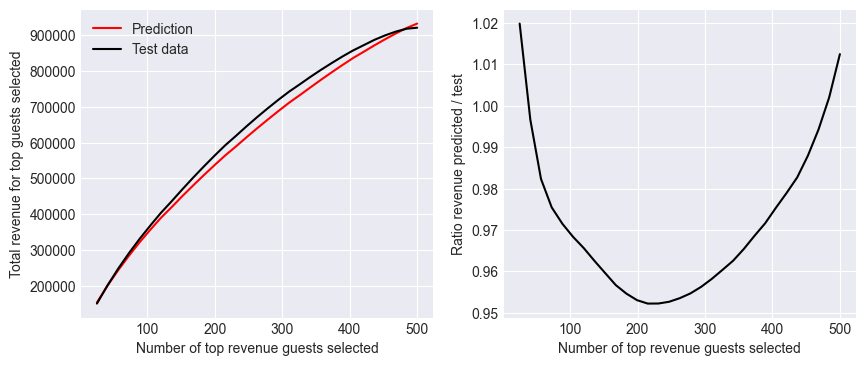

In [385]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].plot(num_guests, rev_pred, 'r', label="Prediction")
axs[0].plot(num_guests, rev_test, 'k', label="Test data")
axs[0].set_ylabel("Total revenue for top guests selected")
axs[0].set_xlabel("Number of top revenue guests selected")
axs[0].legend()

axs[1].plot(num_guests, rev_pred/rev_test, 'k')
axs[1].set_ylabel("Ratio revenue predicted / test")
axs[1].set_xlabel("Number of top revenue guests selected")

In [386]:
print(f'Total revenue predicted for the 200 most profitable guests:  {np.partition(gbm_rev_pred_s, -200)[-200:].sum()}')
print(f"Total revenue in test set for the 200 most profitable guests: {np.partition(y_train_s.values, -200)[-200:].sum()}")

Total revenue predicted for the 200 most profitable guests:  538479.6109256609
Total revenue in test set for the 200 most profitable guests: 565055.37


So the model seems to underestimate the revenue by ~5 %. 

But what happens isf we rerun this analysis with a slightly different split of the test dataset?

In [387]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_test, 
                                                    y_test,  
                                                    test_size=0.51, # slightly higher to compensate for the fact that a number of records where dropped and the test set from the 20% test split is not exactly 1000 anymore.
                                                    shuffle=True, 
                                                    random_state=seed)

gbm_rev_pred_s = gbm_revenue_best.predict(X_test_s)

In [388]:
num_guests = np.linspace(25, 500, 31)
rev_test = np.zeros(num_guests.shape)
rev_pred = np.zeros(num_guests.shape)
for i, n in enumerate(num_guests):
    n = int(n)
    rev_pred[i] = np.partition(gbm_rev_pred_s, -n)[-n:].sum()
    rev_test[i] = np.partition(y_test_s.values, -n)[-n:].sum()

Text(0.5, 0, 'Number of top revenue guests selected')

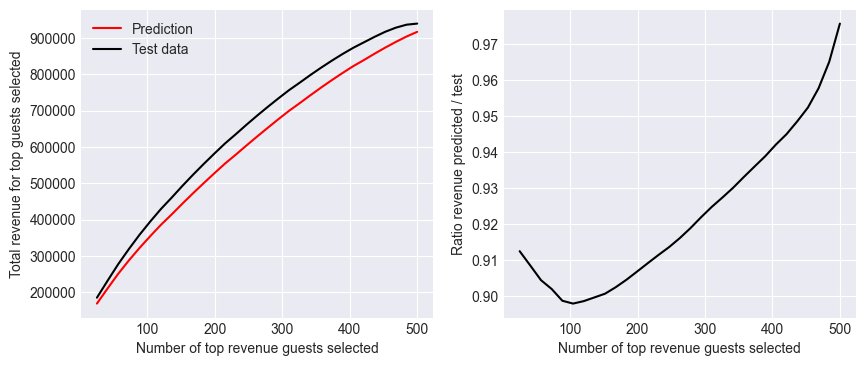

In [389]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].plot(num_guests, rev_pred, 'r', label="Prediction")
axs[0].plot(num_guests, rev_test, 'k', label="Test data")
axs[0].set_ylabel("Total revenue for top guests selected")
axs[0].set_xlabel("Number of top revenue guests selected")
axs[0].legend()

axs[1].plot(num_guests, rev_pred/rev_test, 'k')
axs[1].set_ylabel("Ratio revenue predicted / test")
axs[1].set_xlabel("Number of top revenue guests selected")

In [390]:
print(f'Total revenue predicted for the 200 most profitable guests:  {np.partition(gbm_rev_pred_s, -200)[-200:].sum()}')
print(f"Total revenue in test set for the 200 most profitable guests: {np.partition(y_test_s.values, -200)[-200:].sum()}")

Total revenue predicted for the 200 most profitable guests:  529047.9033696826
Total revenue in test set for the 200 most profitable guests: 583288.39


So now the model seems to underestimate the revenue by ~9.5 %.

Let's do some bootstrapping to get a likely average value of the revenue gained from a selection of 200 guests from the test set.

In [391]:
sample_size = 200

total = []
total_pred = []
for i in range(100):
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_test, 
                                                    y_test,  
                                                    test_size=0.51, # slightly higher to compensate for the fact that a number of records where dropped and the test set from the 20% test split is not exactly 1000 anymore.
                                                    shuffle=True, 
                                                   random_state=i)
    gbm_rev_pred_s = gbm_revenue_best.predict(X_test_s)
    total_pred.append(np.partition(gbm_rev_pred_s, -200)[-200:].sum())
    total.append(np.partition(y_test_s.values, -200)[-200:].sum())

print(f'Total average revenue predicted for the 200 most profitable guests:  {mean(total_pred)}')
print(f"Total average revenue in test set for the 200 most profitable guests: {mean(total)}")
perc = pd.DataFrame([(1-(i/j))*100 for i,j in zip(total_pred, total)], columns = ['percentage'])
print(f"The revenue is on average underestimated by: {perc['percentage'].mean(axis= 0)}")
print(f"The standard deviation on this average is: {perc['percentage'].std(axis= 0)}")

Total average revenue predicted for the 200 most profitable guests:  525483.2287881229
Total average revenue in test set for the 200 most profitable guests: 566562.8538
The revenue is on average underestimated by: 7.229994600021591
The standard deviation on this average is: 1.4090608569218361


So the model seems to on average underestimate the revenue by 7.5%

 ### Final model selection

Given it's better R2 we again select the best GBM model as our final model.

In [392]:
# -- select the GBM model 
model_revenue = gbm_revenue_best

## Classifier to predict which clients will cause damage

In this part we train a classifier to identify which clients will cause damages. Note that apparently a single person managed to inflict `damage`, but with 0 damage amount. Let's assume that not all damage can be quantified in hard currency :) and continue with `outcome_damage_inc` as an indicator, leaving in this person.  

A few questions we should consider : 

First of all, let's take a look to the plots below, where we can see on the one hand that there is a significant imbalance between the 2 classes : 74 % of the guest don't inflict any damage, whereas 26 % do inflict damage. So 3 times as many guests inflict no damage vs. the ones that do. Though the discrepancy is not extreme, it may be worthwhile to deal with this imbalance in the training. First we should note that given this imbalance, we should probably better not just optimize for accuracy in the training as this can give misleading results as the model evaluation will be dominated by its skill in predicting the majority class. We will therefore treat the imbalance via minority over-sampling. We will not try to introduce synthetic samples (SMOTE) out of fear this may negatively impact the training, but stick to simply oversampling the guests causing damage. After all, we have already seen that creating a model for the damage amount is not easy, so let's not try to confusing things with synthetic samples. 

In [393]:
# -- note that there is one particular individual which managed to inflict only emotional damage as well
train_V2[(train_V2['outcome_damage_inc'] == 1) & (train_V2["outcome_damage_amount"] == 0) ]

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,avg_score_pos,avg_score_neg,num_score_pos,num_score_neg,outcome_profit,outcome_damage_amount,outcome_damage_inc,outcome_revenue
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1708,2169.0,778.0,2308.0,0.0,0.0,6000.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,3.0,0.0,27725.0,40.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,2.0,0.0,287.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,0.0,0.0,0.981625,0.183575,1.0,1.0,1062.86,0.0,1,1062.86


In [394]:
train_V2['outcome_damage_inc'].value_counts(normalize=True)

outcome_damage_inc
0    0.744388
1    0.255612
Name: proportion, dtype: float64

Text(0.5, 1.0, 'outcome_profit')

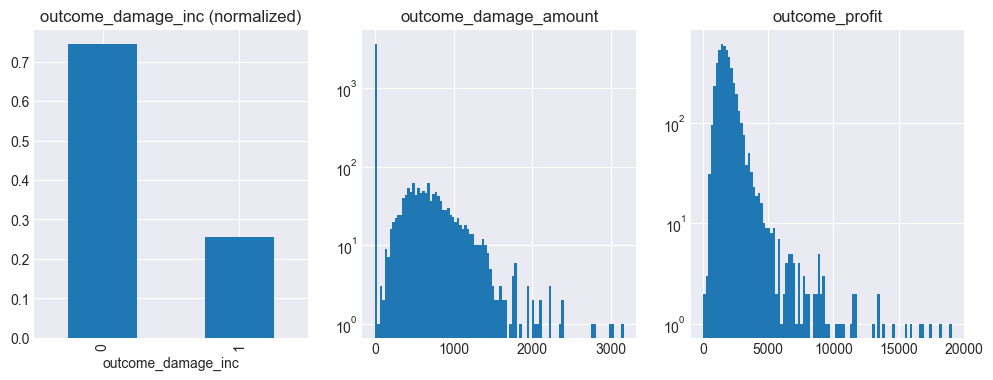

In [395]:
fig, axs = plt.subplots(1,3, figsize=(12, 4))
train_V2['outcome_damage_inc'].value_counts(normalize=True).plot(kind='bar', ax=axs[0])
train_V2['outcome_damage_amount'].hist(ax=axs[1], bins=100, log=True)
train_V2['outcome_profit'].hist(ax=axs[2], bins=100, log=True)
axs[0].set_title("outcome_damage_inc (normalized)")
axs[1].set_title("outcome_damage_amount")
axs[2].set_title("outcome_profit")

In addition, we should stop to think on what metric in training is more relevant to optimise. We already established that optimizing for accuracy is not the best strategy given the imbalance in the dataset.  Clearly, both false positive and false negatives are undesirable, however there is a clear difference in the implications. We can see in the distribution of the damage outcome that costs are roughly around 1000 EUR, whereas the most likely profit is say round 2000 EUR, so when damage occurs, it's often a considerable fraction of the profit. So there is a non-negligible cost associated with missing guests who inflict damage.

To put it more clearly : 

- If the cost of wrongly predicting that a guest will cause damage (false positive) is high (e.g., unnecessary precautions that are costly or offend guests), then we would want to optimize for high precision. This ensures that when we do predict damage, we are more likely to be correct. Wrongly predicting that a guest will cause damage does however not impact our revenue (if we disregard the long term psychological effects and disgruntled guests & want to go for short term profit that is...). 

- If the cost of missing a guest who will cause damage (false negative) is high (e.g., severe damage and associated costs, which we kinda established above), then we would want to optimize for high recall. This ensures that we capture most of the guests who are likely to cause damage, even if it means having more false positives (and offending guest). Also, from a profit perspective, if we miss a guest that will cause damage, this impacts our revenue with the amount of damage caused. 

This may depend somewhat on the correlation between the profit and the damage. If we risk offending high profit guests, then optimizing for recall may turn against us. 

We may consider to optimize for the F1 score instead to have a balance between precision & recall, but since we're dealing with Russian hotel guests and not West-Europeans, chances are probably smaller that they will be offended by some bluntness from the hotel staff and by ubiquitous CCTV installations ;-). And after all we do prefer to maximize the revenue. 

In the absence of the hotel management to discuss with, let's go for optimizing recall...

Whether we first do train/test split and then oversample or vice versa is subject of debate. if we first do the train/test split, we should probably be sure that the fraction of positives in both datasets is roughly the same, so we print out the  `value_counts()` to check. 

In [396]:
# -- again we get the train test split
X_train, X_test, y_train, y_test = train_test_split(train_V2.drop(target_features, axis=1), # features DF
                                                    train_V2['outcome_damage_inc'],   # target DF/series
                                                    test_size=0.2,
                                                    shuffle=True,  
                                                    random_state=seed)  

print("Counts for every outcome in training dataset : ")
print(y_train.value_counts())
print("Counts for every outcome in test dataset : ")
print(y_test.value_counts())


Counts for every outcome in training dataset : 
outcome_damage_inc
0    2942
1    1014
Name: count, dtype: int64
Counts for every outcome in test dataset : 
outcome_damage_inc
0    739
1    250
Name: count, dtype: int64


Now we oversample the training dataset, but not the test dataset, we will keep that separate for reporting. 

In [397]:
sm = RandomOverSampler(sampling_strategy='auto', random_state=seed)

# Call fit_resample() to do actual sampling using training data
X_train_oversample, y_train_oversample = sm.fit_resample(X=X_train, y=y_train) 

print("Counts for every outcome after synthetic oversampling: ")
y_train_oversample.value_counts()

Counts for every outcome after synthetic oversampling: 


outcome_damage_inc
0    2942
1    2942
Name: count, dtype: int64

Why did  we not use SMOTE?

While SMOTE can help improve model performance in terms of accuracy, it can sometimes lead to a decrease in recall for the minority class.

This negative impact on recall can occur because SMOTE generates synthetic examples by interpolating between existing minority class instances. As a result, the model may become overly confident in predicting the minority class, leading to more false positives in the predictions and thus reducing the recall for that class.

To mitigate this issue, it's important to carefully evaluate the trade-offs between different performance metrics like recall, precision, and accuracy when using SMOTE. Additionally, tuning the model parameters and considering alternative techniques like adjusting class weights or using more advanced sampling methods may help improve recall without sacrificing other performance metrics.

### Baseline logistic regression

Below we establish a baseline simple logistic regression to see how much added value the more complex methods have. 

In [398]:
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(train_v2_stan_df.drop(target_features, axis=1), 
                                                    train_V2["outcome_damage_inc"],  
                                                    test_size=0.2,
                                                    shuffle=True, 
                                                    random_state=seed) 

regl = LogisticRegression()
regl.fit(X_train_d, y_train_d)

print(regl.score(X_train_d, y_train_d))
print(regl.score(X_test_d, y_test_d))

0.7598584428715874
0.7583417593528817


In [399]:
print(recall_score(y_train_d, regl.predict(X_train_d)))
print(recall_score(y_test_d, regl.predict(X_test_d)))

0.15088757396449703
0.112


Just like we did with the linear models we'll also run the model for different seeds. Again the difference between the models is the different composition of the train test/split.

In [400]:
seeds = [int(x) for x in np.arange(1, 100, step=10)]
score_train = []
score_test = []
recall_train = []
recall_test = []

for number in seeds:
    X_train_stan_l, X_test_stan_l, y_train_stan_l, y_test_stan_l = train_test_split(train_v2_stan_df.drop(target_features, axis=1), # features DF
                                                    train_V2["outcome_damage_inc"],   # target DF/series
                                                    test_size=0.2, 
                                                    shuffle=True,  
                                                    random_state=number) 
    regl.fit(X_train_stan_l, y_train_stan_l)
    score_train.append(regl.score(X_train_stan_l, y_train_stan_l))
    score_test.append(regl.score(X_test_stan_l, y_test_stan_l))
    recall_train.append(recall_score(y_train_stan_l, regl.predict(X_train_stan_l)))
    recall_test.append(recall_score(y_test_stan_l, regl.predict(X_test_stan_l)))
    
reg_damage_inc_score = pd.DataFrame({'Train_score': score_train, 'Test_score': score_test, 'Train_recall': recall_train, 'Test_recall': recall_test})

In [401]:
# calculate the mean for the scores
reg_damage_inc_score.mean(axis= 0)

Train_score     0.760313
Test_score      0.753994
Train_recall    0.142661
Test_recall     0.138095
dtype: float64

In [402]:
# calculate the standard deviation for the scores
reg_damage_inc_score.std(axis= 0)

Train_score     0.002719
Test_score      0.009581
Train_recall    0.010179
Test_recall     0.020864
dtype: float64

### Support vector machine

We now will start with the support vector machine approach. It was again a frustrating experience with long calculation times and frequent failures of runs in the random search. Eventually after some trial and error we found a grid that resulted in an acceptable number of failures and miraculously the final data preparation with the onehotencoder and scaling seemed to bring down calculation times to an acceptable level. Why it now runs smoother is a bit unclear.

In [403]:
# Loading the SVM classifier
SVcla = svm.SVC()

In [404]:
n_hyperparam_sample = 100

# Hyperparamters to be tuned
C = [round(x, 1) for x in np.arange(start=0.1, stop=1.0, step=0.2)]
cache_size = [x for x in np.arange(start=50, stop=1000, step=100)]
class_weight = [None, 'balanced', {0:1, 1:1}, {0:1, 1:2}, {0:1, 1:3}, {0:1, 1:4}, {0:2, 1:1}, {0:3, 1:1}, {0:4, 1:1}, {0:5, 1:1}, {0:6, 1:1}]
decision_function_shape = ['ovo', 'ovr']
break_ties = [True, False]
random_state = [None, 0, 1, 2, 6, 10, 20]
coef0 = [1.0, 2.0, 3.0]
degree = [1, 2, 3, 4]
gamma = ['scale', 'auto', 0, 1, 2, 3, 5]
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
max_iter = [-1, 1, 5, 10, 50, 75, 100]
shrinking = [True, False]
tol = [0.001, 0.005, 0.01, 0.1, 1.0, 10.0, 20.0]
verbose = [True, False]

params_grid_svc = {'C': C,
     'cache_size': cache_size,
     'class_weight': class_weight,
     'decision_function_shape': decision_function_shape,
     'break_ties': break_ties,
     'random_state': random_state,
     'coef0': coef0,
     'degree': degree,
     'gamma': gamma,
     'kernel': kernel,
     'max_iter': max_iter,
     'shrinking': shrinking,
     'tol': tol,
     'verbose': verbose}

if os.path.exists(svc_damage_scan_filename) and not overwrite_model_training:
    print(f"Re-loading random search from {svc_damage_scan_filename}")
    svc_damage_hyperparam_tuning = joblib.load(svc_damage_scan_filename)

else:
    svc_damage_hyperparam_tuning = RandomizedSearchCV(estimator=SVcla, 
                                    param_distributions=params_grid_svc, 
                                    n_iter=n_hyperparam_sample,  
                                    cv=KFold(n_splits=5, shuffle=True, random_state=seed), 
                                    verbose=2, 
                                    random_state=seed, 
                                    n_jobs=-1)
    
    svc_damage_hyperparam_tuning.fit(X_train_d, y_train_d)
    
    # -- and write out
    joblib.dump(value=svc_damage_hyperparam_tuning, 
                filename=svc_damage_scan_filename)

    print(f"Written {svc_damage_scan_filename}")
    

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Written models\svc_damage_random_search.pkl


c:\JAVA\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [0.25631824        nan        nan 0.25631824        nan 0.72548143
 0.74368176 0.74368176        nan 0.74368176 0.25631824 0.54751721
 0.25631824        nan 0.25631824        nan 0.25631824 0.25631824
 0.25631824        nan        nan 0.74368176 0.74368176 0.37159969
 0.64712421        nan        nan 0.74368176 0.25631824        nan
        nan 0.36704114 0.74368176 0.25631824 0.55738134 0.74368176
 0.25631824        nan 0.25631824 0.5892241  0.74368176 0.39584371
 0.25631824 0.25631824 0.74368176 0.25631824 0.25631824 0.25631824
 0.25631824 0.25631824 0.26693771 0.27374248 0.27578439        nan
 0.55738134 0.48230855 0.25631824 0.74368176 0.47876457 0.25631824
 0.25631824 0.25631824 0.37285465 0.44616328 0.29827989        nan
 0.25631824        nan        nan 0.74368176        nan 0.43099516
 0.25682329 0.25631824 0.25631824 0.25

In [405]:
svc_damage_hyperparam_tuning.score(X_train_d, y_train_d)

0.743680485338726

In [406]:
svc_damage_hyperparam_tuning.score(X_test_d, y_test_d)

0.7472194135490394

In [407]:
print(recall_score(y_train_d, svc_damage_hyperparam_tuning.predict(X_train_d)))
print(recall_score(y_test_d, svc_damage_hyperparam_tuning.predict(X_test_d)))

0.0
0.0


The accuracy of this first search is, for the best model, really close to the logistic regression accuracy, but the recall is worse, it is zero. We have also tried scoring the random search for 'recall' and 'f1'. For 'recall' we got a recall of 1, with a terrible accuracy, because the extreme recall was achieved by giving each record a 1 value. The F1 scoring was a bit better, although it still gave nearly every record a score of 1. Maybe some exotic scoring option could work better, but this could not further be investigated due to time running out. The oversampled dataset was also tested with the standard scoring, 'Recall' scoring and the 'F1' scoring but the results where nearly identical to the non oversampled dataset. So while SVC ended up being the easiest SVM to play around with after the data preparation and parameter grid was optimized, at this point we decided to remove the SVM approach as an option and will just look at RF and GBM.

### Random Forest Classifier

We will again try to apply a random forest algorithm, here we will **not** apply it to the resampled dataset, because in our testing for the Random Forest algorithm it resulted in negative recall values. 

In [408]:
n_estimators = [int(x) for x in np.linspace(start=150, stop=300, num=6)] 
max_depth = [int(x) for x in np.linspace(start=5, stop=85, num=8)]
max_depth.append(None)  # adding 'None' option as well
max_features = [0.7, 0.8, 0.9, 0.98]
min_samples_split = [4, 5, 6, 8]
min_samples_leaf = [2, 3, 4,6]

bootstrap = [True, False]
hyperparam_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}


if os.path.exists(rfc_damage_scan_filename) and not overwrite_RF_model_training:
    print(f"Re-loading random search from {rfc_damage_scan_filename}")
    rfc_damage_hyperparam_tuning = joblib.load(rfc_damage_scan_filename)

else:
    # Define data splitter to be used in the search
    n_folds = 5
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)

    # Define amount of hyperparameter tuning combinations to sample
    n_hyperparams_sample = 100

    # Defining model to apply random search CV hyperparam tuning on
    rf = RandomForestClassifier()

    # Initializing random search CV object
    rfc_damage_hyperparam_tuning = RandomizedSearchCV(estimator=rf, 
                                            param_distributions=hyperparam_grid, 
                                            n_iter=n_hyperparams_sample, 
                                            cv=kfold,
                                            verbose=2, 
                                            random_state=seed, 
                                            n_jobs=-1)

    # Executing / fitting the random search 
    rfc_damage_hyperparam_tuning.fit(X=X_train, y=y_train)

    # -- and write out
    joblib.dump(value=rfc_damage_hyperparam_tuning, 
                filename=rfc_damage_scan_filename)

    print(f"Written {rfc_damage_scan_filename}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Written models\rfc_damage_random_search.pkl


In [409]:
print('Optimal hyperparameter values according to our random search: \n{}' .format(rfc_damage_hyperparam_tuning.best_params_))

# Refitting the optimal model on the whole training dataset
rfc_damage_best = rfc_damage_hyperparam_tuning.best_estimator_
rfc_damage_best.fit(X=X_train, y=y_train)

# Getting predictions on train and test set
rfc_damage_best_y_train_pred = rfc_damage_best.predict(X=X_train)
rfc_damage_best_y_test_pred = rfc_damage_best.predict(X=X_test)

# Checking accuracy manually
print('Train accuracy of the refitted model: %.3f' % rfc_damage_best.score(X=X_train, y=y_train))
print('Test accuracy of the refitted model: %.3f' % rf_damage_best.score(X=X_test, y=y_test))

# Classification report 
target_names = ['no damage', 'damage']
print(classification_report(y_true=y_test, y_pred=rfc_damage_best_y_test_pred, target_names=target_names))

Optimal hyperparameter values according to our random search: 
{'n_estimators': 150, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 0.8, 'max_depth': 5, 'bootstrap': True}
Train accuracy of the refitted model: 0.771
Test accuracy of the refitted model: -2802522.062
              precision    recall  f1-score   support

   no damage       0.76      0.97      0.85       739
      damage       0.53      0.10      0.16       250

    accuracy                           0.75       989
   macro avg       0.65      0.53      0.51       989
weighted avg       0.70      0.75      0.68       989



We see some disturbing results here. First of all, the recall for damage is very low, it is even lower than the logistic regression recall. So the best model has almost no skill in identifying the guests who will cause damage. Also, the accuracy of the test model seems to be very large and negative, which obviously is not what we want. So, something must have gone wrong in the training here. Besides the clear need for bootstrapping, we don't really expect any better performance from further optimizing the parameters.

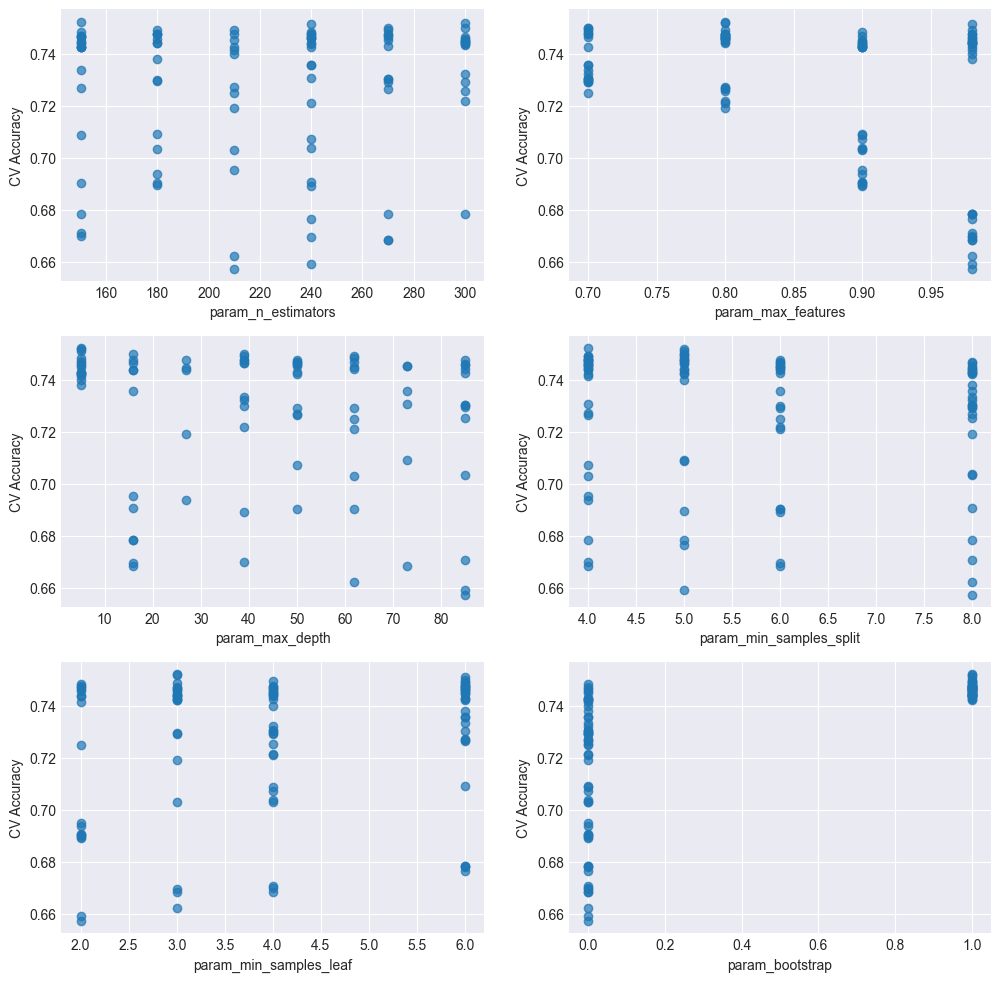

In [410]:
# Extracting hyperparameter tuning results and checking
rf_cv_res = pd.DataFrame(rfc_damage_hyperparam_tuning.cv_results_)

# Scatter plot of selection of hyperparams vs performance
num_keys = len(hyperparam_grid.keys())
fig, axs = plt.subplots(num_keys // 2 + num_keys % 2, 2, figsize=(12,12))
for i, param in enumerate([ f"param_{key}" for key in hyperparam_grid.keys()]):    
    axs[i//2][i%2].scatter(x=rf_cv_res[param], y=rf_cv_res['mean_test_score'], alpha=0.7)
    axs[i//2][i%2].set_xlabel(param)
    axs[i//2][i%2].set_ylabel('CV Accuracy')

### Gradient Boosting Machine Classifier

Instead, we will try again to resort to a Gradient Boosting classifier, but **we will also include the resampled** dataset in the training to equalize the classes in the training dataset and in addition, we will modify the `scoring` parameter in the CV search to yield the best recall on the damage instead of optimizing for accuracy.

So now we have a balanced dataset between the damage & no-damage events. Let's process to train the classifier, let's do a random search to start with. At first, we tried putting in the `recall` option for the `scoring` kwarg, however this seemed to overfit : recall of 0.99 on the training dataset, but only 0.29 on the test dataset. In hindsight, this is probably logical as the model pushes the TP or FN in the right direction. So a balanced metric for optimisation is probably more usefull, so leave at default or try 'F1' ? Interestingly, this too did not seem to work (the recall on the training dataset is very much overfitted : 1.0, as opposed to 0.16 on the test dataset)). This is likely because we have already resampled the dataset. So we will train / scan the classifiers using the default loss function and scoring for recall in the scan, but try to optimise further for recall in the precision recall curve.

In [411]:
# Define amount of hyperparameter tuning combinations to sample
n_hyperparams_sample = 200

# Defining grid of candidate values to sample from
n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=50)]
learning_rate = [x for x in np.logspace(start=-3, stop=-0.01, num=50)]  # Important for GBM!
max_features = [int(x) for x in np.linspace(start=5, stop=150, num=20)]
max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
min_samples_split = [2, 5, 10, 30]
min_samples_leaf = [1, 2, 4, 10, 30]
subsample = [0.4, 0.6, 0.8, 1]
hyperparam_grid = {'n_estimators': n_estimators,
                   'learning_rate': learning_rate,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'subsample': subsample}

if os.path.exists(gbmc_damage_scan_filename) and not overwrite_GBM_model_training:
    print(f"Re-loading random search from {gbmc_damage_scan_filename}")
    gbmc_damage_hyperparam_tuning = joblib.load(gbmc_damage_scan_filename)

else:
    # Data splitter setup
    n_folds = 5
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)

    # Running random search
    gbmc_damage = GradientBoostingClassifier(loss='log_loss', random_state=seed)
    gbmc_damage_hyperparam_tuning = RandomizedSearchCV(estimator=gbmc_damage, 
                                            param_distributions=hyperparam_grid, 
                                            n_iter=n_hyperparams_sample, 
                                            cv=kfold, 
                                            verbose=2, 
                                            scoring='recall',# scoring='recall' to optimise for recall                                          
                                            random_state=seed, 
                                            n_jobs=-1)  # get best recall as score on the damaged case

    # Executing / fitting the random search CV on the resampled dataset
    gbmc_damage_hyperparam_tuning.fit(X=X_train_oversample, y=y_train_oversample)


    # -- and write out
    joblib.dump(value=gbmc_damage_hyperparam_tuning, 
                filename=f"gbmc_damage_random_search.pkl")

    print(f"Written scan to : {gbmc_damage_scan_filename}")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Written scan to : models\gbmc_damage_random_search.pkl


In [412]:
print('GBM best hyperparameter values according to random search: {}' .format(gbmc_damage_hyperparam_tuning.best_params_))

# Refitting the optimal model on the whole training dataset
gbmc_damage_opt1 = gbmc_damage_hyperparam_tuning.best_estimator_
gbmc_damage_opt1.fit(X=X_train_oversample, y=y_train_oversample)

# Getting predictions on original train and test set, not the resampled dataset...
gbmc_damage_opt1_y_train_pred = gbmc_damage_opt1.predict(X=X_train)
gbmc_damage_opt1_y_test_pred = gbmc_damage_opt1.predict(X=X_test)

# Checking accuracy manually
print('Train accuracy of the refitted model: %.3f' % gbmc_damage_opt1.score(X=X_train, y=y_train))
print('Test accuracy of the refitted model: %.3f' % gbmc_damage_opt1.score(X=X_test, y=y_test))


print('Train recall of the refitted model: %.3f' % recall_score(y_pred=gbmc_damage_opt1_y_train_pred, y_true=y_train))
print('Test recall of the refitted model: %.3f' % recall_score(y_pred=gbmc_damage_opt1_y_test_pred, y_true=y_test))

GBM best hyperparameter values according to random search: {'subsample': 0.4, 'n_estimators': 577, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 43, 'max_depth': 3, 'learning_rate': 0.48405862093968666}
Train accuracy of the refitted model: 0.998
Test accuracy of the refitted model: 0.651
Train recall of the refitted model: 0.995
Test recall of the refitted model: 0.344


In [413]:
# Classification report 
target_names = ['no damage', 'damage']
print(classification_report(y_true=y_test, y_pred=gbmc_damage_opt1_y_test_pred, target_names=target_names))

              precision    recall  f1-score   support

   no damage       0.77      0.76      0.76       739
      damage       0.32      0.34      0.33       250

    accuracy                           0.65       989
   macro avg       0.55      0.55      0.55       989
weighted avg       0.66      0.65      0.65       989



Here we will manually optimize the cutoff to boost the recall performance a bit, however, we don't want to compromise too much on misidentification. A cutoff of 0.3 seems reasonable, that results in a slightly better recall of 0.44 with roughly similar values for the precision. 

Text(0, 0.5, 'recalls')

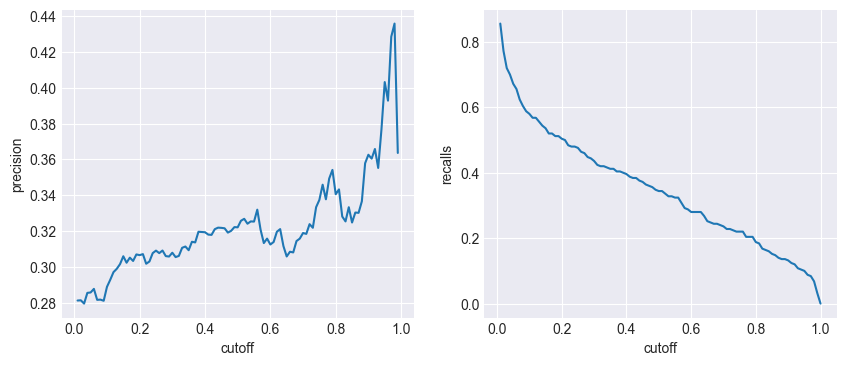

In [414]:
# -- here we have a look at the recall and precision as a function of cutoff
cutoffs = np.arange(1, 101) / 100  # Range of cutoffs

precisions = [y_test[gbmc_damage_opt1.predict_proba(X=X_test)[:,1] > c].mean() for c in cutoffs]
recalls = [recall_score(y_test, gbmc_damage_opt1.predict_proba(X=X_test)[:,1] > c) for c in cutoffs]

fig, axs = plt.subplots(1, 2, figsize=(10,4))

axs[0].plot(cutoffs, precisions)
axs[0].set_xlabel('cutoff')
axs[0].set_ylabel('precision')

axs[1].plot(cutoffs, recalls)
axs[1].set_xlabel('cutoff')
axs[1].set_ylabel('recalls')

In [415]:
# here choose a cutoff value, converged upon 0.3 instread of the default 0.5
cutoff = 0.3

# Refitting an RF with the tuned hyperparameters from the previous cell
print(f"Checking parameters : {gbmc_damage_opt1}")

# Getting performances & classification report
print('Train accuracy: %.3f' % gbmc_damage_opt1.score(X=X_train, y=y_train))
print('Test accuracy: %.3f' % gbmc_damage_opt1.score(X=X_test, y=y_test))
target_names = ['No damage', 'Damage']
print(classification_report(y_test, (gbmc_damage_opt1.predict_proba(X=X_test)[:, 1] > cutoff), target_names=target_names))

Checking parameters : GradientBoostingClassifier(learning_rate=0.48405862093968666, max_features=43,
                           min_samples_leaf=4, min_samples_split=5,
                           n_estimators=577, random_state=43, subsample=0.4)
Train accuracy: 0.998
Test accuracy: 0.651
              precision    recall  f1-score   support

   No damage       0.78      0.67      0.72       739
      Damage       0.31      0.44      0.36       250

    accuracy                           0.61       989
   macro avg       0.54      0.55      0.54       989
weighted avg       0.66      0.61      0.63       989



We tried plotting a learning curve (for accuracy) for this, to see whether the number of samples still has any impact, but it seems there is little to be gained from more data. 

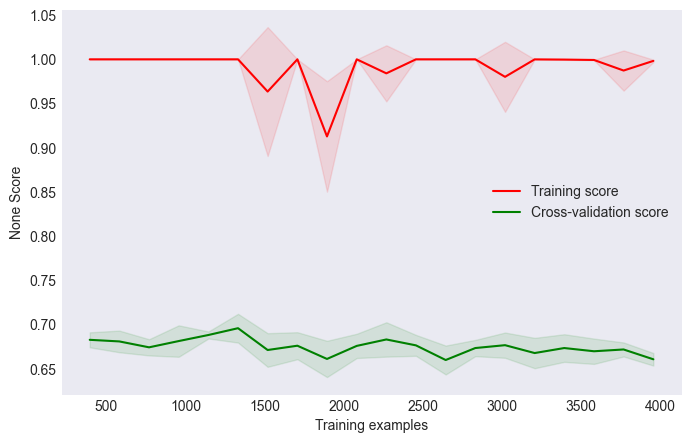

In [416]:
# The learning_curve for our model
cuf.plot_learning_curve(model=gbmc_damage_opt1, 
                    X=train_V2.drop(target_features, axis=1), 
                    y=train_V2['outcome_damage_inc'], 
                    cv=5, 
                    num_show=20)

#### Calibration

We looked at the calibration for both the best random forest and GBM classifiers to see whether the predicted probabilities are accurate. 

Text(0.5, 1.0, 'Gradient Booster')

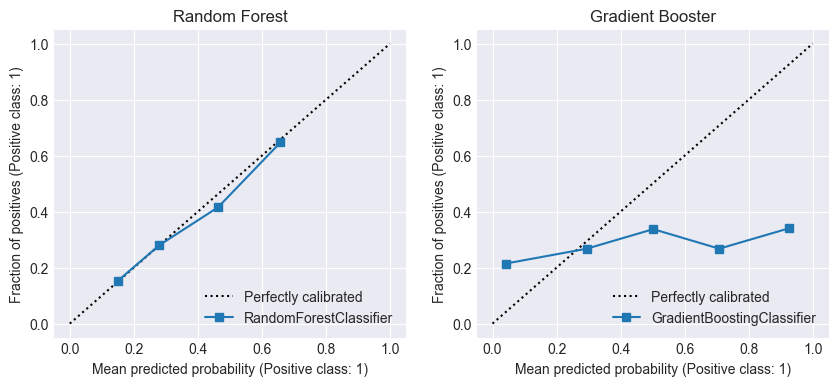

In [417]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

CalibrationDisplay.from_estimator(estimator=rfc_damage_best,
                                  X=X_test, 
                                  y=y_test,
                                  n_bins=5,
                                  strategy='uniform', 
                                  ax=ax[0])
ax[0].set_title("Random Forest")

CalibrationDisplay.from_estimator(estimator=gbmc_damage_opt1,
                                  X=X_test, 
                                  y=y_test,
                                  n_bins=5,
                                  strategy='uniform', 
                                  ax=ax[1])
ax[1].set_title("Gradient Booster")

We can see that the random forest classifier actually quite nicely follows the y=x line, so the probabilities it yields can probably effectively be interpreted as probabilities. This is however clearly not the case for the gradient booster. Here we would have to perform a calibration for the probabilities to be able to use them. This can be important for example if we would choose an approach in which we would calculate the final revenue (profit-damage) by first assessing the probability for damage & scale the predicted damage amount with that probability.

It was attempted - following the approach in the notebooks - to calibrate the gradient booster using a `CalibratedClassiferCV`, however we reached a similar conclusion as in the lecture notebooks that the results of the calibration, verified on an independent dataset (we fitted on the test & evaluated on the train dataset as in the lecture notebook - which does seem a bit strange...). So we will not include that code and those plots here and refer to the Github repository for previous versions. 

#### Lift curve

The lift curve shows how much better the predictive model is at identifying positive outcomes compared to random selection.

In a lift curve:

- The x-axis represents the percentage of the population targeted (e.g., top 10%, top 20%).
- The y-axis shows the lift, which is the ratio of the model response rate to the baseline response rate.
- The lift curve itself displays the relationship between the targeted population percentage and the lift value.

It is a tool that we can use to make sure that a majority of the selection will actually cause damage. 

In [418]:
#-- berekende classification lift- RF model
cuf.classification_lift(y_test.values,np.where(rfc_damage_best.predict_proba(X_test)[:,1]< 0.5, 0,1))

2.1098666666666666

In [419]:
#-- berekende classification lift- GBM model
cuf.classification_lift(y_test.values,np.where(gbmc_damage_opt1.predict_proba(X_test)[:,1]< 0.3, 0,1))

1.218090395480226

We see that the lift value for GBM is a bit lower than the lift value calculated for RF. Interesting, so if we need to create a list with people of which we are absolutly certain that they willl cause damage it is probably better to use RF to do a selection on the basis of the lift curve.

In [420]:
#-- cumulatieve lift
cumulative_lift_gbm = cuf.cumulative_classification_lift(y_test.values,np.where(gbmc_damage_opt1.predict_proba(X_test)[:,1]< 0.5, 0,1))
cumulative_lift_rf = cuf.cumulative_classification_lift(y_test.values,np.where(rfc_damage_best.predict_proba(X_test)[:,1]< 0.5, 0,1))

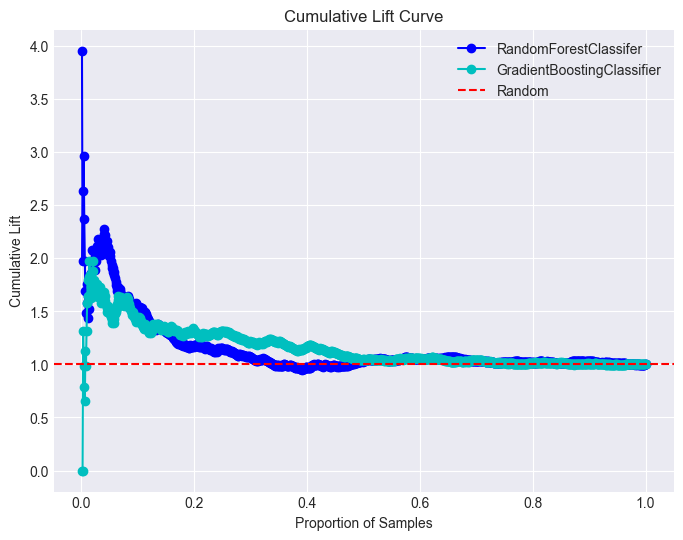

In [421]:
#-- Lift curve for clients causing damage ((rfc_damage_pred_proba[:,1])
# 
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(cumulative_lift_rf) + 1) / len(cumulative_lift_rf), cumulative_lift_rf, marker='o', linestyle='-', color='b')
plt.plot(np.arange(1, len(cumulative_lift_gbm) + 1) / len(cumulative_lift_gbm), cumulative_lift_gbm, marker='o', linestyle='-', color='c')
plt.axhline(y=1, color='red', linestyle='--')
plt.xlabel('Proportion of Samples')
plt.ylabel('Cumulative Lift')
plt.title('Cumulative Lift Curve')
plt.legend(['RandomForestClassifer', 'GradientBoostingClassifier', 'Random'])
plt.grid(True)
plt.show()

### Final model selection

The selection for the classification model has been subject to some discussion in the team. The accuracy of a simple logistic regression was already quite high and neither of the more advanced classifiers did significantly better. We established that recall is the better metric to optimise and after some tuning, the GBM approach with additional cut-off tuning did yield the better results for that metric. However, we did notice that the probabilities were not as good as for the RF, and hence (?) also the lift-curve seemed to yield lower lift values, so it could probably be argued that if we wanted to make a list with the clients which will certainly cause damage (a list of people to keep an eye on let's say), that we could also use the results of the random forest classifiers and list the - let's say - 30 % most probable. But we are more concerned with finding all the clients that will cause damage, so the gradient boosting classifier is maybe more suited for our purposes. After all we did optimise for recall, which will result in a larger number of false positives, but we are less concerned about these because we assume that in the damage cost modelling they are likely to get a low or nearly zero cost estimate. It would be great to get some input on this issue as we did not seem to be able to converge on a final best strategy. So here we simply select the gradient booster, as this has been optimised for recall and now seems to be best suited for our goal. 

In [422]:
# -- Here final model selection...
model_damage_inc = gbmc_damage_opt1

# Whiteboxing and explainability

Keeping the executive summary in mind, it is important to be able to explain why certain guests were allowed in. In other words, what features are most important. As the final goals is predicting the revenue, we shall restrict ourselves to analysing this for `outcome_revenue` and use our best model from that analysis. 

To evaluate the results and not having to run the cross validation repeatedly the selected models were saved and are reloaded below.

In [423]:
# get the best model for the revenue prediction
revenue_best = model_revenue

In [424]:
#-- Needed for explainability: Mind to use the correct target for the corresponding model

train_V2 = pd.read_csv(os.path.join( 'output', 'train_v2_prep_without_outliers.csv')).set_index("Id", drop=True)
score = pd.read_csv(os.path.join('output', 'score_prep_without_outliers.csv'))

X_train, X_test, y_train, y_test = train_test_split(train_V2.drop(target_features, axis=1),
                                                    train_V2['outcome_revenue'],   # target DF/series
                                                    test_size=0.2, 
                                                    shuffle=True,  
                                                    random_state=seed)  

## Feature importance

Below we determine in a few different ways the feature importance to be able to establish what features are important for a guest to be allowed in (and therefore be more profitable). First we look at the feature importance included in the model itself. 

In [425]:
# -- determine the feature importance
feature_importance = pd.DataFrame(
    {
        'feature': model_revenue.feature_names_in_, 
        'importance': model_revenue.feature_importances_
    })\
        .sort_values(by='importance', ascending=False)\
        .reset_index(drop=True)

feature_importance.head(10)

,feature,importance
0,profit_am,0.458141
1,nights_booked,0.298962
2,presidential,0.053040
3,shop_am,0.035428
4,cab_requests,0.015323
5,income_am,0.013611
6,damage_am,0.013358
7,avg_score_pos,0.012221
8,bar_no,0.011665
9,age,0.011235


Text(0.5, 1.0, 'Top 10 feature importance for for the selected GBM model on revenue')

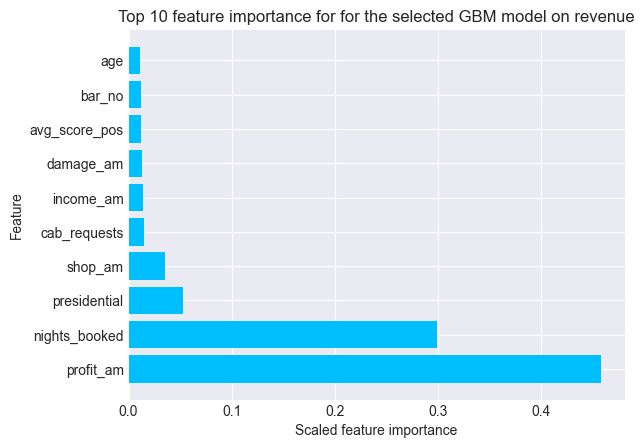

In [426]:
plt.barh(y=feature_importance.head(10)['feature'], width=feature_importance.head(10)['importance'], color='deepskyblue'); # pretty colors wow
plt.xlabel('Scaled feature importance')
plt.ylabel('Feature')
plt.title(f'Top 10 feature importance for for the selected GBM model on revenue')

Next, we look at permutation importance. 

In [427]:
revenue_best_fi_perm = permutation_importance(estimator=model_revenue, 
                                     X=X_train, 
                                     y=y_train, 
                                     n_repeats=5,  
                                     random_state=seed)

# Converting to a Pandas DataFrame & sorting by importance
revenue_best_fi_perm = (pd.DataFrame({'feature': X_train.columns,
                               'importance_mean': revenue_best_fi_perm['importances_mean'],
                               'importance_std': revenue_best_fi_perm['importances_std']})
                  .sort_values(by='importance_mean', ascending=False)
                  .reset_index(drop=True))

revenue_best_fi_perm.head(10)

,feature,importance_mean,importance_std
0,nights_booked,1.472155,0.042869
1,profit_am,1.261858,0.083756
2,presidential,0.071354,0.003283
3,shop_am,0.045198,0.001835
4,cab_requests,0.027151,0.000902
5,damage_am,0.021038,0.001423
6,bar_no,0.017000,0.002211
7,income_am,0.015820,0.000824
8,avg_score_pos,0.015532,0.000806
9,age,0.015318,0.000627


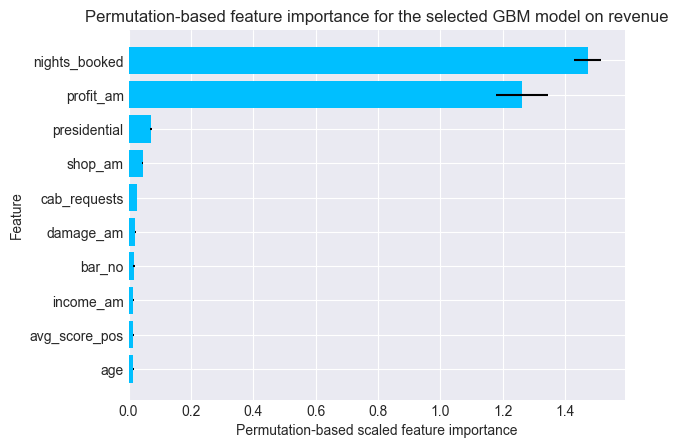

In [428]:
# Plotting the top 10 result again, with error bars
_k = 10
revenue_best_fi_perm_top_k = (revenue_best_fi_perm
                        .head(_k)
                        .sort_values(by='importance_mean', ascending=True))

# Plotting with error bars
plt.barh(y=revenue_best_fi_perm_top_k['feature'], 
         width=revenue_best_fi_perm_top_k['importance_mean'],
         xerr=revenue_best_fi_perm_top_k['importance_std'], 
         color='deepskyblue'); 
plt.xlabel('Permutation-based scaled feature importance');
plt.ylabel('Feature');
plt.title('Permutation-based feature importance for the selected GBM model on revenue');

And finally the drop column importance is also calculated.

In [429]:
#-- drop-column feature importance: assessing the impact or importance of a specific feature (column) in a machine learning model by running the model .
#   By dropping the column and observing the change in model performance, you can gauge the significance of that particular feature in predicting the target variable.
revenue_best_importance_drop = cuf.drop_col_feat_imp(model=model_revenue, 
                                         X=X_train, 
                                         y=y_train, 
                                         random_state=seed)

revenue_best_importance_drop.head(10)

,feature,importance
33,nights_booked,0.174480
2,profit_am,0.067590
21,presidential,0.015670
12,cab_requests,0.008484
35,shop_am,0.004513
34,gender,0.003270
16,neighbor_income,0.003252
39,avg_score_pos,0.003141
17,age,0.002648
18,marketing_permit,0.002635


Text(0, 0.5, 'Feature')

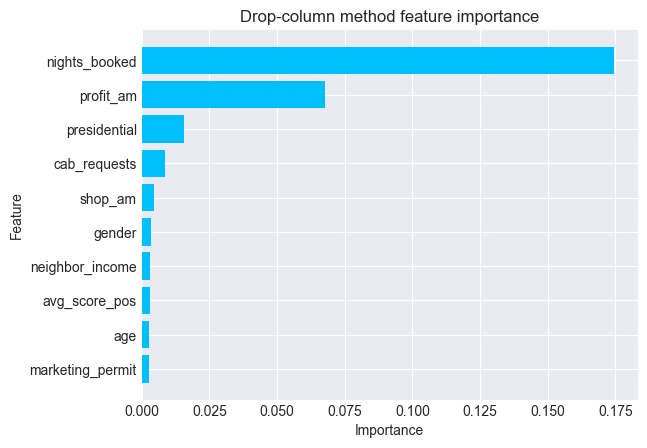

In [430]:
# Plotting top k of drop-column feature importance
_k = 10
revenue_best_importances_drop_top_k = (revenue_best_importance_drop.sort_values(by='importance', ascending=False)
                             .head(_k)
                             .sort_values(by='importance', ascending=True)) # To get it to plot nicely (sort WITHIN top _k)

# Plotting
plt.barh(y=revenue_best_importances_drop_top_k ['feature'], 
         width=revenue_best_importances_drop_top_k['importance'], 
         color='deepskyblue', 
         ecolor='black')
plt.title('Drop-column method feature importance')
plt.xlabel('Importance')
plt.ylabel('Feature')

### Conclusion
In all tree techniques paint a slightly different picture. Especially the drop column feature importance seems to be significantly different from the other two. For these other two analyses we obtain `nights_booked` and `profit_am` as most important features and then `shop_am` or `presidential`. However, for the drop-columns method, the `bar_no` and `cab_requests`as well as the scores given by the hotel staff seem to be most important. This is not completely unexpected. The `bar_no` and `cab_requests` were associated in the correlation analysis with the damage, so here it seems that those are also instrumental in predicting the revenue. 

## Linear surrogate explainability models (what is the influence of a feature)

Feature importance only tell us one thing for each feature: was it important for the whole model under consideration or not? There are other questions to answer: exactly how are the features related to the target variable, which direction and what magnitude? To this end, we build a surrogate regression model that uses the predicted value from the model you want to explain as a target. Obviously, we want this surrogate model to be explainable to some degree, and this is why linear regression comes into play.

Before we apply linear regression to see how a feature influences the prediction we predict the revenue for the features in the training set. 


In [431]:
# Relating feature importance to the target with linear surrogate models
from sklearn.linear_model import LinearRegression  # We will be needing our linear regression class

# Getting predicted values for the model we want to inspect
revenue_best_preds_train = revenue_best.predict(X=X_train)

# Standardize y
y_pred_norm = np.array((revenue_best_preds_train-revenue_best_preds_train.mean()) / np.sqrt(revenue_best_preds_train.var())).reshape(-1, 1)

# Fit a univariate linear regression for all predictors separately, using predicted value from Gradient boosting as target here!
beta_surrogate_summary = pd.Series(index=X_train.columns, name='beta', dtype='float')  # Initialize empty Pandas Series with column names as rowindex
for feat in X_train.columns:
    current_X = np.array(X_train[feat]).reshape(-1, 1)
    reg_surrogate = LinearRegression().fit(X=current_X, y=y_pred_norm)
    beta_surrogate_summary.at[feat] = reg_surrogate.coef_[0] 

# Checking result on 5 coeffs
print('5 coefficients of our surrogate univariate regressions for explainability, summarized:')
beta_surrogate_summary.head(5)

5 coefficients of our surrogate univariate regressions for explainability, summarized:


income_am         0.000049
profit_last_am    0.000059
profit_am         0.000067
damage_am         0.000117
damage_inc        0.009169
Name: beta, dtype: float64

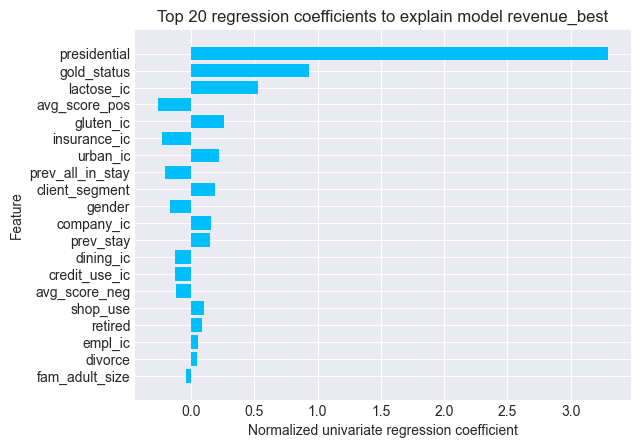

In [432]:
# Plotting the top k (20) univariate regression coefs in absolute value
_k = 20
beta_surrogate_summary_top_k = (beta_surrogate_summary.sort_values(key=abs, ascending=False)
                                .head(_k)
                                .sort_values(key=abs, ascending=True))

plt.barh(y=beta_surrogate_summary_top_k.index, width=beta_surrogate_summary_top_k, color='deepskyblue');
plt.xlabel('Normalized univariate regression coefficient')
plt.ylabel('Feature');
plt.title(f"Top {_k} regression coefficients to explain model revenue_best");

In [433]:
# Showing top 5 negative features
print('Most negative univariate betas:')
print(beta_surrogate_summary.sort_values(ascending=True).head(5))

# Showing top 5 positive features
print('\nMost positive univariate betas:')
print(beta_surrogate_summary.sort_values(ascending=False).head(5))

Most negative univariate betas:
avg_score_pos      -0.264320
insurance_ic       -0.233392
prev_all_in_stay   -0.209262
gender             -0.165012
dining_ic          -0.128370
Name: beta, dtype: float64

Most positive univariate betas:
presidential    3.298380
gold_status     0.929052
lactose_ic      0.530312
gluten_ic       0.264214
urban_ic        0.218739
Name: beta, dtype: float64


In [434]:
# Checking how the permutation importance features do on the univariate surrogate models
beta_surrogate_summary.loc[revenue_best_importances_drop_top_k['feature']]

marketing_permit   -0.032151
age                 0.003430
avg_score_pos      -0.264320
neighbor_income     0.000017
gender             -0.165012
shop_am             0.000072
cab_requests       -0.028811
presidential        3.298380
profit_am           0.000067
nights_booked      -0.007695
Name: beta, dtype: float64

In [435]:
# Surrogate multiple linear regression model (only on top 20 models of permutation importance on rf1)
# Getting normalized features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit_transform(X=X_train[feature_importance.head(20)['feature']])

X_train_norm = scaler.transform(X_train[feature_importance.head(20)['feature']])
y_pred_train_norm = np.array((revenue_best_preds_train - revenue_best_preds_train.mean()) / np.sqrt(revenue_best_preds_train.var())).reshape(-1, 1)

# Fitting model
multiple_surrogate_reg = LinearRegression().fit(X=X_train_norm, y=y_pred_train_norm)
beta_surrogate_multiple_summary = pd.DataFrame(data={'feature': feature_importance.head(20)['feature'].values,
                                                     'coef': multiple_surrogate_reg.coef_[0]})
print(beta_surrogate_multiple_summary.sort_values(by='coef', key=abs, ascending=False))

             feature      coef
0          profit_am  0.418728
1      nights_booked -0.338412
2       presidential  0.222745
3            shop_am  0.101550
6          damage_am  0.089689
10   neighbor_income  0.089308
4       cab_requests -0.078844
7      avg_score_pos -0.071783
18  prev_all_in_stay -0.066670
17       crd_lim_rec -0.064461
15       children_no  0.060143
8             bar_no -0.050128
9                age  0.049833
13    profit_last_am -0.049769
19         prev_stay  0.047339
14            gender -0.044939
16  marketing_permit -0.042367
5          income_am  0.033090
11     avg_score_neg  0.010545
12        tenure_mts -0.005671


In [436]:
# Showing top 5 negative features
print('Most negative multivariate betas:')
print(beta_surrogate_multiple_summary.sort_values(by=['coef'], ascending=True).head(5))

# Showing top 5 positive features
print('\nMost positive multivariate betas:')
print(beta_surrogate_multiple_summary.sort_values(by=['coef'], ascending=False).head(5))

Most negative multivariate betas:
             feature      coef
1      nights_booked -0.338412
4       cab_requests -0.078844
7      avg_score_pos -0.071783
18  prev_all_in_stay -0.066670
17       crd_lim_rec -0.064461

Most positive multivariate betas:
            feature      coef
0         profit_am  0.418728
2      presidential  0.222745
3           shop_am  0.101550
6         damage_am  0.089689
10  neighbor_income  0.089308


### Conclusion:
With these surrogate linear regression models we try to give an indication on how the model outcome changes due to the impact of  different features. This is indicated with a negative beta or positive beta.  

We do not find the most important features (nights_booked, profit_am) in the list of features with the highest beta's, except for presidential, in the univariate analysis. That is a bit strange. We do find these features in the multivariate analysis, therefore we believe that multivariate regression gives a better indication on the impact of the features than the univariate analysis.

## Why is the prediction what it is
### Tree interpreter
To help understand why a prediction is what it is the tree interpreter can be used. The tree interpreter provides insights into how a decision tree model arrives at a particular prediction by tracing the path taken through the tree for that instance.

Because we chose a GBM model als the most optimal sollution we will not do a tree interpreter analysis, as it cannot be used with a GBM. In the Github repository you can find that we did apply it for the RF model.

### SHAP

We tried using SHAP to gain a deeper understanding of our model's behavior and to improve credability in the predictions.
SHAP values aim to explain the impact of each feature on the prediction by assigning a value to each feature, indicating its contribution to the final prediction.



c:\JAVA\anaconda3\envs\MachineLearning\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


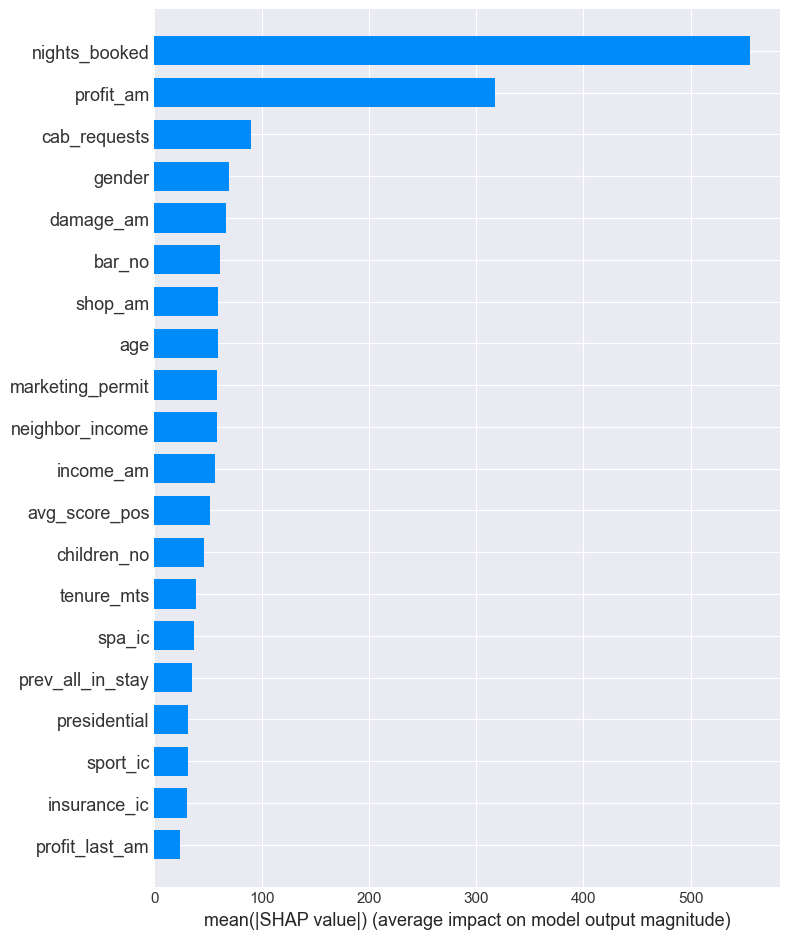

In [437]:
# Importing shap package
import shap

# Instantiate and explain using shap
explainer = shap.TreeExplainer(model=revenue_best)
shap_values = explainer.shap_values(X_train)

# 'bar'-type summary plot
shap.summary_plot(shap_values=shap_values, 
                  features=X_train, 
                  plot_type='bar')

### Conclusion
These techniques confirm what we have seen in the previous explainability exercises we did. 

SHAP values for  profit_am and nights_booked are as we expected high, the factor for income_am is lower than expected. We believe that this may be due to scaling. In the gradientBooster we did not scale the features:
- Income (max = 157697) is in a higher scale than presidential (max = 1) or nights_booked (max = 375).

# Selection of final list of guests

Finally, we will perform the selection of the guest list which yields the highest revenu on the **score** dataset. We also compare this selection of the 200 highest revenu clients with a random selection. This perhaps gives an indication of the added value of the model, however obviously we also use the model to predict the revenu for those that we select randomly, so this may not be the best indicator.

In [438]:
# -- predict the revenue according to the best = the selected model
score['revenue_pred'] = model_revenue.predict(score.drop(columns=['Id']))

# -- predict the revenue for the selected list of 200 clients with the revenue of a random sample
selection = score.sort_values('revenue_pred', ascending=False).head(200)

# -- compare this selection to a random selection from the predicted scores.
total = 0
n_samples = 100
for i in range(100):
    sample = score.sample(200)
    total += sample['revenue_pred'].sum()

total_revenue_pred_selection = selection['revenue_pred'].sum()
total_revenue_pred_sample = total / n_samples

print('The estimated revenue of the selection is %.3f, ' % total_revenue_pred_selection)
print('The estimated revenue of the random sample is %.3f, ' % total_revenue_pred_sample)
print('This means that by applying the selection the model predicts a gain of %.3f!!! ' % (total_revenue_pred_selection - total_revenue_pred_sample))

The estimated revenue of the selection is 528266.374, 
The estimated revenue of the random sample is 439704.535, 
This means that by applying the selection the model predicts a gain of 88561.839!!! 


These figures are usefull for the executive summary, let's also visualize them in a graph.

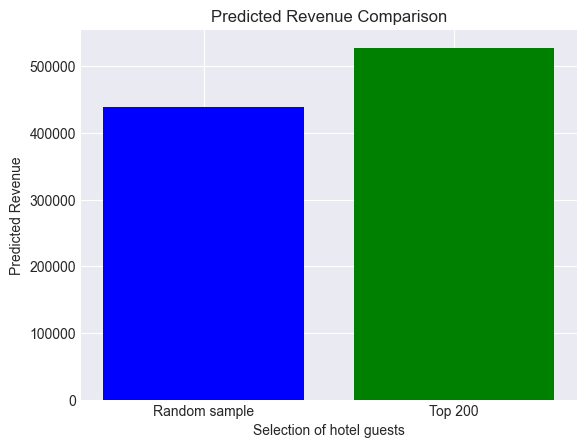

In [439]:
# Creating the dataframe
data = {
    'Labels': ['Random sample', 'Top 200'],
    'Predicted Revenue': [total_revenue_pred_sample, total_revenue_pred_selection]
}

df = pd.DataFrame(data)

# Plotting the bar chart
plt.bar(df['Labels'], df['Predicted Revenue'], color=['blue', 'green'])
plt.xlabel('Selection of hotel guests')
plt.ylabel('Predicted Revenue')
plt.title('Predicted Revenue Comparison')
plt.show()

Let's save that list to a csv : 

In [440]:
# -- save the selected guests to the output folder
selection.to_csv(os.path.join('output', 'selected_guests.csv'))

# Export the predictions for all instances in score to csv

Delete extra columns if they exist

In [441]:
if 'revenue_pred' in score.columns:
    score.drop(columns=['revenue_pred'], inplace=True)
if 'profit_pred' in score.columns:
    score.drop(columns=['profit_pred'], inplace=True)
if 'damage_pred' in score.columns:
    score.drop(columns=['damage_pred'], inplace=True)
if 'damage_inc_pred' in score.columns:
    
    score.drop(columns=['damage_inc_pred'], inplace=True)

score_without_targetfeatures = score.copy().drop(columns=['Id'])
#column 'Id' may give problems - if it was removed before you do not have to add previous row

Predict the targets according to the best models.

In [442]:
score['revenue_pred'] = model_revenue.predict(score_without_targetfeatures)
score['profit_pred'] = model_profit.predict(score_without_targetfeatures)
score['damage_pred'] = model_damage.predict(score_without_targetfeatures)
score['damage_inc_pred'] = model_damage_inc.predict(score_without_targetfeatures)

In [443]:
# -- save the new score csv to the output folder
selection.to_csv(os.path.join('output', 'score_predicted.csv'))